In [10]:
import os
import math
import csv
import glob
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from matplotlib.rcsetup import cycler
import seaborn as sns
from itertools import product, groupby
import toolz
from collections import defaultdict, Counter, OrderedDict
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import count_kmers
import fasta_parser

In [72]:
def get_sequence_skew(sequence):
    """Returns the difference between the total number of
    occurrences of G and the total number of occurrences of C in
    the first i elements of the sequence. """
    seq_len = len(sequence)
    skew = np.zeros(seq_len)
    for idx, element in enumerate(sequence):
        if sequence[idx] == 'G':
            skew[idx] += 1
        elif sequence[idx] == 'C':
            skew[idx] -= 1
        else:
            skew[idx] = 0
    return skew

In [3]:
filenames_all = glob.glob('Data/Genomes_splitted/*/Chromosomes/*_chr.fna.gz')

In [83]:
filenames_all

['Data/Genomes_splitted/Methyloligella/Chromosomes/GCF_013341275.1_chr.fna.gz',
 'Data/Genomes_splitted/Xenorhabdus/Chromosomes/GCF_003575005.1_chr.fna.gz',
 'Data/Genomes_splitted/Xenorhabdus/Chromosomes/GCF_000252955.1_chr.fna.gz',
 'Data/Genomes_splitted/Xenorhabdus/Chromosomes/GCF_001721185.1_chr.fna.gz',
 'Data/Genomes_splitted/Xenorhabdus/Chromosomes/GCF_014295015.1_chr.fna.gz',
 'Data/Genomes_splitted/Xenorhabdus/Chromosomes/GCF_000973125.1_chr.fna.gz',
 'Data/Genomes_splitted/Xenorhabdus/Chromosomes/GCF_000027225.1_chr.fna.gz',
 'Data/Genomes_splitted/Xenorhabdus/Chromosomes/GCF_000953355.1_chr.fna.gz',
 'Data/Genomes_splitted/Xenorhabdus/Chromosomes/GCF_017743015.1_chr.fna.gz',
 'Data/Genomes_splitted/Xenorhabdus/Chromosomes/GCF_000968195.1_chr.fna.gz',
 'Data/Genomes_splitted/Xenorhabdus/Chromosomes/GCF_000968175.1_chr.fna.gz',
 'Data/Genomes_splitted/Undibacterium/Chromosomes/GCF_003955735.1_chr.fna.gz',
 'Data/Genomes_splitted/Undibacterium/Chromosomes/GCF_009937975.1_chr.f

In [33]:
def get_strand_complement(sequence):
    """Returns the complement strand of the genome.
     
     Inputs:
        sequence - string representing the sequence   

    Outputs:
    
        sequence - string representing the complement of 
                   the string.    
    """
    # make the sequence upper case
    seq = sequence.upper()
    # table to change the complement characters
    change = str.maketrans('ACGT', 'TGCA')
    return seq.translate(change)


def get_reverse_complement(sequence):
    """
    Returns the reverse complement strand of the genome.

    Inputs:

        sequence - string representing the sequence.

    Outputs:

        reversed_complement_sequence - string representing the reversed
                                       sequence complement.
    """
    return get_strand_complement(sequence)[::-1]

In [80]:
#zeroOrderExpected(sequence, k): computes the expected number of a kmer in a genome using a 
# zero order markov model. Takes as input a sequence and a value for k
# returns a dictionary with the kmers as keys and the expected number as values
def zeroOrderExpected(sequence, k):
	#construct a dictionary of all kmers
	kmerDict = dict((key, 0 ) for key in enumerateKmers(k))
	nucleotides = kmerCount(sequence, 1, probability=True)

	# calc expeccted number for each kmer in the dict
	for kmer in kmerDict.keys():
		kA = kmer.count('A')
		kT = kmer.count('T')
		kC = kmer.count('C')
		kG = kmer.count('G')
		eKmer = (math.pow(nucleotides['A'],kA) * \
				 math.pow(nucleotides['T'],kT) * \
				 math.pow(nucleotides['C'],kC) * \
				 math.pow(nucleotides['G'],kG))* \
				(len(sequence)-k+1)
		kmerDict[kmer] = eKmer
	return kmerDict

In [5]:
def get_expected_higher_markov(kmer_list, kmer_counts):
    """
    Calculates the expected value for a list of kmers and their counts.
    
    Inputs:
        kmer_list - list-like object representing all kmer counted in a sequence.
                    The kmers have a length k.
        kmer_counts - dictionary-like object mapping kmer to their counts. The
                      kmer lengths must be between kmin (kmx-2) and kmax.
    
    Output:
    
        expected - dictionary-like object mapping kmer of length k to their 
                   calculated expected values.
    
    The expected values are calculated as:
    'Expected = kmer[:-1] * kmer[1:] / kmer[1:-1]'
    """
    # initialize the container
    expected = defaultdict(float)
    # iterates through the list of kmers
    for kmer in kmer_list:
        # gets the suffix, prefix and middle kmers
        suf = kmer_counts[kmer[1:]]
        pref = kmer_counts[kmer[:-1]]
        mid = kmer_counts[kmer[1:-1]]
        # deal with sero division errors
        if mid == 0:
            expected[kmer] = 0.0
        else:
            # add the kmer and it expected values 
            expected[kmer] = (pref * suf) / mid
    return expected

In [7]:
def get_all_possible_kmers(alphabet, kmin, kmax):
    """Returns a list of all possible combinations of k-mers of
    length k from a input alphabet.

    Inputs:

        alphabet - a alphabet (strings characters) that compound the string sequence
        kmin - minimum DNA kmer length (int)
        kmax - maximum DNA kmer length (int)

    Outputs:

        kmers - list of all possible combinations of k-mers of length k with length
                between kmin and kmax.

    """
    kmers = [''.join(letters) for n in range(kmin, kmax + 1)
             for letters in product(alphabet, repeat=n)]
    return kmers

In [8]:
kl4 = get_all_possible_kmers('ACGT', 4, 4)

In [12]:
def kmerCount(sequence, k, probability=False):
	#construct a dictionary of all kmers
	kmerDict = dict((key, 0 ) for key in enumerateKmers(k))

	# slide a window of length k across the genome and add to dict
	for i in range(len(sequence)-k+1):
		if sequence[i:i+k] in kmerDict:
			kmerDict[sequence[i:i+k]] += 1
	# divide by number of kmers in the genome 
	if probability:
		for key in kmerDict.keys():
			kmerDict[key] = float(kmerDict[key])/(len(sequence)-k+1)
	return kmerDict

In [11]:
for Id, sequence in fasta_parser.parse_fasta(filenames_all[0]):
    sequence = sequence

In [14]:
kc4 = count_kmers.count_kmers(sequence, 2, 4)

In [17]:
kc4['AACA'], kc4['AAC'], kc4['AC'], (kc4['ACA']*kc4['AAC'])/kc4['AC']

(5554, 23051, 124952, 3664.3031964274282)

In [16]:
get_expected_higher_markov(kl4, kc4)

defaultdict(float,
            {'AAAA': 4609.1785295666505,
             'AAAC': 4560.900377121307,
             'AAAG': 9332.325156709192,
             'AAAT': 4792.59593660285,
             'AACA': 3664.3031964274282,
             'AACC': 8070.026850310519,
             'AACG': 9053.483545681542,
             'AACT': 2263.186407580511,
             'AAGA': 10895.0577821711,
             'AAGC': 18746.874370956146,
             'AAGG': 14086.116575305536,
             'AAGT': 3437.9512715672176,
             'AATA': 3179.077350958294,
             'AATC': 9689.991523873792,
             'AATG': 7511.794226900349,
             'AATT': 3841.1368982675654,
             'ACAA': 4064.6632763881466,
             'ACAC': 4255.729386819286,
             'ACAG': 6492.252943508766,
             'ACAT': 5050.354393283801,
             'ACCA': 8993.054798325496,
             'ACCC': 7471.44429895046,
             'ACCG': 19049.29283971192,
             'ACCT': 8231.03448207448,
             'ACGA

In [14]:
def enumerateKmers(k):
	alphabet = ['A','T','C','G']
	kmerList = ['']
	while k > 0:
		working = kmerList[:]
		kmerList = []
		for kmer in working:
			for letter in alphabet:
				kmerList.append(kmer+letter)
		k -= 1 
	return kmerList

In [13]:
def doZeroOrderExpected(fileName, k, subset=None, RC=False):
	sequence = parseFasta(fileName)
	# append reverse complement if RC=True
	if RC:
		sequence += reverseComplement(sequence)
	if subset != None:
		sequence = sequence[subset[0]:subset[1]]
	return zeroOrderExpected(sequence, k)

In [44]:
#     sequence = 'acccagagaacatat'
#     subset = [0, 10]
#     sequence[subset[0]:subset[1]]
#     'acccagagaa'

def do_get_expected_higher_markov(sequence, alphabet, kmer_list, kmax, as_subset=None, as_rev_seq=False):
    print(len(sequence))
    if as_rev_seq:
        sequence = sequence + get_reverse_complement(sequence)
        print(len(sequence))
    if as_subset != None:
        sequence = sequence[as_subset[0]:as_subset[1]]
        print(len(sequence))
    kmer_counts = count_kmers.count_kmers(sequence, kmax-2, kmax)
    expec = get_expected_higher_markov(kmer_list, kmer_counts)
    return {k:v for (k,v) in expec.items() if v > 0.0}

In [40]:
len(sequence)

3230794

In [59]:
r = sequence + get_reverse_complement(sequence)

In [61]:
count_kmers.count_kmers(r, 4-2, 4)

defaultdict(int,
            {'AA': 244768,
             'AC': 259467,
             'AG': 351393,
             'AT': 317126,
             'CA': 366881,
             'CC': 560848,
             'CG': 778917,
             'CT': 351393,
             'GA': 447429,
             'GC': 790296,
             'GG': 560848,
             'GT': 259467,
             'TA': 113676,
             'TC': 447429,
             'TG': 366881,
             'TT': 244768,
             'AAA': 50090,
             'AAC': 50566,
             'AAG': 94745,
             'AAT': 49367,
             'ACA': 42130,
             'ACC': 98857,
             'ACG': 93233,
             'ACT': 25246,
             'AGA': 80694,
             'AGC': 144860,
             'AGG': 100593,
             'AGT': 25246,
             'ATA': 41614,
             'ATC': 132723,
             'ATG': 93422,
             'ATT': 49367,
             'CAA': 75606,
             'CAC': 82814,
             'CAG': 115039,
             'CAT': 93422,
       

In [62]:
count_kmers.count_kmers(r[:100], 4-2, 4)

defaultdict(int,
            {'AA': 10,
             'AC': 6,
             'AG': 8,
             'AT': 3,
             'CA': 6,
             'CC': 1,
             'CG': 10,
             'CT': 5,
             'GA': 9,
             'GC': 10,
             'GG': 11,
             'GT': 5,
             'TA': 2,
             'TC': 5,
             'TG': 6,
             'TT': 2,
             'AAA': 4,
             'AAC': 2,
             'AAG': 3,
             'AAT': 1,
             'ACA': 2,
             'ACC': 0,
             'ACG': 3,
             'ACT': 1,
             'AGA': 4,
             'AGC': 3,
             'AGG': 1,
             'AGT': 0,
             'ATA': 0,
             'ATC': 1,
             'ATG': 2,
             'ATT': 0,
             'CAA': 4,
             'CAC': 1,
             'CAG': 1,
             'CAT': 0,
             'CCA': 1,
             'CCC': 0,
             'CCG': 0,
             'CCT': 0,
             'CGA': 1,
             'CGC': 2,
             'CGG': 4,
      

In [63]:
count_kmers.count_kmers(sequence[:100], 4-2, 4)

defaultdict(int,
            {'AA': 10,
             'AC': 6,
             'AG': 8,
             'AT': 3,
             'CA': 6,
             'CC': 1,
             'CG': 10,
             'CT': 5,
             'GA': 9,
             'GC': 10,
             'GG': 11,
             'GT': 5,
             'TA': 2,
             'TC': 5,
             'TG': 6,
             'TT': 2,
             'AAA': 4,
             'AAC': 2,
             'AAG': 3,
             'AAT': 1,
             'ACA': 2,
             'ACC': 0,
             'ACG': 3,
             'ACT': 1,
             'AGA': 4,
             'AGC': 3,
             'AGG': 1,
             'AGT': 0,
             'ATA': 0,
             'ATC': 1,
             'ATG': 2,
             'ATT': 0,
             'CAA': 4,
             'CAC': 1,
             'CAG': 1,
             'CAT': 0,
             'CCA': 1,
             'CCC': 0,
             'CCG': 0,
             'CCT': 0,
             'CGA': 1,
             'CGC': 2,
             'CGG': 4,
      

In [53]:
a = do_get_expected_higher_markov(sequence, 'ACGT', kl4, 4, as_subset=None, as_rev_seq=False)

3230794


In [54]:
b = do_get_expected_higher_markov(sequence, 'ACGT', kl4, 4, as_subset=None, as_rev_seq=True)

3230794
6461588


In [56]:
a

{'AAAA': 4609.1785295666505,
 'AAAC': 4560.900377121307,
 'AAAG': 9332.325156709192,
 'AAAT': 4792.59593660285,
 'AACA': 3664.3031964274282,
 'AACC': 8070.026850310519,
 'AACG': 9053.483545681542,
 'AACT': 2263.186407580511,
 'AAGA': 10895.0577821711,
 'AAGC': 18746.874370956146,
 'AAGG': 14086.116575305536,
 'AAGT': 3437.9512715672176,
 'AATA': 3179.077350958294,
 'AATC': 9689.991523873792,
 'AATG': 7511.794226900349,
 'AATT': 3841.1368982675654,
 'ACAA': 4064.6632763881466,
 'ACAC': 4255.729386819286,
 'ACAG': 6492.252943508766,
 'ACAT': 5050.354393283801,
 'ACCA': 8993.054798325496,
 'ACCC': 7471.44429895046,
 'ACCG': 19049.29283971192,
 'ACCT': 8231.03448207448,
 'ACGA': 11668.368471054646,
 'ACGC': 15523.67564153259,
 'ACGG': 16319.687257676052,
 'ACGT': 5564.268629736711,
 'ACTA': 970.3570798119357,
 'ACTC': 3814.4070841385674,
 'ACTG': 4115.967256050074,
 'ACTT': 3367.2685799994233,
 'AGAA': 8890.463861845355,
 'AGAC': 9345.068583169339,
 'AGAG': 10539.698480264242,
 'AGAT': 123

In [57]:
b

{'AAAA': 10250.556036736829,
 'AAAC': 10347.965992286574,
 'AAAG': 19388.878652438227,
 'AAAT': 10102.59931853837,
 'AACA': 8210.468306181518,
 'AACC': 19265.66022654133,
 'AACG': 18169.631891531484,
 'AACT': 4920.044691617816,
 'AAGA': 21757.27185800514,
 'AAGC': 39058.15056076814,
 'AAGG': 27122.577242574553,
 'AAGT': 6807.000338652165,
 'AATA': 6478.050799997477,
 'AATC': 20660.987560149595,
 'AATG': 14543.001437914267,
 'AATT': 7684.960201938661,
 'ACAA': 8682.054344596749,
 'ACAC': 9509.769707343798,
 'ACAG': 13210.259103087923,
 'ACAT': 10727.91684497153,
 'ACCA': 20331.988257067867,
 'ACCC': 18622.40911441246,
 'ACCG': 42171.73401349385,
 'ACCT': 17730.868615025818,
 'ACGA': 22065.180438994143,
 'ACGC': 31370.56199569402,
 'ACGG': 28637.67022930556,
 'ACGT': 11159.587336006276,
 'ACTA': 2054.206065573304,
 'ACTC': 8119.761014021338,
 'ACTG': 8265.032581753194,
 'ACTT': 6807.000338652165,
 'AGAA': 18178.41876588241,
 'AGAC': 18196.27345567677,
 'AGAG': 20382.66137867684,
 'AGAT':

In [30]:
do_get_expected_higher_markov(sequence, 'ACGT', kl4, 4, as_subset=[0, 10], as_rev_seq=False)

{'AACG': 1.0,
 'ACGA': 1.0,
 'CGAA': 0.5,
 'CGAG': 0.5,
 'GAAC': 1.0,
 'GGAA': 0.5,
 'GGAG': 0.5,
 'GTGG': 1.0,
 'TGGA': 1.0}

In [31]:
do_get_expected_higher_markov(sequence, 'ACGT', kl4, 4, as_subset=[0, 10], as_rev_seq=True)

{'AACG': 1.0,
 'ACGA': 1.0,
 'CGAA': 0.5,
 'CGAG': 0.5,
 'GAAC': 1.0,
 'GGAA': 0.5,
 'GGAG': 0.5,
 'GTGG': 1.0,
 'TGGA': 1.0}

In [28]:
3664.3031964274282*2

7328.6063928548565

In [27]:
do_get_expected_higher_markov(sequence, 'ACGT', kl4, 4, as_subset=None, as_rev_seq=True)

{'AAAA': 10250.556036736829,
 'AAAC': 10347.965992286574,
 'AAAG': 19388.878652438227,
 'AAAT': 10102.59931853837,
 'AACA': 8210.468306181518,
 'AACC': 19265.66022654133,
 'AACG': 18169.631891531484,
 'AACT': 4920.044691617816,
 'AAGA': 21757.27185800514,
 'AAGC': 39058.15056076814,
 'AAGG': 27122.577242574553,
 'AAGT': 6807.000338652165,
 'AATA': 6478.050799997477,
 'AATC': 20660.987560149595,
 'AATG': 14543.001437914267,
 'AATT': 7684.960201938661,
 'ACAA': 8682.054344596749,
 'ACAC': 9509.769707343798,
 'ACAG': 13210.259103087923,
 'ACAT': 10727.91684497153,
 'ACCA': 20331.988257067867,
 'ACCC': 18622.40911441246,
 'ACCG': 42171.73401349385,
 'ACCT': 17730.868615025818,
 'ACGA': 22065.180438994143,
 'ACGC': 31370.56199569402,
 'ACGG': 28637.67022930556,
 'ACGT': 11159.587336006276,
 'ACTA': 2054.206065573304,
 'ACTC': 8119.761014021338,
 'ACTG': 8265.032581753194,
 'ACTT': 6807.000338652165,
 'AGAA': 18178.41876588241,
 'AGAC': 18196.27345567677,
 'AGAG': 20382.66137867684,
 'AGAT':

In [17]:
def doKmerCount(fileName, k, probability=False, RC=False, subset=None):
	sequence = parseFasta(fileName)
	# append reverse complement if RC=True
	if RC:
		sequence += reverseComplement(sequence)
	if subset != None:
		sequence = sequence[subset[0]:subset[1]]
	return kmerCount(sequence, k, probability)

In [64]:
def get_sequence_chunks(
        sequence,
        window,
        step=1,
        as_overlap = True
):
    """
    Function to sub-sequence in overlap windows of length window and overlaping as length step, 
    other wise non overlapping.

    Inputs:
        sequence - a string representing a DNA sequence.
        as_overlap - boolean that represents the overlap length.
        step - a integer representing the lengths of overlapping bases.
               Default = 1

    Outputs:
        subseq - a string representing a slice of the sequence with or without
                 overlapping characters.
    
    Examples:
    # overlapping
    > list(get_sequence_chunks('ACCAGTGGATTGAGGAGATATAG', 10,  1))
    [('ACCAGTGGAT', 0, 10),
     ('CCAGTGGATT', 1, 11),
     ('CAGTGGATTG', 2, 12),
     ('AGTGGATTGA', 3, 13),
     ('GTGGATTGAG', 4, 14),
     ('TGGATTGAGG', 5, 15),
     ('GGATTGAGGA', 6, 16),
     ('GATTGAGGAG', 7, 17),
     ('ATTGAGGAGA', 8, 18),
     ('TTGAGGAGAT', 9, 19),
     ('TGAGGAGATA', 10, 20),
     ('GAGGAGATAT', 11, 21),
     ('AGGAGATATA', 12, 22),
     ('GGAGATATAG', 13, 23)]
    # non-overlapping
    > list(get_sequence_chunks('ACCAGTGGATTGAGGAGATATAG', 10, False))
    [('ACCAGTGGAT', 0, 10), ('TGAGGAGATA', 10, 20)]
    """
    sequence = sequence.upper()

    len_range = range(0, len(sequence) - window + 1, step)
    
    if not as_overlap:
        # overlap sequence length
        len_range = range(0, len(sequence) - window + 1, window)

    # iterates to the overlap region
    for i in len_range:
       # creates the substring
        subseq = sequence[i:i + window]
        start = i
        end = i + window
        yield subseq, start, end

In [11]:
def get_kmer_freq(seq_len, kmer_counts, kmax):
    freq = defaultdict(float)
    gouped_kmer = toolz.groupby(len, c)
    for i in range(2, kmax + 1):
        for kmer in gouped_kmer[i]:
            freq[k] = kmer_counts[kmer]/(seq_len - i + 1)
    return freq

In [12]:
def do_kmer_counts(sequence, alphabet, kmin, kmax, as_subset=None, as_rev_seq=False):
    if as_rev_seq:
        sequence = sequence + get_reverse_complement(sequence)
    if as_subset != None:
        sequence = sequence[subset[0]:subset[1]]
    kmer_counts = count_kmers.count_kmers(sequence, kmin, kmax)
    return kmer_counts

In [108]:
sequence, sequence+get_reverse_complement(sequence)

('ACCCAGAGAACATAT', 'ACCCAGAGAACATATATATGTTCTCTGGGT')

In [109]:
sequence[0:10]

'ACCCAGAGAA'

In [111]:
do_kmer_counts(sequence, 'ACGT', 4-2, 4, as_subset=None, as_rev_seq=True)

defaultdict(int,
            {'AA': 1,
             'AC': 2,
             'AG': 2,
             'AT': 4,
             'CA': 2,
             'CC': 2,
             'CG': 0,
             'CT': 2,
             'GA': 2,
             'GC': 0,
             'GG': 2,
             'GT': 2,
             'TA': 3,
             'TC': 2,
             'TG': 2,
             'TT': 1,
             'AAA': 0,
             'AAC': 1,
             'AAG': 0,
             'AAT': 0,
             'ACA': 1,
             'ACC': 1,
             'ACG': 0,
             'ACT': 0,
             'AGA': 2,
             'AGC': 0,
             'AGG': 0,
             'AGT': 0,
             'ATA': 3,
             'ATC': 0,
             'ATG': 1,
             'ATT': 0,
             'CAA': 0,
             'CAC': 0,
             'CAG': 1,
             'CAT': 1,
             'CCA': 1,
             'CCC': 1,
             'CCG': 0,
             'CCT': 0,
             'CGA': 0,
             'CGC': 0,
             'CGG': 0,
          

In [43]:
def doKmerCountWindows(sequence, k, windowSize, stepSize, probability=False):
    kmerList = enumerateKmers(k)
    #parse fasta from filename
    sequence = sequence #parseFasta(fileName)
    #compute number of windows
    windows = int(math.ceil(len(sequence)/float(windowSize)))
    
    start = 0 
    end = start+windowSize
    toReturn = []
    while end < len(sequence):
        #append data
        print(sequence[start:end])
        toReturn.append((kmerCount(sequence[start:end], k, probability),[start,end]))
        # get start and end positions
        start += stepSize
        end += stepSize
    #do one last calc for the last window 
    toReturn.append((kmerCount(sequence[start:end], k, probability),[start,end]))
    return toReturn

In [22]:
sequence

'ACCCAGAGAACATAT'

In [44]:
doKmerCountWindows(sequence, 4, 10, 2, probability=False)

ACCCAGAGAA
CCAGAGAACA
AGAGAACATA


[({'AAAA': 0,
   'AAAT': 0,
   'AAAC': 0,
   'AAAG': 0,
   'AATA': 0,
   'AATT': 0,
   'AATC': 0,
   'AATG': 0,
   'AACA': 0,
   'AACT': 0,
   'AACC': 0,
   'AACG': 0,
   'AAGA': 0,
   'AAGT': 0,
   'AAGC': 0,
   'AAGG': 0,
   'ATAA': 0,
   'ATAT': 0,
   'ATAC': 0,
   'ATAG': 0,
   'ATTA': 0,
   'ATTT': 0,
   'ATTC': 0,
   'ATTG': 0,
   'ATCA': 0,
   'ATCT': 0,
   'ATCC': 0,
   'ATCG': 0,
   'ATGA': 0,
   'ATGT': 0,
   'ATGC': 0,
   'ATGG': 0,
   'ACAA': 0,
   'ACAT': 0,
   'ACAC': 0,
   'ACAG': 0,
   'ACTA': 0,
   'ACTT': 0,
   'ACTC': 0,
   'ACTG': 0,
   'ACCA': 0,
   'ACCT': 0,
   'ACCC': 1,
   'ACCG': 0,
   'ACGA': 0,
   'ACGT': 0,
   'ACGC': 0,
   'ACGG': 0,
   'AGAA': 1,
   'AGAT': 0,
   'AGAC': 0,
   'AGAG': 1,
   'AGTA': 0,
   'AGTT': 0,
   'AGTC': 0,
   'AGTG': 0,
   'AGCA': 0,
   'AGCT': 0,
   'AGCC': 0,
   'AGCG': 0,
   'AGGA': 0,
   'AGGT': 0,
   'AGGC': 0,
   'AGGG': 0,
   'TAAA': 0,
   'TAAT': 0,
   'TAAC': 0,
   'TAAG': 0,
   'TATA': 0,
   'TATT': 0,
   'TATC': 0,
   'TA

In [65]:
def do_kmer_counts_window(sequence, kmin, kmax, win_len, step):
    chunks = get_sequence_chunks(sequence, win_len, step=step, as_overlap = True)
    kmer_windows = defaultdict(dict)
    for chunk in chunks:
        seq = chunk[0]
        start = chunk[1]
        end = chunk[2]
        kmer_windows[start, end] = count_kmers.count_kmers(chunk[0], kmin, kmax)
    return kmer_windows

In [71]:
d = do_kmer_counts_window(sequence, 2, 4, 2000, 500)

In [68]:
def get_kmer_counts_window(sequence, kmer_list, kmin, kmax, win_len, step):
    kmer_windows = defaultdict(dict)
    seq_len = len(sequence)
    start = 0
    end = start + win_len
    while end < seq_len:
        kmer_windows[start,end] = count_kmers.count_kmers(sequence[start:end], kmin, kmax)
        start += step
        end += step
    kmer_windows[start,end] = count_kmers.count_kmers(sequence[start:end], kmin, kmax)
    return kmer_windows        

In [72]:
d1 = get_kmer_counts_window(sequence, kl4, 2, 4, 2000, 500)

In [70]:
do_kmer_counts_window(sequence, 2, 4, 2000, 500) == get_kmer_counts_window(sequence, kl4, 2, 4, 2000, 500)

False

In [ ]:
{ (some_key if condition else default_key):(something_if_true if condition
          else something_if_false) for key, value in dict_.items() }

In [86]:
def TDI(sequence, windowSize, stepSize, k):
    #get TUD dict to use in TDI comparison
    obs = kmerCount(sequence,k)
    exp = zeroOrderExpected(sequence, k) 
    tudDict = {kmer: float(obs[kmer])/exp[kmer] for kmer in obs.keys()}
    # slide along the genome in windows defined by windowSize with steps defined by stepSize
    start = 0
    end = windowSize
    windowIndex= []
    differencesWindows = []
    while end < len(sequence):
        if end > len(sequence):
            end = len(sequence)
        window = sequence[start:end]
        #record list of windows
        windowIndex.append([start,end])
        
        # calculate observed and expected in the window 
        # returns a dictionary 
        obs = kmerCount(window, k)
        exp = zeroOrderExpected(window, k)

        #compute difference sum for all kmers
        differenceSum = 0
        for kmer in obs.keys():
            if exp[kmer] == 0.0:
                differenceSum += 0.0
            else:
                differenceSum += abs((obs[kmer]/exp[kmer])-tudDict[kmer])
        differencesWindows.append(differenceSum)

        #slide along the window by stepSize
        start += stepSize
        end += stepSize

    # compute Z-score   Z=(x-mu)/sigma
    Zscores = []
    mu = np.mean(differencesWindows)
    sigma = np.std(differencesWindows)
    for w in range(len(differencesWindows)):
        Zscores.append((differencesWindows[w] - mu)/sigma)

    xaxis = [x for x,y in windowIndex]
    return [xaxis,Zscores]

In [189]:
TDI(sequence, 8, 4, 4)

[[0, 4], [-1.0000000000000004, 0.9999999999999996]]

In [73]:
def get_variance(kmer_list, len_seq, kmer_expected):
    """
    Calculates the variance from a list of strings of length k.
    
    Inputs:
        kmer_list - list-like object representing all possible kmers of length k.
        kmer_expectd - a dictionary-like object mapping kmer to their calculated
                       expected values.
        len_seq - integer representing the length of the sequence where kmers were
                  counted.
    
    Outputs:
    
        variance - a dictionary-like object mapping kmer to their calculated
                   expectd variance.
                   
    Because the model for the count is the sum of N almost independent observations, 
    each with probability P(W), it can be well modeled as a binomial distribution, 
    with varianceThe variance is calculated as:
    E(C(W)) * (1 - E(C(W))/N)    
    """
    # gets the kmer length from the list 
    # of kmers
    k = len(kmer_list[0])
    # get all possible positions to count the kmers
    N = len_seq - k + 1
    # initialize the container
    variance = defaultdict(float)
    # iterates through the kmer list
    for kmer in kmer_list:
        # gets the expected value from the dictionary
        ex_val = kmer_expected[kmer]
        # deals with zero error division
        if ex_val == 0:
            # gets the zero value if expected is zero
            variance[kmer] = variance.get(kmer, 0.0)
        else:
            # calculates the variance
            var = ex_val * (1 - ex_val / N)
            # add the kmer and the variance values in the container
            variance[kmer] = variance.get(kmer, 0.0) + var
    return variance    


def get_standard_deviation(variance):
    """
    Calaculates the standard deviation from the kmers expected values.
    
    Inputs:
        variance - a dictionary-like object mapping kmer to their calculated
                   expectd variance.
    
    Outputs:
        
        std - a dictionary-like object mapping kmer to their calculated
                   expectd std.
    
    The variance is calculated as:
    sigma(W) = sqrt(Expected) * (1 - Expected/len(seq) -k + 1))
    """
    # initialize the container
    std = defaultdict(float)
    # iterates through the kmer list
    for kmer in variance:
        # deal with zero divisions errors
        if variance[kmer] == 0.0:
            std[kmer] = std.get(kmer, 0.0)
        else:
            # add the kmer and the calculated std in the
            # container
            sd = math.sqrt(variance[kmer])
            std[kmer] = std.get(kmer, 0.0) + sd
    return std   


def z_scores(kmer_exp, kmer_counts, std):
    """
    Calculates the z scores to under/over represented kmers from a sequence.
    The score is calculaated as:
    
    Z(W) = (C(W) – E(C(W))) / sigma(W), where 
    C(w) - observed values
    E(C(w)) - represents the expected value from a kmer
    sigma - represents the standard deviation
    
    Inputs:
        kmer_exp - dictionary-like object mapping kmer of length k to their 
                   calculated expected values.
        kmer_counts - dictionary-like object mapping kmer to their counts. The
                      kmer lengths must be between kmin (kmx-2) and kmax.
        std - a dictionary-like object mapping kmer to their calculated
                   expectd std.
    
    Outputs:
        z_scores - dictionary-like object mapping kmer to their z_scores.
    """
    # initialize the container
    z_scores = defaultdict(float)
    # iterates through the kmer keys
    for kmer in kmer_exp:
        # gets the kmer std value
        sd = std[kmer]
        # deals with zero error division
        if sd == 0.0:
            z_scores[kmer] = z_scores.get(kmer, 0.0)
        else:
            # calculates the z score and add 
            # the kmer and the z score values to the container
            z = (kmer_counts[kmer] - kmer_exp[kmer]) / sd
            z_scores[kmer] = z
    return z_scores 

In [74]:
def get_obs_exp_ratio(kmer_counts, kmer_expected, kmer_list):
    ratio = defaultdict(float)
    for kmer in kmer_list:
        o = kmer_counts[kmer]
        e = kmer_expected[kmer]
        if e == 0.0:
            ratio[kmer] = 0.0
        else:
            ratio[kmer] = o/e
    return ratio

In [75]:
 def calculate_oligo_usage(sequence, kmer_list, kmin, kmax, win_len, step):
        seq_len = len(sequence)
        kmer_counts = count_kmers.count_kmers(sequence, kmin, kmax)
        kmer_expected = get_expected_higher_markov(kmer_list, kmer_counts)
        oud = get_obs_exp_ratio(kmer_counts, kmer_expected, kmer_list)
        start = 0
        end = win_len
        index = []
        difs = []
        kmers = []
        while end < seq_len:
            if end > seq_len:
                end = seq_len
            chunk_seq = sequence[start:end]
            index.append((start, end))
            kmerc_chunk_seq = count_kmers.count_kmers(chunk_seq, kmin, kmax)
            kmere_chunk_seq = get_expected_higher_markov(kmer_list, kmerc_chunk_seq)  
            #compute difference sum for all kmers
            dif_sum = 0
            for kmer in kmere_chunk_seq:
                
                o = kmerc_chunk_seq[kmer]
                e = kmere_chunk_seq[kmer]
                r = oud[kmer]
                if e == 0.0:
                    dif_sum += 0.0
                else:
                    dif_sum += abs((o/e) - r)
                    kmers.append((kmer, o))
            difs.append(dif_sum)
            #slide along the window by stepSize
            start += step
            end += step
        z_scores = []
        arr = np.asarray(difs)
        m = np.mean(arr)
        sd = np.std(arr)
        for i, d in enumerate(difs):
            if sd == 0.0:
                z_scores.append(0.0)
            else:
                z = (d - m) / sd
                z_scores.append(z)
        starts = [x for x,y in index]
        return kmers, starts, z_scores

In [78]:
calculate_oligo_usage(sequence, kl4, 2, 4, 2000, 500)

([('AAAA', 4),
  ('AAAC', 6),
  ('AAAG', 5),
  ('AAAT', 4),
  ('AACA', 5),
  ('AACC', 4),
  ('AACG', 6),
  ('AACT', 3),
  ('AAGA', 12),
  ('AAGC', 12),
  ('AAGG', 9),
  ('AAGT', 1),
  ('AATA', 0),
  ('AATC', 3),
  ('AATG', 4),
  ('AATT', 2),
  ('ACAA', 6),
  ('ACAC', 6),
  ('ACAG', 3),
  ('ACAT', 2),
  ('ACCA', 6),
  ('ACCC', 3),
  ('ACCG', 21),
  ('ACCT', 8),
  ('ACGA', 8),
  ('ACGC', 13),
  ('ACGG', 9),
  ('ACGT', 3),
  ('ACTA', 2),
  ('ACTC', 1),
  ('ACTG', 2),
  ('ACTT', 3),
  ('AGAA', 1),
  ('AGAC', 8),
  ('AGAG', 5),
  ('AGAT', 10),
  ('AGCA', 7),
  ('AGCC', 10),
  ('AGCG', 12),
  ('AGCT', 17),
  ('AGGA', 8),
  ('AGGC', 4),
  ('AGGG', 5),
  ('AGGT', 12),
  ('AGTA', 0),
  ('AGTC', 1),
  ('AGTG', 3),
  ('AGTT', 4),
  ('ATAA', 1),
  ('ATAC', 1),
  ('ATAG', 1),
  ('ATAT', 4),
  ('ATCA', 4),
  ('ATCC', 8),
  ('ATCG', 16),
  ('ATCT', 6),
  ('ATGA', 2),
  ('ATGC', 11),
  ('ATGG', 7),
  ('ATGT', 6),
  ('ATTA', 3),
  ('ATTC', 2),
  ('ATTG', 2),
  ('ATTT', 4),
  ('CAAA', 5),
  ('CAAC', 6),

In [88]:
def doTDI(fileName, windowSize, stepSize, k, subset=False):
	#parse fasta from fileName
	sequence = parseFasta(fileName)
	# pick out part defined in subset
	if subset != False:
		sequence = sequence[subset[0]:subset[1]]

	#do TDI calculation
	tdi = TDI(sequence,windowSize,stepSize,k)

	return [tdi[0],tdi[1]]

In [205]:
import gzip

In [87]:
def parseFasta(fileName):
	sequences = []
	with gzip.open(fileName, 'rt') as ff:
		line = ff.readline().strip()
		currentSequence = ''
		# read through file
		while line != '':
			if line[0] != '>':
				#append to current seq
				currentSequence += line
				line = ff.readline().strip()
			else:
				#new sequence
				if currentSequence != '':
					sequences.append(currentSequence)
					line = ff.readline().strip()
					currentSequence	= ''
				else: 
					#case in the first sequence of the file
					line = ff.readline().strip()
		# append last seq
		sequences.append(currentSequence)
	if len(sequences) ==1:
		return sequences[0]
	else: 
		return sequences

In [20]:
def do_calculate_oligo_usage(filename, kmer_list, kmin, kmax, win_len, step, subset=False):
    for Id, sequence in fasta_parser.parse_fasta(filename):
        if subset:
            sequence = sequence[subset[0]:subset[1]]
        # returns three lists of kmes,start indexes of the seq chunks and z_scores
        return calculate_oligo_usage(sequence, kmer_list, kmin, kmax, win_len, step)    

In [40]:
filename = ['Data/Genomes_splitted/Thermodesulfatator/Chromosomes/GCF_000217795.1_chr.fna.gz']

In [210]:
z_scores

[0.3299754868389513,
 0.6785484152595584,
 1.0442114043225263,
 1.4003660232295878,
 2.00525625819729,
 1.4177724837527925,
 1.8111049818818215,
 1.680863893053901,
 0.8791689121854794,
 0.8233144087996908,
 -0.05326733748275337,
 -0.3063133501083573,
 -0.36938085049118313,
 -0.8228319227305494,
 -0.7705311950362099,
 -1.2518861860069135,
 -1.0925484277337218,
 -0.9462271339234283,
 -0.8920274995402392,
 -1.211419816574567,
 -1.2105100822495087,
 -0.6080483273158651,
 -0.7589950934399722,
 -0.9929622402143724,
 -1.1458207245592738,
 -1.0149629837866683,
 -1.0896355879019326,
 -0.8784623631136472,
 -1.2669594666639734,
 -1.1608368022666418,
 -1.1218810969165003,
 -0.8821559086112719,
 -1.1815169458423465,
 -0.9235589315269253,
 -0.7445704658812154,
 -0.8618202011178036,
 -0.741967549159856,
 -0.7773737588295956,
 -0.5163348879001542,
 -0.6015770277120115,
 -1.1080442557019048,
 -1.0644170379314135,
 -0.9352834536569851,
 -1.0732079015400011,
 -0.11422373855208529,
 0.3528498797999526,
 

In [215]:
x = pd.Series(starts)
y = pd.Series(z_scores)

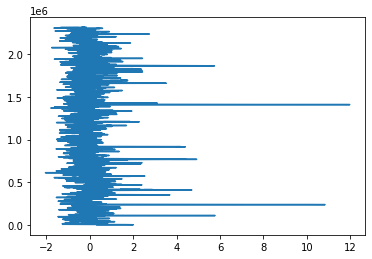

In [225]:
plt.plot(y, x)

In [219]:
df = pd.DataFrame({'starts':x, 'zscores':y})

In [223]:
df[]

,starts,zscores
0,0,0.329975
1,500,0.678548
2,1000,1.044211
3,1500,1.400366
4,2000,2.005256
...,...,...
4630,2315000,-0.964584
4631,2315500,-0.246865
4632,2316000,-0.223826
4633,2316500,-0.363541


In [79]:
def calc_oligo_usage(fasta_files, kmin, kmax):
    """ We calculate the mono-, di-, tri- and tetranucleotide frequencies
        for each sequence, on each strand, and follow Teeling et al. (2004)
        in calculating a corresponding Z-score for each observed
        tetranucleotide frequency, dependent on the mono-, di- and tri-
        nucleotide frequencies for that input sequence.
    """
    # need a list of kmer of length k to analysis
    kmer_list = get_all_possible_kmers('ACGT', kmax, kmax)
    orgs_oligos = {}
    for filename in fasta_files:
        for Id, seq in fasta_parser.parse_fasta(filename):
            N = len(seq)
            org = filename.split('/')[2]
            print(f"Calculating oligonucleotide z-scores for {org}")
            # count mers from kmin (kmax -2) to kmax
            kmer_counts = count_kmers.count_kmers(seq, kmin, kmax)
            # get the expected kmer values from the kmers of length kmax
            # Expected = kmer[:-1] * kmer[1:] / kmer[1:-1]
            kmer_exp = get_expected_higher_markov(kmer_list, kmer_counts)
            # calculate the variance
            # E(C(W)) * (1 - E(C(W))/N), N = len(seq)-k+1
            kmer_var = get_variance(kmer_list, N, kmer_exp)
            # calculate the standard deviation
            # sigma(W) = sqrt(Expected) * (1 - Expected/len(seq) -k + 1))
            kmer_sigma = get_standard_deviation(kmer_var)
            # calculate  the z-scores
            # Z(W) = (C(W) – E(C(W))) / sigma(W)
            kmer_zscr = z_scores(kmer_exp, kmer_counts, kmer_sigma)
            orgs_oligos[org] = kmer_zscr
    return orgs_oligos

In [82]:
calc_oligo_usage(filenames_all, 2, 4)

Calculating oligonucleotide z-scores for Methyloligella
Calculating oligonucleotide z-scores for Xenorhabdus
Calculating oligonucleotide z-scores for Xenorhabdus
Calculating oligonucleotide z-scores for Xenorhabdus
Calculating oligonucleotide z-scores for Xenorhabdus
Calculating oligonucleotide z-scores for Xenorhabdus
Calculating oligonucleotide z-scores for Xenorhabdus
Calculating oligonucleotide z-scores for Xenorhabdus
Calculating oligonucleotide z-scores for Xenorhabdus
Calculating oligonucleotide z-scores for Xenorhabdus
Calculating oligonucleotide z-scores for Xenorhabdus
Calculating oligonucleotide z-scores for Undibacterium
Calculating oligonucleotide z-scores for Undibacterium
Calculating oligonucleotide z-scores for Undibacterium
Calculating oligonucleotide z-scores for Tenuifilum
Calculating oligonucleotide z-scores for Dyadobacter
Calculating oligonucleotide z-scores for Dyadobacter
Calculating oligonucleotide z-scores for Alloactinosynnema
Calculating oligonucleotide z-sc

KeyboardInterrupt: 

In [35]:
list(get_sequence_chunks('ACCAGTGGATTGAGGAGATATAG', 10))

[('ACCAGTGGAT', 0, 10),
 ('CCAGTGGATT', 1, 11),
 ('CAGTGGATTG', 2, 12),
 ('AGTGGATTGA', 3, 13),
 ('GTGGATTGAG', 4, 14),
 ('TGGATTGAGG', 5, 15),
 ('GGATTGAGGA', 6, 16),
 ('GATTGAGGAG', 7, 17),
 ('ATTGAGGAGA', 8, 18),
 ('TTGAGGAGAT', 9, 19),
 ('TGAGGAGATA', 10, 20),
 ('GAGGAGATAT', 11, 21),
 ('AGGAGATATA', 12, 22),
 ('GGAGATATAG', 13, 23)]

In [36]:
list(get_sequence_chunks('ACCAGTGGATTGAGGAGATATAG', 10, 1, False))

[('ACCAGTGGAT', 0, 10), ('TGAGGAGATA', 10, 20)]

In [55]:
chu = list(get_sequence_chunks('ACCAGTGGATTGAGGAGATATAG', 10,  3, as_overlap = True))

In [58]:
chu

[('ACCAGTGGAT', 0, 10),
 ('AGTGGATTGA', 3, 13),
 ('GGATTGAGGA', 6, 16),
 ('TTGAGGAGAT', 9, 19),
 ('AGGAGATATA', 12, 22)]

In [57]:
for d in chu:
    print(d[1])

0
3
6
9
12


In [70]:
def do_calc_oligo_usage_window(sequence, kmin, kmax, window, step, as_rev=False, as_subset=None):
    kmer_list = get_all_possible_kmers('ACGT', kmax, kmax)
    orgs_oligos = defaultdict(dict)
    index = []
    difs = []
    N = len(seq)
    obs = count_kmers.count_kmers(seq, kmin, kmax)
    exp = get_expected_higher_markov(kmer_list, obs)
    ob_exp_ratios = get_obs_exp_ratio(obs, exp, kmer_list)
    chunks = list(get_sequence_chunks(seq, window, step, True))
    for chunk in chunks:
        # starts
        index.append(chunk[1])
        # count mers from kmin (kmax -2) to kmax
        obs_chunk = count_kmers.count_kmers(chunk[0], kmin, kmax)
        # get the expected kmer values from the kmers of length kmax
        # Expected = kmer[:-1] * kmer[1:] / kmer[1:-1]
        exp_chunk = get_expected_higher_markov(kmer_list, obs_chunk)
        # get the observed/expected ratio
        dif_sum = 0
        for kmer in kmer_list:
            o = obs_chunk[kmer]
            e = exp_chunk[kmer]
            r = ob_exp_ratios[kmer]
            if e == 0.0:
                dif_sum += 0.0
            else:
                dif_sum += abs((o/e) - r)
        difs.append(dif_sum)
    z_scores = []
    arr = np.asarray(difs)
    m = np.mean(arr)
    sd = np.std(arr)
    for i, d in enumerate(difs):
        if sd == 0.0:
            z_scores.append(0.0)
        else:
            z = (d - m) / sd
            z_scores.append(z)
    return index, z_scores

In [64]:
for Id, seq in fasta_parser.parse_fasta(filename[0]):
    seq = seq

In [90]:
idxs, z = TDI(seq, 5000, 100, 4)

In [98]:
z_scores[:15], z[:15]

([0.332260433872184,
  0.3440077787139788,
  0.38141846064347024,
  0.43282294208756644,
  0.632819570757309,
  0.6819058779271685,
  0.8453546873388617,
  0.8396195004419552,
  0.8860919281258288,
  0.7959506483496535,
  1.0486939666198185,
  1.1383382901925132,
  1.5488226330544566,
  1.589713336912766,
  1.3752584661296654],
 [0.3771787690307188,
  0.4624910243218016,
  0.4795895300364543,
  0.5254066742371974,
  0.5801549694108172,
  0.6864349957059646,
  0.7457438361940157,
  0.838138849396899,
  0.9061373835239782,
  1.0273745622888046,
  1.1220512390336528,
  1.1771295497468452,
  1.3106107846155837,
  1.5186046279246934,
  1.6107444922558045])

In [96]:
z[:15]

[0.3771787690307188,
 0.4624910243218016,
 0.4795895300364543,
 0.5254066742371974,
 0.5801549694108172,
 0.6864349957059646,
 0.7457438361940157,
 0.838138849396899,
 0.9061373835239782,
 1.0273745622888046,
 1.1220512390336528,
 1.1771295497468452,
 1.3106107846155837,
 1.5186046279246934,
 1.6107444922558045]

In [72]:
starts, z_scores = do_calc_oligo_usage_window(seq, 2, 4, 5000, 100, as_rev=False, as_subset=None)

In [92]:
len(starts), len(z_scores), len(seq)/len(starts)

(23173, 23173, 100.21248867216157)

In [60]:
def get_difference_sum(kmer_counts, kmer_expected, oe_ratios, kmer_list):
    df_sum = 0
    difs = []
    for kmer in kmer_list:
        o = kmer_counts[kmer]
        e = kmer_expected[kmer]
        r = oe_ratios[kmer]
        if e == 0.0:
            dif_sum += 0.0
        else:
            dif_sum += abs((o/e) - r)
        difs.append()
    return difs

In [ ]:
[]

In [ ]:
def signif(x, digits=6):
    if x == 0 or not math.isfinite(x):
        return x
    digits -= math.ceil(math.log10(abs(x)))
    return round(x, digits)

In [2]:
def sequence_chunker(sequence, window_size, step):
    '''
    Return a iterator that yield start position, end position, and a property 
    calculated by a function, as tuple. The analysis is with overlapping windows.
    
    Inputs:
        sequence - a string representing a sequence (DNA/RNA/Protein)
        window_size - a integer representing the length of sequence to be analyzed
                   at each step in the full sequence.
        step - a integer representing the length of oerlapping sequence allowed.
    
    Outputs:
        A tuple:
            start - a number representing the start of the subsequence analyzed.
            end - a number representing the end of the subsequence analyzed.
            seq - string representing the subsequence/chunk
    '''
    seq = sequence.upper()
    
    for start in range(0, len(seq), step):
        end = start + window_size
        if end > len(seq):
            end = len(seq)
        yield start, end, seq[start:end]

In [3]:
def get_all_possible_kmers(alphabet, kmin, kmax):
    """Returns a list of all possible combinations of k-mers of
    length k from a input alphabet.

    Inputs:

        alphabet - a alphabet (strings characters) that compound the string sequence
        kmin - minimum DNA kmer length (int)
        kmax - maximum DNA kmer length (int)

    Outputs:

        kmers - list of all possible combinations of k-mers of length k with length
                between kmin and kmax.

    """
    kmers = [''.join(letters) for n in range(kmin, kmax + 1)
             for letters in product(alphabet, repeat=n)]
    return kmers


In [4]:
def base_stats(sequence, alphabet, as_count=False, as_dict=False):
    """Calculates de frequency or the number of bases in a sequence.
    
    Inputs:
    
        sequence - string representing the sequence
        alphabet - a alphabet (strings characters) that compound the string sequence
        as_count - boolean set as False
        as_dict - boolean set as False
    
    Output:
    
        counts - as default returns a numpy array as frequencies (floats) or
                 as a dictionary-like object
    
    Examples:
    
    > baseFreqs(seq, 'ACGT', as_count = False, asdict = False)
    array([0.25, 0.25, 0.25, 0.25])

    as_count - True, returns a numpy array of counts (integer)
    > baseFreqs('ACGTACGT', 'ACGT', as_count = True, as_dict = False)
    array([2, 2, 2, 2])

    as_dict - True and as_count as default (False) returns a dictionary as bases frequencies (float)
    > baseFreqs('ACGTACGT', 'ACGT', as_count = False, as_dict = True)
    {'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25}

    as_count True and as_dict True, returns a dictionary as base counts (integer)
    > baseFreqs('ACGTACGT', 'ACGT', as_count = True, as_dict = True)
    {'A': 2, 'C': 2, 'G': 2, 'T': 2}
    """
    # make the sequence upper case
    seq = sequence.upper()
    # count all bases in sequence and collect as an array
    counts = np.array([seq.count(i) for i in alphabet])
    # if is onle the counts
    if as_count:
        freqs = counts
    # other wise as frequencies
    else:
        freqs = counts / sum(counts * 1.0)
    # or as a dictionary like object
    if as_dict:
        return dict(zip(alphabet, freqs))
    else:
        return freqs

In [5]:
def get_kmer_counts(sequence, k, as_freq=False):
    kmc = count_kmers.count_kmers(sequence, k, k)
    total = len(sequence) - k + 1
    if as_freq:
        return {k: v/total for k, v in kmc.items()}
    return kmc

In [6]:
def kmer_expected_zero_markov(base_freqs,  kmer_list, seq_len):
    """
    Calculates the 0-order markov given the background nucleotide distribution.
    
    Inputs:
        base_freqs - a dictionary-like obeject mapping the nucleotides to its calculated
                     frequence in a given sequence.
        kmer_list - a list of substrings of length k
        seq_len - a integer representing the length of the original sequence where the
                  calculated bases frequencies came from.
    
    Outputs:
        expected - a dictionary-like obeject mapping the expected kmer values
                   calculated as, (ex = math.pow(A, a)*math.pow(C, c)*math.pow(G, g)\
                   *math.pow(T, t)*(seq_len-k+1), where A,C,G,T are the frequency of each 
                   nucleotide in the genome, a,c,g,t are the number of each nucleotide in the k-mer,
                   and seq_len is the length of the kmer sequence.
    """
    # get kmer length
    k = len(kmer_list[0])
    # create the countainer and it keys from a kmer-list
    expected = defaultdict(float, [(km, 0.0) for km in kmer_list])
    # initiate the variables to receive the base frequencies
    A, C, G, T = base_freqs['A'], base_freqs['C'], base_freqs['G'], base_freqs['T']
    # iterate through each kmer in the list
    for kmer in kmer_list:
        # count the number of bases tha compound the kmer sequence
        a, c, g, t = kmer.count('A'), kmer.count('C'), kmer.count('G'), kmer.count('T')
        # calculates the expected values for taht kmer in the sequence accord to 
        # its base composition and add the value to the respectives keys in the dictionary
        ex = math.pow(A, a) * math.pow(C, c) * math.pow(G, g) * math.pow(T, t) * (seq_len - k + 1)
        expected[kmer] = ex
    # return the results
    return expected

In [7]:
def get_oligo_usage_deviation(kmer_count, expected_zero):
    """
    The normalized value for a word W is calculated by dividing the
    observed counts by the expected counts. This is the usage deviation
    vector for a genome. It is calculated as TUD(kmer) = Observed(kmer)/Expected(kmer).
    
    Input:
        kmer_count - a dictionary mapping the kmers found in a sequence to its counts (Observed).
        expected_zero - a dictionary mapping the kmers to its calculated expected values (Expected).
    
    Ouputs:
        tud_n - a dictionary mapping the kmers to its tetranucleotide usage deviation (TUD).
    """
    # create a list of kmer from the count dictionary
    kmer_list = list(kmer_count.keys())
    # create the keys and the countainer 
    oud = defaultdict(float,[(km, 0.0) for km in kmer_list])
    # for each kmer in the list
    for km in kmer_list:
        # calculate the ratio of observed/expected values
        norm = kmer_count[km]/expected_zero[km]
        # add the values to it respective key
        oud[km] = norm
    # return the result
    return oud

In [8]:
def get_kmers_from_sequence(sequence, kmin, kmax):
    """
    Generate all DNA k-mers over the entirety of a sequence.

    Inputs:

        sequence - string where all kmers will be checked
        kmin: minimum DNA kmer length (int)
        kmax: maximum DNA kmer length (int)

    Output:

        yields all DNA kmers (str) of length kmin to kmax
    """
    limits = range(kmin, kmax + 1)
    seq_range = len(sequence) - kmax + 1
    for i in range(0, seq_range):
        for j in limits:
            yield sequence[i:i + j]

In [9]:
def get_kmer_cnts_from_csv(filename, k):
    """
    Read a csv  file with kmer and counts from a given
    sequence.
    Inputs:
        filename - string representing a path to the csv file.

    Outputs:
        kmer_counts -  a dictionary-like object mapping the kmer
                       of length k to the number of the kmer found/
                       counted in a particular genome.

    """
    # create the dictionary object
    kmer_counts = defaultdict(int)
    # opn the file
    with open(filename, 'r') as file:
        # create a csv reader object
        csv_reader_object = csv.reader(file)
        # iterates through the rows of the csv obj
        for row in csv_reader_object:
            kmer, cnt = row[0], float(row[1])
            # add the kmer and it counts to the counter
            if len(kmer) == k:
                kmer_counts[kmer] = kmer_counts.get(kmer, 0) + int(cnt)
    return kmer_counts

In [10]:
def get_oligo_usage_deviation_zscore(diff_by_window_chunk):
    len_lst = len(diff_by_window_chunk)
    mean = np.mean(diff_by_window_chunk)
    sigma = np.std(diff_by_window_chunk)
    z_scores = [(diff_by_window_chunk[i] - mean) / sigma for i in range(len_lst)]
    return z_scores

In [11]:
def oligo_nucleotide_usage_deviation(sequence, window, step, k):
    #get TUD dict to use in TDI comparison
    seq_len = len(sequence)
    kmer_list = get_all_possible_kmers('ACGT', k, k)
    base_freqs = base_stats(sequence, 'ACGT', as_count=False, as_dict=True)
    obs = get_kmer_counts(sequence, k, as_freq=False)
    exp = kmer_expected_zero_markov(base_freqs,  kmer_list, seq_len)
    tud_norm = get_oligo_usage_deviation(obs, exp)
    # slide along the genome in windows defined by windowSize with steps defined by stepSize
    start = 0
    end = window
    w_idx = []
    diff_by_window = []
    while end < seq_len:
        if end > seq_len:
            end = seq_len
        chunk = sequence[start:end]
        #record list of windows
        w_idx.append((start,end))
        # calculate observed and expected in the window
        # returns a dictionary 
        chunk_len = len(chunk)
        chunk_bases = base_stats(chunk, 'ACGT', as_count=False, as_dict=True)
        obs_chunk = get_kmer_counts(chunk, k, as_freq=False)
        exp_chunk = kmer_expected_zero_markov(chunk_bases,  kmer_list, chunk_len)

        #compute difference sum for all kmers
        diff_sum = 0
        for kmer in obs.keys():
            diff_sum += abs((obs_chunk[kmer] / exp_chunk[kmer]) - tud_norm[kmer])
        diff_by_window.append(diff_sum)
        #slide along the window by step size
        start += step
        end += step
    # compute Z-score   Z=(x-mu)/sigma
    zscores = get_oligo_usage_deviation_zscore(diff_by_window)
    starts = [x for x,y in w_idx]
    return [starts, zscores]

In [12]:
oligo_nucleotide_usage_deviation('ACGCCATGGCAGTAGACAAAGATACA', 10, 3, 4)

[[0, 3, 6, 9, 12, 15],
 [0.19219449398993746,
  -0.8685328799267371,
  -0.6777627051558252,
  2.062375643967532,
  -0.7042300573616043,
  -0.004044495513304963]]

In [13]:
def doKmerCountWindows(sequence, k, window, step, as_freq=False):
    kmerList = get_all_possible_kmers('ACGT', k, k)
    start = 0 
    end = start + window
    data = []
    while end < len(sequence):
        #append data
        chunk = sequence[start:end]
        kmc = get_kmer_counts(chunk, k)
        data.append((kmc, [start,end]))
        # get start and end positions
        start += step
        end += step
    #do one last calc for the last window 
    data.append((get_kmer_counts(sequence[start:end], k),[start,end]))
    return data

In [18]:
for Id, sequence in fasta_parser.parse_fasta('Data/Genomes_splitted/Methyloligella/Chromosomes/GCF_013341275.1_chr.fna.gz'):
    print(Id)
    print(sequence[:100])

GCF_013341275.1_chr
GTGGAACGAGATGCTAGCGGGGACAAAGACACGTGGGCCAAAATCAAAGAGCGGCTTCGCGCAGAACTCGGTGAGGACGTCTATGCAAGCTGGTTCGGCG


In [21]:
guydata = TDI(sequence, 2000, 500, 4)

In [22]:
mydata = oligo_nucleotide_usage_deviation(sequence, 
                                 2000, 
                                 500, 
                                 4)

In [23]:
len(guydata[0]), len(mydata[0])

(6458, 6458)

In [26]:
guydata[1]

[-0.5426206729865142,
 0.558190953758539,
 0.6389386058246707,
 0.3265945744775495,
 1.798853304541096,
 0.36458454506561866,
 0.6659825265906361,
 0.2767199901459472,
 -0.8272555968284808,
 -0.062064684029782755,
 0.09636403346947298,
 -0.49609860070501066,
 0.001214181158507701,
 0.3841486103506344,
 -0.12233556537103685,
 0.7115169374490096,
 -1.2316822358153638,
 -1.3427926603661295,
 0.09414506993813403,
 0.7397616911682668,
 0.6274760704155331,
 0.3720213175503982,
 -0.2551462385209344,
 -0.8928115448299832,
 -1.292750961763341,
 -0.9221358395754783,
 -0.3084346503976786,
 -0.6839791244748982,
 -0.7114490244516833,
 -0.8219958765453262,
 -0.897315356974325,
 -0.3549158426949777,
 0.11602597884599916,
 -0.4071137972110938,
 0.8458591223392888,
 1.928346145162991,
 1.0562972767877021,
 -0.7552733009618057,
 -2.176688327277398,
 -1.0439822699875518,
 -1.3194125121838045,
 -1.3177639012415272,
 -0.2538425562241559,
 -0.573815417954846,
 0.03344095545718967,
 -0.9567837182610661,
 -1.

In [25]:
mydata[1] 

[-0.5426206729865053,
 0.5581909537585446,
 0.6389386058246674,
 0.32659457447755375,
 1.7988533045411081,
 0.36458454506562576,
 0.6659825265906415,
 0.27671999014594567,
 -0.8272555968284819,
 -0.06206468402977406,
 0.09636403346947728,
 -0.49609860070500905,
 0.001214181158519264,
 0.38414861035063863,
 -0.12233556537103102,
 0.711516937449018,
 -1.2316822358153647,
 -1.3427926603661393,
 0.09414506993812677,
 0.7397616911682737,
 0.6274760704155387,
 0.3720213175504009,
 -0.2551462385209458,
 -0.8928115448299785,
 -1.292750961763345,
 -0.9221358395754722,
 -0.3084346503976684,
 -0.6839791244748892,
 -0.7114490244516932,
 -0.8219958765453216,
 -0.8973153569743217,
 -0.35491584269498916,
 0.11602597884599768,
 -0.40711379721109076,
 0.8458591223392856,
 1.9283461451629917,
 1.0562972767877004,
 -0.7552733009618053,
 -2.176688327277403,
 -1.0439822699875514,
 -1.3194125121837983,
 -1.3177639012415208,
 -0.25384255622415436,
 -0.5738154179548357,
 0.03344095545719255,
 -0.9567837182610

In [ ]:
kmer_expected_zero_markov(bases,
                         km_list, 
                          seq_len) == zeroOrderExpected(sequence, 4)

In [ ]:
dif = [87.78817361199994, 92.46259202999997, 79.94927839000002, 88.01420607000003, 89.07867420000011, 91.01217393, 86.31418440999998, 96.4740023899999, 91.72794854200004, 101.26509961100001, 111.66930970999995, 101.84241422000007, 102.97759459, 96.08670146, 105.75222040000001, 103.31758130799997, 98.79093697000002, 92.71483622699998, 103.28100785400002, 117.30328415999999, 105.23998028999999, 96.28281014999993, 82.794860501, 95.13082346999991, 107.284530545, 96.696247598, 97.24133909000005, 95.83767676700003, 85.89344116000001, 89.54957885000006, 93.84044453999998, 99.21841074500006, 112.1385002229999, 128.010195541, 111.38803932000006, 97.820568039, 89.78518435000005, 94.22009095000001, 98.84352941000004, 95.55042090000002, 99.21087461999996, 103.91969098999994, 99.46251009000001, 101.735312347, 98.44564455000001, 104.43477785999998, 95.54133390000005, 99.06211263800007, 89.37735570199999, 89.66188805099999, 91.96643292399996, 90.73608327000001, 98.80422578899997, 97.00170998299998, 105.00689694000008, 101.79866583999988, 107.36332244380004, 109.29988723999998, 96.95046097999992, 91.33995126929996, 87.72828950000007, 89.873647581, 106.30028223000004, 108.1370050699999, 110.80770113000001, 111.29047552000002, 109.07327767000002, 112.42340960000003, 98.61621447540004, 115.00319600000003, 109.742092933, 108.07075623899998, 113.73509863879997, 98.05140037999999, 101.30167596000005, 94.8812680959999, 101.61458081, 105.97746564000002, 105.08095751999997, 108.67665201999992, 111.25235320099996, 117.71615943999993, 105.23959392399998, 90.21518275999999, 84.99695024000006, 76.93114974000001, 82.73546429999998, 95.84655916999999, 94.61411389300001, 98.59582748499996, 102.78954216000004, 113.99066645000005, 109.66771709999998, 101.5588864, 112.30701524, 127.16348975000004, 111.99906777999993, 112.08885744999995, 103.47887812999997, 105.02193936000003, 113.66230742999998, 104.62887125, 123.72448621999986, 131.6961228497001, 123.79505867, 113.03457396699999, 104.33974262999999, 99.14528578100003, 98.72663536999998, 112.99041176999997, 103.45194001600004, 112.17242457, 105.85921058000002, 105.65188999999997, 108.30984443600006, 113.66943940100003, 115.22307486800003, 119.47239653000003, 120.55488025999999, 121.41841703999992, 105.05528574899999, 120.02119055000006, 111.38777834784, 103.08772117999995, 106.18844474999997, 102.82599585000007, 103.19030849999996, 96.7419829, 94.13562896600004, 97.45760775999996, 101.97032679399994, 104.83357056999996, 109.23366674999994, 110.91981480999996, 117.20233827000003, 115.44477219000001, 126.44954199100002, 117.9898450099999, 112.87777200999994, 114.606759648, 107.25633851999997, 101.68948441599997, 106.85766836, 96.08589574999988, 95.2083148499999, 90.027495239, 100.48274202999994, 106.74419793399998, 101.46269297000003, 96.00976503, 112.83582274199999, 109.30671621099997, 121.13202961800005, 121.88320631999996, 110.43278301999999, 103.19499766, 87.736609281, 96.19654408200003, 99.21468966999998, 106.67645865, 98.05587066000002, 97.05453312000004, 90.12873212000001, 98.09619363999995, 103.142599201, 102.00083534000004, 103.05911844999994, 92.78036900000006, 89.68311285999997, 84.64259059999992, 89.02145682000003, 97.50329266400009, 94.33614755000002, 95.81997733999998, 98.67416933999996, 90.03832849999996, 90.48759213999999, 94.33213532999999, 102.64562461999992, 107.78542630999999, 111.01440068000007, 112.28535561999998, 101.82084457400006, 108.92210782000002, 106.89787519, 100.50088401000004, 94.71405109999995, 93.59956749999995, 92.378042382, 91.04619649999997, 92.15146680999997, 79.682980876, 81.31602935000004, 88.75207488199992, 93.26824204599997, 95.14471178500011, 93.80873076999995, 101.87693087000002, 102.11294965000006, 98.06703729499995, 94.58257701000005, 92.35869794999999, 97.78333848000004, 103.34258137999998, 104.59666964000003, 93.90300979739999, 91.76264833199988, 100.00159766999998, 108.15945561300008, 108.72114836000007, 101.42512797900008, 97.98878991999987, 100.057925798, 100.20540710000012, 86.19280115000002, 85.45613489000002, 91.14792381999997, 98.34512451999998, 95.87150431999996, 95.62189433999998, 91.05407117000003, 88.60604822799999, 93.69628644399997, 93.8616690399999, 106.61667035700002, 114.18183159000004, 111.63295710999995, 114.758531792, 112.81248397999998, 117.19874834, 113.52328544000004, 120.87518085000009, 122.066444691, 136.22751830599987, 139.04440302399993, 137.73881198000004, 137.2600511299999, 132.85066543600004, 125.78248293699997, 124.81144627000002, 123.02020208999996, 115.10579374700005, 110.71541040999998, 111.2272346, 117.96472606999998, 107.58188297999997, 106.88238446000001, 109.19048466999999, 109.98331843999995, 116.10672498000005, 103.07896615, 109.75909688, 97.86731873999999, 92.1980440399999, 85.05804940100002, 82.93641172, 79.42284108999996, 86.56737992900003, 104.44624035999996, 109.61289970600001, 113.75629788099995, 116.45721991000003, 115.65177872700002, 122.91586626000002, 115.66378270000004, 102.52851520999995, 87.89716701999994, 85.74114660000002, 88.31256114, 108.59425340000001, 111.40056296499995, 112.271131077, 111.2265288, 112.01571736000002, 117.44676514999998, 120.66000367999997, 117.30421131999994, 115.13695611999997, 110.00052664799998, 93.657801326, 97.34398077, 92.00167852999999, 97.81974176999998, 102.294033174, 101.84079494999995, 92.923758455, 101.0208174295999, 88.21162241500002, 84.39289828999998, 85.71967057999997, 82.24491945999998, 90.4230975923999, 91.77359568999996, 87.43390242000005, 87.54947595999997, 85.43739937850002, 88.75560769000012, 100.22044980000001, 110.46453827599998, 106.27330980639998, 102.38603556699995, 109.25753049399997, 101.19808927999993, 108.27454637500003, 106.72111933999996, 110.66441926999994, 109.40684743000003, 107.54543926000002, 110.63787518600004, 117.54251347199997, 103.41464504000001, 98.00477739000004, 90.89068922999998, 91.71006430000003, 100.41230370999997, 107.74401956000003, 105.77680391999996, 98.35347659999998, 98.22947480999997, 105.01203850100002, 104.87596476, 106.78467626399996, 92.80389806999996, 95.67005014500005, 103.59273110000007, 99.14141230000001, 112.31015380000001, 106.472952445, 105.61224132099996, 101.64167216000001, 95.74174359520005, 93.01076912499995, 97.26047494999996, 107.05284184999995, 111.07376273799993, 105.98408057, 111.22935622099993, 119.07791709000003, 125.16758506900005, 123.0873653, 121.89487879999999, 121.51240108000003, 114.29466412999997, 114.32056530000007, 127.66846059999989, 122.24310445999994, 123.95784056199996, 122.17848849499995, 113.61751171000006, 112.9075816, 102.88880941999994, 107.50145764999998, 93.72397564000003, 88.61580751000001, 89.89354253000003, 100.80748695499999, 108.74909406199995, 105.10597644999999, 97.49332236, 96.85202761000002, 130.83133022999996, 122.58087286399994, 122.77056135999999, 94.41897247000003, 93.89385595599998, 110.46070591000002, 115.4196635599999, 113.45496046000004, 104.73900478000006, 113.89669105000003, 103.16996732999999, 103.46914869000004, 106.48020743999997, 96.76415563999997, 96.45773504010002, 100.86152989000001, 104.31157218999998, 105.75383766700001, 117.00845109999995, 125.9759632500001, 144.71371097999995, 140.85971608599996, 135.8028296, 127.74948935799998, 110.66481008000002, 97.17899240980002, 96.87669060200001, 96.95778406000001, 90.15358415999991, 98.03835505999999, 105.90173991, 91.63513363999999, 93.07873838400002, 80.38879153399999, 89.13283798999997, 102.41437731700002, 110.46745241000006, 110.77133238000002, 122.24866307000005, 128.61182537599998, 101.87232580000001, 99.97982504000001, 85.75700378999996, 87.54571169, 88.50206637999999, 94.05209444499998, 91.16183617999994, 90.53641056200006, 86.62223033000004, 83.306270423, 110.16180013000009, 116.90023721099998, 98.40820792000002, 94.76287271999989, 103.08728484999995, 111.93332653400006, 115.85787461000004, 101.21097517000007, 108.12926649000006, 118.93069137, 116.26018060999996, 112.72134969999993, 104.46656223, 99.082133492, 98.67847720199998, 98.3715694200001, 103.30311129999996, 107.11684742, 119.68296657999998, 114.31855935000004, 121.37449128000002, 116.69511042400005, 113.68444754000004, 113.81225034000003, 108.65316110500001, 109.8766940569999, 108.45118081000005, 105.55253592999999, 106.17295389999995, 97.07744364700007, 101.45327954000001, 101.13594309, 109.56458991399995, 111.05412710999998, 117.51004743200006, 124.3585035099999, 127.53946817299996, 127.02718991999996, 126.04831874000001, 111.99429664999997, 101.52201440500001, 90.95820113999999, 104.81355127899997, 103.57002130999996, 107.08196906000005, 101.291593574, 87.33497114200001, 83.53976711799999, 84.14232189999998, 85.65857073000004, 97.90396892000008, 109.99162913800005, 106.54637415000009, 107.68975513000001, 113.26975105500004, 105.272788686, 95.17400304400005, 96.56503483999995, 97.31779322000004, 96.01896814999996, 103.62725816000001, 122.73066965600005, 117.416024744, 120.61128094999995, 116.95879440999997, 114.02312410999997, 116.7472349, 108.01367061, 110.87281454999997, 110.68327918200009, 107.27360286399993, 102.83765385999996, 101.71348657400003, 108.896837677, 97.15146576000002, 102.00174862, 111.14048984000001, 123.74215623509998, 120.88081034000002, 123.45636195999995, 128.64127684999985, 108.99204685800002, 97.43824017999998, 101.75534545000002, 101.11613709499998, 98.90785241999997, 102.43339219999996, 98.15154820999994, 95.36557441800001, 102.53214795000002, 104.21596313999993, 106.83107949999993, 118.98029435999999, 111.26659695799998, 109.95612102, 110.27824828, 104.48527397700002, 92.11937474000003, 83.35420303000006, 89.48217869999999, 88.83071320899997, 94.66306526999999, 103.24573927000004, 109.11303316000003, 110.14907347000002, 101.64475562, 118.21073996999999, 110.379903946, 108.67677194699995, 116.57509270000001, 112.47245374999987, 99.82286591000003, 98.435535977, 99.48763115999995, 89.37636510099992, 92.58833244299996, 92.66215535999997, 95.51777391, 96.68546637199996, 91.04109731599999, 93.90782635999997, 92.36120133199994, 92.20500517, 96.93662163000005, 88.80293743190002, 87.22396893300001, 89.485444314, 87.56902845000005, 87.16000255000006, 89.64500818279998, 109.23118979999997, 103.63169186999995, 99.62397402, 104.93830695749992, 105.569930935, 103.34839459999993, 103.12104170999997, 104.74855609999996, 100.47811143, 95.17650594, 92.06827753000005, 105.38677846000003, 105.09760742999998, 110.40291193999991, 104.04926503000004, 96.17324569999995, 94.03725741999995, 87.23884841899999, 94.67265001800003, 95.48743422999999, 103.54530370699996, 91.337940495, 94.66501926000001, 103.56339648299999, 114.12573984999993, 130.34865193, 106.83892882, 106.17255590600003, 110.92714861999991, 109.57690361599997, 105.67879417999991, 91.78203697000002, 95.84395031999999, 110.04626918300002, 105.69154471499994, 103.55820001800004, 101.81165819000003, 100.84226027, 98.69391719000006, 94.616687978, 103.58406280800003, 98.5204906, 106.84808484300001, 114.90865139999991, 110.70474808999995, 106.749507425, 112.64536174999996, 108.71010273999995, 118.98759816000003, 116.0549127899999, 115.43006429, 126.33973866000004, 115.19898663999999, 120.93474678999996, 132.93187467999996, 117.63846205999988, 108.21505010300001, 104.86125331000001, 103.63767429999993, 107.54874075999999, 98.74305340999997, 87.99990787, 101.06032272000006, 111.09490368999997, 111.18873021200004, 133.91778154000002, 154.67290087999996, 146.98517444499996, 129.81688189999994, 126.60085466100003, 118.74563166999997, 128.38468941000002, 124.09162508999994, 102.21687965999999, 94.40351925000003, 93.91307495000001, 94.36196068, 91.84437648599999, 103.19799507000002, 108.9640273299999, 106.700221459, 105.43502655399992, 90.58341303000002, 97.63849410999994, 98.25439856999996, 97.37487171299999, 115.72864477200004, 110.30211246999998, 103.94566180500004, 91.77820670999998, 88.84122151999998, 96.78070198000006, 97.39615710400003, 90.416604909, 83.45614811400004, 89.525882473, 87.06024850199998, 85.84245811200005, 88.40501591900009, 86.99429273199996, 99.49732223999995, 101.63938059099996, 103.64104517, 112.20454190499996, 95.65517962, 96.421447477, 103.09114704999996, 103.6254020693999, 99.23926960500005, 99.5319831, 99.17680258999997, 106.51446949999999, 109.76636932, 121.22082692999997, 112.70004989999994, 105.23850262000002, 94.07125456999994, 82.78475405999995, 92.81924645999999, 83.71923476999997, 86.76513420999999, 95.54883587, 98.96720105273997, 107.26324477000001, 109.89273739800002, 110.09608613999998, 100.95668991000002, 95.792816313, 90.28354380999997, 93.97925291000003, 98.42124601999996, 98.13127106000003, 116.6187819, 111.97603996, 111.65249011, 111.28359815999997, 109.81375261999999, 107.932306596, 110.52553236999992, 120.30023449000002, 108.96872516900004, 105.59060311999998, 99.37335728, 106.18801407000007, 117.24111864999988, 114.18640208800002, 119.331828107, 122.31782238999996, 130.86306075899995, 138.58252774000007, 133.57728597, 132.98913660999997, 123.13402511000004, 142.5568768599999, 138.48876765399993, 137.012395858, 135.03489478999995, 126.77698781000001, 113.71770789999992, 109.26469720599998, 114.96436333999992, 123.69497219999994, 136.73071105400004, 135.04993763999988, 128.78792609999996, 125.55962524999997, 124.18721790999989, 124.86016696999998, 127.55600106599995, 128.804260923, 115.66826222000002, 123.43283182999997, 121.9814590199999, 114.74129432999999, 129.8665250900001, 123.71814977, 136.9208194, 133.774252397, 138.9260469300001, 150.60798070000004, 165.93431620999988, 134.43128689999986, 123.72086793999993, 120.48754640400001, 124.69992911899995, 136.48195515999996, 119.15290943999995, 105.84504195999997, 106.86683728999994, 112.32620084039995, 122.41290500999997, 129.38694202999994, 136.57352309, 133.21237797000006, 131.5771898300001, 124.21331728000001, 112.22388746000004, 110.20539845999996, 120.20581185100006, 118.67578416000002, 113.60230033999997, 98.81450270999999, 88.80801031699997, 94.50154855999995, 123.90897570000001, 135.80936931000005, 133.69062334, 129.73066655000002, 124.39359896, 125.38558151999992, 122.06940046, 120.99026150000007, 125.17389657999995, 120.57879621000001, 119.18256672999998, 120.72341668999997, 120.1615296, 144.10066462999998, 130.89050718599998, 143.01660270000005, 135.95522558, 117.40526707999996, 122.1753370799999, 118.22280813999998, 129.1689068, 140.316142407, 145.5485435119999, 136.5708817789999, 121.31837829999994, 107.61840126999999, 99.70076851000002, 110.56783304699997, 113.18138364899995, 113.55238913139996, 109.85512496000001, 102.99744696000003, 104.84293834099991, 98.53635259699998, 114.78783201999998, 132.34252748100002, 130.19822846999998, 136.5898871300001, 142.99800875000005, 126.66543657999995, 128.3131704399999, 127.37251675999993, 138.67381903, 138.90903154000003, 115.73516524999991, 114.58560319999997, 115.60564681999999, 131.66847640000003, 134.07627556999995, 130.67779166799997, 136.031085227, 126.68075898000001, 123.66605531000005, 147.68936241000006, 138.13185764999992, 134.0462387499999, 141.93213238899997, 119.67743560999996, 114.55204421199998, 106.09336918999998, 113.34569973000002, 115.80146857500002, 109.18102759000003, 109.38417850590005, 109.38782515000003, 106.41155718999995, 116.36501036999992, 117.04522443, 121.15914025999996, 123.57871706, 132.05127958, 125.74199959000002, 98.69601746999996, 108.35192877200004, 112.21491685999999, 118.0799463199999, 115.7438162799999, 115.45141964600005, 106.55392738200001, 108.65023152999993, 92.96682986999997, 97.19914248600003, 106.83503391999999, 104.41300865, 101.96380745000002, 103.16201868400007, 111.61992267999997, 119.21037992000002, 104.96829268599993, 104.55156614199996, 101.30348303999995, 108.97172481999995, 97.73083554000003, 104.15327726599996, 85.33980831000007, 88.45229469000004, 90.46785922700006, 103.17775187000007, 113.14379983999999, 121.66373324000001, 119.29920791000002, 111.833322, 117.96757239000002, 114.54219148000003, 101.24870169899991, 96.51505058999994, 95.41506903999999, 98.47579856000006, 101.54298034999997, 99.68113998799993, 109.19313164699999, 97.40094178999998, 96.51669533739995, 98.19944146899999, 102.49348295, 109.19895697599999, 96.96085134799996, 100.288997966, 100.20675051999996, 102.61568310999995, 93.545429644, 97.86850606999998, 104.07438119000001, 102.16005392999999, 104.85207602299998, 98.61804375839999, 95.16768815999997, 98.97769899, 97.74992575999997, 92.56205692999998, 86.35336464600002, 90.61347987069992, 88.49242659000004, 95.05781827000003, 94.075035933, 108.78895909000002, 123.8340975300001, 126.46744613300001, 116.99226215000003, 106.51071741899995, 91.19187961700001, 89.86889072000001, 92.91331369000004, 93.79075101, 95.22401729700002, 92.29997029000005, 106.5169105330999, 111.15530005300003, 109.69294415299997, 100.83763598000009, 99.23468281130009, 81.47059961000005, 84.52048373000001, 85.63358208099997, 84.02798473999998, 88.71050551000002, 92.75168886000006, 96.68720991999997, 95.6565871499999, 95.92020673600001, 91.66190713, 95.54612527999986, 99.914569526, 114.24691605999996, 129.29502540000001, 151.5518408600001, 141.86912761599996, 128.096794248, 111.80106720999993, 95.09956390100001, 89.30386787000005, 98.84600301399995, 93.68107859500005, 96.98345015100003, 99.99990114599997, 101.86324336999998, 99.97864854899997, 99.97417029999995, 100.39801034899999, 102.09115411000006, 103.56942230199996, 97.938147529, 92.32909312300004, 92.06219841399998, 83.75105455899997, 89.603007588, 90.32465452999998, 90.671701628, 88.95651582999999, 89.62194563999999, 97.07810733800001, 90.97944856999995, 93.58319155, 98.28929528600001, 96.26506813700004, 102.92801899900003, 99.27321867999999, 99.036047582, 96.612249275, 96.011681001, 93.72150894999997, 94.73154852999997, 94.74707426000003, 92.4771691, 92.68798179000001, 92.11097292999999, 97.97724876000004, 99.81635700000004, 105.74369399999996, 109.70516868000001, 104.72507174999997, 95.63888958000001, 100.26734243, 93.64972486999997, 94.44840236999998, 99.06283824, 93.57900619999992, 93.29448042899996, 89.89411137000005, 84.29579411, 85.3238474375, 83.96537242, 87.59894567000006, 90.50904241999999, 93.27848266799998, 95.01840815400004, 92.37917490000001, 96.66983386999995, 97.86845188700002, 101.40296233999995, 102.88913031999994, 93.99076416, 97.42877073000001, 101.87255255000001, 91.98014106, 92.35474517200001, 98.691139606, 101.21537687, 106.02507797000004, 100.59617689999997, 97.9273009279999, 100.43586872999998, 98.23633921, 95.93566649200001, 93.13342008000004, 90.12229490000004, 88.08202891, 87.78734015999999, 89.81263449699999, 94.46767346999997, 91.91919315699997, 89.239169591, 86.66847418699993, 91.35123422199996, 92.95465289999994, 93.09058432399998, 88.97560853999998, 95.59344475000005, 102.33372018599997, 106.73936296000007, 106.94403911399996, 121.974725111, 122.10944106000007, 123.98350880000001, 115.81361850000002, 104.05479136000001, 102.27963700500001, 94.37781433999996, 87.73322663500002, 102.07569250999994, 119.43915862999992, 111.63115649999996, 107.63525511999998, 102.50797365999998, 96.49278679599998, 91.75523611999999, 85.56500607900004, 96.856754678, 104.04587226999998, 113.03825751, 104.34057167999993, 103.44258359999996, 103.8022739799999, 100.19933070400005, 97.732328721, 97.66111865410001, 103.90050618499994, 102.09538306999995, 92.73662503999999, 90.75368095000002, 91.41672978099996, 93.605919818, 101.34762697599996, 105.17515119899997, 112.54010069000005, 103.15935625000004, 111.60966374999998, 103.90825164000005, 96.18766687799997, 104.39437740999999, 100.67283403800005, 107.14637824999996, 102.21774328999996, 106.52670413, 115.02736174489999, 111.20895870999996, 113.68571788999998, 111.87681422849998, 115.61158867700004, 122.36651018800003, 136.75025438999995, 145.97189995, 138.86449757000005, 119.24233873999998, 110.06234799890005, 102.26753677, 107.283904007, 120.01509609600001, 127.17730734999996, 119.67168231, 119.62717408999998, 129.0126796725, 116.64578959000004, 103.26148312500004, 91.75098290400011, 100.98322360600005, 94.42094090999998, 117.17220796000005, 121.66681500999994, 141.80174606, 133.61065902599992, 116.82846872160009, 100.72610487999998, 96.39226788999999, 93.78828307000005, 98.97762928999994, 116.449500938, 106.04035484000005, 99.27317272000002, 88.23250523600002, 92.01113929700008, 94.03788555630001, 97.64825280529998, 93.85600323000003, 91.63353390599994, 89.46294818999995, 91.04050136100005, 91.78150486000003, 85.02559477500002, 86.15359283000002, 91.38598030999998, 98.04260853000002, 98.00554475, 93.46258378999997, 92.49159769209999, 91.96479005500004, 90.11203768049998, 90.85535555100005, 91.67316249850003, 92.23686402999998, 103.61753959999992, 95.99690563699997, 92.838025094, 95.43836674999999, 118.15149481999998, 116.95856794400007, 107.00908499, 121.40956154999995, 103.84492995500007, 91.70782439, 81.63517644730004, 86.58007492000004, 83.98671704000004, 84.01461625839997, 82.62467365999994, 80.51824040700001, 84.88060485000007, 78.63151318000006, 85.80956841199999, 91.42935191999997, 96.25892486, 95.64826257300001, 97.14800075000001, 102.97478522999992, 97.42102205100007, 92.42346483800002, 88.98121577000003, 90.83033668000003, 96.87994175000004, 100.31188773549994, 110.79058566679998, 112.52934892000002, 106.17737078000006, 97.47705968, 100.71581359999988, 97.11072445999997, 94.33221490699997, 94.18977194999998, 100.88663949000002, 102.40251467099996, 100.54416671999996, 94.34943256, 89.98218128000002, 94.52066046000003, 92.84496195000004, 92.01694763999994, 86.69884347000001, 81.09524177999997, 82.36164758, 79.57329377299993, 78.60750089899994, 75.93227225000004, 83.02210916200008, 85.73462627451002, 94.21408903, 96.54868936000003, 89.99448571999997, 89.85253594, 91.35699711299998, 85.44188915, 97.57152757999998, 104.51117374200004, 113.80017175100004, 120.33043537400003, 100.21853956599993, 97.43525370000005, 97.27480799000004, 97.78105446699995, 107.78200122999996, 113.53760866100002, 104.08117578000004, 101.93324605999999, 90.77421244999996, 82.05207947999995, 80.10269337999998, 90.15797497999995, 93.82829672999995, 92.68415125999994, 89.91226755999998, 88.3854292796, 91.95942663900003, 104.26062195499999, 98.85298978400003, 100.43109776999991, 96.07792797999994, 95.24350831048994, 88.33661970999994, 88.78765101999996, 95.43505718, 121.86678325239991, 139.25725291, 159.6780373000002, 138.27002801, 131.06109712000003, 114.53508910700012, 104.50123753000005, 97.55143604999998, 97.07609130099998, 103.27730343999995, 108.25394527999993, 117.14219177999996, 109.54877535999998, 112.38216793999996, 103.99341814000005, 88.715773804, 74.17303262399999, 80.01517125299996, 89.335736749, 94.36840651499995, 105.74327034999995, 97.62865596720005, 106.11623202, 111.41358739999995, 117.11369203999996, 117.38066300000001, 107.86867981, 98.07760447999999, 96.976425594, 98.91169435099998, 92.17069615000004, 82.32713896999996, 96.25586727, 108.23391894999997, 109.53901835199987, 105.95596000999997, 100.30128923999996, 90.4619445, 87.937987023, 91.92857356000003, 94.64626393610003, 112.09078821499999, 120.35438954799997, 119.23033403699998, 122.80945622999995, 110.55601015499994, 103.30290546300002, 106.51934641999998, 103.513434146, 100.18864224599999, 98.57233470000003, 105.48513401000002, 113.83992294999997, 119.77889273000001, 110.52208295000004, 100.62696484999991, 105.20875136999993, 107.12432795, 99.48072027000003, 113.12404363399999, 99.38013222999999, 100.69128139900002, 106.34241659699998, 98.25726935300007, 97.40857907, 107.76888099400003, 111.75229502200004, 108.97114577800006, 105.14094499299999, 113.57261013500002, 119.58863103999988, 111.77818089500002, 103.18152268300001, 99.76432263999997, 103.18925440000004, 99.55595904999991, 102.10422471000008, 94.77106869300007, 107.84552472299995, 113.25521600999993, 105.79598822, 100.5427514395, 97.54826063999995, 106.10459686000003, 108.23324036, 110.73121355, 107.24065518000002, 106.53639389999998, 101.14810768999992, 101.26733048799997, 103.65448922599991, 96.11258262999998, 98.98671479999996, 94.62089789999995, 94.82581490000001, 100.25520382299996, 95.92847260000005, 90.45349450200001, 93.75762346999998, 90.14792050999996, 90.85314243859992, 88.89906265000008, 90.228295645, 92.77495532, 92.37637189000003, 101.51276774859997, 103.57105481999994, 96.250927732, 94.76534722999995, 98.59640905000002, 107.87412491000008, 111.56094116300005, 118.21865808800001, 115.62832272000003, 130.29632880000003, 113.01311294700004, 120.08003670899997, 105.40433760000003, 101.0118973, 116.68461366, 113.46392393000004, 110.87570361999994, 113.2149155, 117.41638234999998, 122.19252587, 125.43145074, 122.66115524, 122.41597925000002, 117.230148689, 106.93809608999997, 122.12200274399996, 130.59231761600003, 135.05296029000002, 134.18971777099998, 110.34062982, 114.14045916000005, 102.67716218399998, 91.33782340999997, 92.85480034400005, 92.05555628999996, 103.99895843999994, 102.85345711999996, 106.77676586799998, 98.95886307999994, 104.24438713800004, 104.64729381500005, 95.85270825000006, 97.16676412599998, 98.54538952999997, 98.6486372719999, 95.81386130000004, 91.15565749999998, 92.22672223999999, 90.70700849789999, 89.13117632200006, 89.73309103000001, 91.28491928100003, 100.52399013999998, 101.42915155999997, 109.38603546999995, 113.24454018000004, 116.847195478, 125.73184682899993, 126.74155946259997, 124.96300630099995, 128.34371950999997, 118.39104642999989, 120.27183616999997, 124.15635298999997, 118.21213544000007, 139.77823106540006, 137.17524072999996, 140.24148223, 119.4162923, 107.51692113399996, 94.16853016999997, 96.59153569000007, 109.22162524000004, 130.20149306000002, 143.872588, 143.07868553000012, 139.78843705000003, 118.12188586300006, 116.718603862, 117.67612517800009, 130.68558352000002, 138.82109618700005, 139.78728349100012, 142.5855246, 143.4999976800001, 165.25024643, 153.53972236999996, 149.51537126999995, 149.90639613999997, 126.98281420999996, 121.75658033799999, 119.79292840999994, 117.62682704999995, 114.18044889999999, 110.34731627000002, 117.72621403, 115.50178583999995, 117.1180019, 112.71065854799998, 115.75592800999996, 122.16757205000005, 115.42331446269999, 113.0189561200001, 114.14576552999999, 116.10829473500003, 118.93418113999999, 120.22154418000001, 121.46730335499993, 114.83823331349997, 115.99858729700003, 116.81610686000008, 111.94770350999997, 111.47216670000002, 118.87179801099994, 124.3665056399999, 114.49283611000001, 113.48308134000003, 126.48035304999999, 123.946950631, 132.41778858799995, 116.32090831099995, 110.68905473000001, 108.06959086999993, 115.48008172000003, 114.28602600999997, 111.521822237, 113.54950361999998, 97.65558267, 113.76741229999993, 126.23268924999999, 134.51297576600007, 125.34158729000004, 110.22707909000006, 95.70063821000005, 99.11194495999995, 121.79802917, 146.9862351799999, 173.14586317000007, 173.97149950000008, 165.10835300000008, 145.82033582000003, 150.53594090999988, 149.4593917, 143.7105198260001, 125.46669413599997, 107.10339060999999, 91.75896992000006, 90.85057045, 97.65615951999996, 105.6849108, 107.22974665999996, 112.99391346300001, 102.04183644400001, 102.7527487, 115.46080448300003, 123.94733770900005, 129.77962850999995, 124.44491925, 101.28501517999999, 102.92059644700002, 118.21394527999998, 129.6096967635, 128.75657218999999, 127.96767088000001, 118.21718788, 121.25819152700002, 129.79796898999996, 150.26437656000002, 143.81180941, 138.79316655000002, 131.89702517999996, 119.37439984999989, 117.14265977999997, 102.47597517799991, 108.12671234999993, 107.71826702000007, 129.81779698999995, 117.44792599999998, 118.63229734199999, 118.70773850999996, 109.16902831000004, 107.49302789999999, 106.39713726199999, 102.66143894000001, 99.16734586300005, 91.93378100100003, 90.50638546000002, 107.523719025, 111.59045496999997, 113.64578945999999, 117.90798992, 112.21250021000003, 116.38654771999992, 118.97404075659999, 116.09033633399997, 137.15876395, 147.89586179999998, 147.53144505, 151.51744653999987, 159.58648252999993, 150.89598737999995, 131.2759434, 128.9825151599999, 120.43872038100007, 99.80667169100002, 98.70047974999997, 102.62548250000002, 94.70950095999999, 95.74315090000005, 116.46654839319996, 124.36498167000003, 125.83561669000001, 121.86764519169992, 116.14503928, 120.890614842, 130.45336291, 127.94179253999997, 121.40987285500007, 122.24850440999998, 124.19399579999998, 113.24483242040004, 100.69989278999995, 96.98838910930003, 106.88417539999996, 108.90771491, 105.98586481999997, 104.55533308000004, 102.98527332, 121.9859183671, 128.04306406, 134.7107947899999, 153.02440620300004, 155.7735771600001, 151.19953930999998, 122.75867137000009, 106.59262880999997, 92.15566046300009, 108.47547931700001, 118.80078787000004, 106.01124855139993, 110.381286359, 118.42976955000005, 113.21048817, 100.03918136199998, 98.925618182, 98.56015135299997, 107.30308067000001, 96.60652857000004, 91.29353345000006, 94.48198863999998, 100.66036231, 104.40515022000007, 103.59891771870001, 105.56096423499996, 111.55427966999997, 129.43637763999993, 128.35876515000004, 115.29207609999999, 106.42497005999995, 100.03507888300001, 102.02819031599999, 108.53786996349997, 129.48401556, 121.74869517900001, 123.99918184999993, 127.2950031, 107.427009685, 97.96559151900004, 96.58706115000005, 101.22169071000009, 96.89853809999991, 91.00835601720001, 95.32936818000002, 104.5270475, 101.24180088800001, 112.87778950999997, 132.55746366999992, 135.41065548900005, 134.36079360000005, 119.07848868799998, 109.818120794, 100.89419706470004, 101.7296614967, 105.97956971299999, 109.05519870000002, 115.23558263999995, 114.45903815999995, 117.59869017600002, 108.67324973200002, 92.08248800999999, 88.12300036099997, 95.14065892, 102.56894348000002, 108.93732136999984, 102.69825706999994, 126.14513061819999, 130.07648022900005, 129.24386201000004, 110.06157760299995, 94.43349460000002, 83.93349172, 91.15412130000006, 89.10517225499999, 89.44734175999999, 99.99283658999991, 104.00017137999997, 104.42387234, 101.58174349000001, 87.16950471000004, 90.347395385, 106.96136228999995, 126.25429257299999, 123.95900047, 106.11452172999995, 104.07896495000004, 121.40304572950002, 136.7666019200001, 129.070522332, 117.75927511999996, 94.16258574600003, 87.75138672499999, 91.64281801, 100.85629369999997, 107.33923655, 116.83896057999995, 125.26430460000002, 114.21004432099994, 116.42654943499998, 110.5371328999999, 118.738518458, 133.1693559, 138.17309535000007, 133.24375379999995, 118.63375774, 109.10282445099998, 111.53179264100002, 124.58553687000001, 134.70992016, 136.99889768999995, 150.21102933199992, 144.44473269, 127.46272375999999, 114.92155950000003, 91.95064621299994, 93.84828313, 105.07031293699998, 105.96678527000012, 105.71026279099998, 90.98021548000006, 94.24185258000006, 97.00346725, 96.86290955799997, 99.22151506999995, 97.39949017999993, 93.662212445, 91.61104288999995, 93.68223360800003, 97.68177531699997, 86.30764877189998, 82.88939465000001, 84.62056487499996, 88.91751462100002, 95.02256540999998, 108.99892172899995, 112.85394358000005, 132.5241837300001, 134.88506070499986, 146.29281388800004, 137.59147310499992, 136.76399507000008, 135.46930038000002, 124.81165273999997, 118.64303713999999, 96.549317833, 84.20192370999997, 87.15354625500004, 99.89369414000001, 101.11106450999998, 114.89438838330005, 108.12662090300007, 109.20026855099997, 112.14402609400004, 113.36070787999998, 109.98045133000004, 117.529906767, 110.93913414, 104.03594892999992, 97.72369860199996, 95.60551595000011, 117.85433527999993, 118.79456622000001, 96.54366382999997, 98.24019584999996, 103.24895447000003, 120.82768211, 122.59682118, 126.87424629000003, 132.95482056, 114.09375359000003, 118.48592340000008, 109.11983974200004, 97.77485697999997, 93.13775151399997, 80.42975519900007, 79.31386230200005, 81.36779183000003, 83.72988485999998, 87.67744997999996, 91.50072490999996, 89.19317250999998, 96.78471728999996, 95.09807147999996, 99.36822422, 102.47025334100002, 102.513551094, 103.97966709200001, 108.95282440000003, 115.53577261000005, 117.78729671999996, 119.24139528399996, 133.26299367000001, 126.00332443999994, 127.55543276999998, 119.78614230999996, 122.69568356999994, 122.03504475999999, 105.85840215930006, 105.55192053000005, 103.10821699599992, 99.2771971400001, 96.46309581999999, 93.82234901000002, 99.92051974000002, 95.40175737999994, 83.66612571999997, 97.66115842999994, 98.75424616000006, 105.61847437659996, 106.535692346, 111.30154387999994, 102.04934636999998, 101.88134556000001, 105.165325921, 103.169053005, 97.72290815000001, 98.95160053999996, 96.90106327199999, 96.14854845999993, 99.03126703000005, 97.45572683999995, 106.08642085, 103.08196162, 110.986728929, 112.29299375800004, 99.86279400000001, 100.25345702499997, 102.116396957, 101.25685288, 108.94621153999996, 116.10077812999998, 115.73855984799998, 106.96930794000001, 105.2980757630001, 100.96762263000004, 101.42112967999999, 102.53279258500007, 97.82617416399992, 103.05345568000004, 95.46700450599995, 93.3664392800001, 100.88028310000004, 104.64883315000003, 105.12682921000001, 107.12195814, 100.28996605000005, 102.35531517, 110.72942681999997, 100.04489241999994, 103.37966499, 94.94960588539999, 95.68460771800004, 91.09597649, 88.31801713700004, 89.59664444500004, 89.74825541600003, 97.90705961000003, 94.07260937, 92.64433200200003, 95.04948304000004, 85.76954946999999, 88.46899179000005, 97.94235528900003, 97.54259505199998, 93.96555819099997, 99.01038242199992, 102.29170261, 114.09470539000003, 112.9590091800001, 114.26797386399994, 111.33511758000006, 112.44611173999995, 118.20194806000005, 112.07244796399996, 111.79949549999998, 121.38107295000005, 123.34728222999989, 117.28082039000009, 113.96341673800002, 113.50777568200004, 131.48048490999992, 120.23096469, 117.41795396899994, 115.01607024999997, 111.09164019000002, 121.54530587420005, 127.11830290999998, 125.81866103000009, 96.59015883, 98.10003628999996, 87.82518882999995, 82.68443779000002, 95.00944570999997, 95.34985125999995, 92.36158017830003, 104.53862111499994, 101.45502761999998, 95.42432378200002, 97.83434524999994, 101.68767852000008, 105.50415727999996, 102.23817486700003, 96.89550021999995, 97.66626397900002, 93.55511878999995, 94.02824261899998, 107.32661217790003, 125.30137345299995, 114.88278442599989, 97.92761694000008, 85.48932624000005, 85.54956829999995, 97.71893122000002, 108.45347617999997, 125.36544027000002, 110.52941074899992, 104.38640084999996, 94.55837119999998, 85.90818932499997, 87.03856083000001, 94.97320689, 90.41378939700002, 97.03457171999999, 111.54810161299999, 118.38750016000003, 117.99193078, 106.46474075000005, 106.25618497, 111.4785256778, 106.51785841699991, 110.49536979999996, 113.19779781900003, 104.90906208399998, 104.75703305999997, 112.96547854800006, 114.03495433000003, 120.49080428999999, 118.83614342999996, 106.97145734999991, 107.73739374699993, 121.77120575999992, 128.97520226999993, 123.16192367999996, 138.9093191100001, 130.28267855000004, 139.94437121, 129.60655649999998, 119.96837383999998, 104.43655705799998, 96.39596229000001, 101.26081095999997, 130.59474187000004, 136.5158135100001, 107.13215826000001, 109.33423520000004, 97.77878455, 100.21959359999997, 114.469435175, 102.72678795599997, 101.27339590999998, 103.20547451399999, 103.95848535600001, 109.10669695499998, 109.42880244999994, 100.95428605700003, 104.38986211999999, 89.89236521000001, 90.38666162000008, 88.10207614800008, 101.59317172999998, 114.76157174899998, 115.06341460999994, 123.39072361, 126.71987584000001, 167.21381395999987, 139.54483006353001, 128.39412681100004, 127.34646245999997, 124.29889101000003, 125.32751911999998, 116.43646294100002, 105.06800408000004, 106.95398586000006, 101.04260161999994, 118.98914050999994, 127.63883205000003, 122.79890847299993, 125.20332200999998, 127.93740859000005, 108.26852998100003, 99.33391533999996, 105.75286958000002, 110.27822016800012, 113.34008889700004, 106.27164556700001, 121.85511613999995, 124.04723742999997, 136.76991477399994, 133.58535746999996, 121.45025556999998, 106.77218602000009, 105.63022416399997, 105.30232182100004, 119.01803774999995, 142.73909532999997, 130.27592819899996, 120.53381072999993, 120.15803653999998, 111.106176754, 109.9026147, 110.98127857999997, 110.36515469000001, 126.62668752000002, 144.25323617, 113.25991702400003, 122.94682760999999, 118.01218523600001, 108.20439275999999, 103.66477137700004, 88.32654745000005, 86.50504732000002, 91.17324106299999, 109.45485998000005, 121.30110549999998, 124.00654673999996, 125.16380124999999, 122.40219156000008, 120.42292761999998, 118.23583756999999, 132.31425148999998, 125.78670596000003, 129.54655677000002, 140.76368796300002, 129.28924887200006, 139.37842852000009, 136.44942951000002, 132.37342131399993, 127.62181152999996, 137.67061556000007, 107.83370175999993, 107.82490722000004, 100.63103794199998, 114.95738109300001, 114.92976963099998, 118.65774766999996, 115.51370417000007, 112.92427851000005, 100.32388256999997, 102.27206589000001, 117.12763238999999, 135.37570304000002, 126.40543132999997, 99.63259399799993, 94.13992584400002, 92.99092836599996, 88.36623612, 86.44345575100004, 90.89049303600007, 106.96406234899993, 110.06732993399997, 97.86303001999998, 101.50495671999997, 98.56878549099997, 98.27682568999997, 94.08139685999998, 98.38380014999996, 99.54361189000008, 107.09722923419997, 106.17109604900003, 108.40695542699996, 100.30567835999994, 94.65042063999995, 90.32300344999994, 94.47977929119996, 100.890231496, 109.96843102999999, 110.518491134, 112.37908232419994, 115.80511761000001, 101.78891075000001, 98.45381378999993, 98.526347818, 104.17435448999998, 117.029770579, 120.78997950899989, 114.60672557069998, 112.56827283999999, 107.21398830999998, 96.10025670000002, 88.98947591000001, 97.504377044, 110.69337038999996, 127.62453533999995, 116.8349023499999, 121.10175998999998, 119.87279419000001, 115.067951537, 110.84668702700003, 109.61624445999996, 105.62679035999999, 94.69399347599997, 93.58092278900003, 103.78273053399997, 111.00421916400002, 111.10872864999995, 108.56366529, 111.95907733000001, 117.93213924000001, 117.35708381999996, 97.96964996999999, 91.45361487400004, 91.03004052300004, 87.41462746999997, 99.17999810000003, 108.79640951999997, 113.66618417999997, 116.83195079000006, 109.74047037000004, 109.98325151999997, 91.63423324999995, 90.05974027399998, 87.1968129469999, 92.03464297999997, 95.49261642000003, 98.30892688699993, 88.40244235999997, 92.86078433000007, 98.79647395999996, 94.52019450199992, 100.92986801269996, 101.50191318000003, 101.697153678, 102.76130970000006, 101.72307739000006, 103.50211840099995, 104.22791917599997, 108.82240062199989, 107.80705541899991, 105.49495590000001, 110.89851554999993, 117.75193342, 116.93941954000003, 114.05224321699998, 105.05158595399995, 106.23935999500002, 111.27413927999996, 105.08615802000003, 112.16548254300002, 105.36409033620001, 109.15958246300005, 117.22957053999993, 119.68750982399999, 112.08046299999998, 107.16021531000001, 98.76627333000005, 90.03412898499997, 92.25601471000003, 90.95749884000003, 107.67481700000012, 110.24360667300003, 101.53543179999998, 97.47014326000006, 93.38890065299998, 93.18250198999998, 93.72737209999998, 94.42674453000008, 95.70725945000002, 95.84791764000005, 101.80119163860003, 103.28944730599991, 107.92783045299996, 102.923090418, 95.81178953419999, 92.68796873000004, 89.19778625999997, 85.62447853300002, 90.88495743010004, 92.65422735699997, 99.045723217, 115.42468928000001, 120.20835475999996, 115.24555158999999, 115.04583775700003, 105.65676024000004, 116.59738248999992, 117.77513134999998, 117.87935352, 118.00555104000003, 123.94188929000003, 116.62780981999997, 112.39070215000001, 91.589383287, 85.31367546000006, 93.28423534900004, 101.70649246699993, 94.71423189999994, 94.52453292999998, 92.61482635000004, 102.471629597, 100.96719064, 111.0410378500001, 107.01108299999994, 112.14691213199998, 110.49411119999998, 102.48136043, 107.21766609999999, 107.06140991599993, 95.03134853000002, 90.33252161999998, 92.96569803999998, 93.995449826, 101.58334503999991, 104.62812660999998, 102.74601481, 109.23030685300002, 117.12172403999995, 117.73075404000005, 118.31609526000004, 117.04006620199996, 114.48423324100001, 105.06041197200007, 98.71751027999994, 96.02644352999997, 84.69294883999997, 84.59684525999994, 92.35473526000004, 97.92550924899996, 96.81862259, 111.60365751999994, 105.74418320400002, 107.60059379999994, 103.43522130999997, 102.91137118, 115.91730424999997, 114.7308413879999, 118.37081610999995, 107.76325379000004, 107.59255498699996, 106.03111507999992, 115.98250891999999, 139.5685783000001, 136.37340472000002, 141.11299807000006, 121.50655956000003, 124.49373992, 131.447593638, 126.68072187, 123.89539642, 119.79419707900001, 126.66865002999991, 113.22336099999991, 99.94817759, 98.20193886999998, 92.96358051000003, 108.33576073999997, 124.11533611000003, 121.07835901000004, 114.76543135000001, 116.02367782999995, 114.95415767999998, 118.33988430999999, 117.10434548999999, 129.15971548000002, 122.44233650499991, 105.54652944510006, 100.33954416899996, 107.82869861000005, 107.81472580000002, 111.86723419999997, 118.12856357999992, 108.74261979799992, 125.13521777999998, 122.52620753600002, 125.38347334999997, 124.80791177999996, 126.11361326000005, 121.43514764999993, 123.30131222999998, 117.69509287100006, 119.16043203000005, 134.16686219, 144.89592422300004, 173.60660714999995, 173.34406012999997, 167.47664767999984, 159.70575705000005, 160.70951830000007, 151.31646545299998, 139.79003308, 142.36189099000006, 119.64705923999993, 125.81598248999991, 124.35716777099995, 127.00772355000002, 118.94293984000004, 111.38705474999993, 115.38746237749992, 102.35168936000001, 112.33490653999996, 114.65730667899999, 117.42483827999997, 130.93026925999996, 136.75098680999997, 124.84857252999997, 126.3385530200001, 127.95567719000002, 128.75323712, 112.93804806199998, 99.98492607999998, 107.81856051099999, 112.62359359999994, 119.1839805200001, 128.49571502, 140.96091911000002, 136.81282349000006, 120.52226918500001, 125.74716466, 118.20876701000005, 115.89420863999997, 126.86393907999998, 129.11483060999998, 113.05931274999999, 116.45045320299997, 117.1468515800001, 141.17809446000004, 141.11915358000007, 140.06872910600003, 114.28576744000004, 113.13700449, 106.92599092000003, 104.65617929000001, 107.84830844100004, 106.24696280999997, 135.5375115460001, 130.1541826799999, 125.06313214000005, 120.47796811799995, 102.198220998, 100.03201729000003, 105.53918258999998, 107.98533464, 85.12138623390005, 90.63006189000001, 90.71879621999999, 90.74445844000002, 104.40188940000003, 100.70560213999994, 99.4384528519999, 118.08580293909996, 114.31573999799997, 107.20665028999996, 106.92664141000003, 100.74248095000006, 106.41013597999998, 123.57077490999998, 157.78947734000002, 160.36710633199988, 161.7455062699999, 137.29899743999997, 123.81377862200007, 115.83025678999995, 105.37204669699996, 111.42708869, 124.16315619000002, 125.80826278999993, 131.83520079199997, 124.92381260999997, 111.04928648999997, 103.60534787999998, 95.164447505, 105.48700492999993, 127.54596242999999, 121.01570148999996, 121.20207684999991, 132.0518082229999, 115.25465025000008, 115.55021551699996, 110.35449319599995, 105.82899241820004, 101.26572989000006, 104.82685786399995, 116.88988731999997, 115.30009255999992, 120.25891849069997, 124.32342886000006, 105.82369996400008, 105.55427428000006, 114.96359100999992, 122.22631949999995, 123.39012774000005, 128.01321769999996, 129.05470231, 134.07884202000002, 130.14742131000006, 123.15553307999996, 118.93211337999999, 108.77112650799997, 109.95386615299996, 123.44874144999999, 124.23147949, 122.70282937700003, 117.48802197000005, 115.74246077999999, 119.388463986, 103.74614366000002, 94.12514373, 92.50566278700005, 101.65736846000006, 113.89164156000007, 129.67838792, 118.42586871699989, 115.2377194399999, 118.917571825, 122.29103620999996, 131.49061279, 126.50164708250004, 124.38796386999996, 113.89581653, 105.28200006999994, 106.67222232299999, 99.235869347, 99.87120021999996, 98.08147072999999, 104.02013926610003, 98.18061319100006, 101.12198160000005, 93.26059036999997, 94.20286088000002, 96.02927168500004, 90.18972794399996, 108.48581452999998, 106.91453351999998, 112.57338038999995, 110.13426069999991, 126.12813838999999, 128.59053646999993, 117.72856291299998, 114.54681136600001, 103.25643975999995, 100.10257919, 96.36744231, 101.75325200699996, 115.56464404999998, 122.51715126199998, 123.235414578, 126.86751332999988, 128.53888755999998, 115.92918655000003, 101.11340840999999, 100.95318235, 100.32191612999995, 102.78231125899995, 111.39850209999997, 118.52443222999999, 127.20516034999994, 123.95439474999993, 132.50206685999999, 119.94744613000006, 119.56579179800005, 111.14255129999997, 114.47078636999993, 121.93437766999998, 120.24679058000007, 138.48113336, 147.91404247, 151.91852610899988, 164.14466614999995, 149.00660908, 136.6261201, 131.79771798099998, 140.34740553, 148.07548192999997, 145.04252957000003, 137.00854932000004, 110.90948194200001, 109.78566346000005, 111.23712086000005, 129.379454515, 131.99637020999987, 114.572751801, 115.51593906, 102.62328303000001, 113.39275625000006, 102.18170894000004, 107.29453144000007, 131.82063765000004, 124.16023512000001, 118.1186283118001, 115.91832709999998, 104.46872456000003, 118.61910447500001, 112.75931756, 113.97478534900004, 108.62868626800001, 119.86344398000001, 121.06613394000001, 116.20536978999999, 111.42840524700006, 106.06896126999995, 103.80623707899998, 95.75855952000002, 104.05773184999997, 102.08054741999999, 110.08481773000004, 120.53059895000001, 144.13979509049997, 144.03867147200003, 125.2854405, 126.07256518000007, 120.68552021999996, 127.55467227, 121.51137173499995, 115.50417691099994, 103.14090750999998, 91.93482826000009, 91.09864735599999, 101.53297734999997, 129.54278363999995, 127.10719129999997, 124.96698713999999, 119.26885502999993, 110.53987493699998, 112.51398127499994, 105.84912958999992, 115.33779145, 111.82838969699999, 116.40495182900001, 116.24859578999998, 104.07905811999994, 95.2963715149999, 102.87665851000004, 96.91822955000004, 99.9401521405, 98.35815892, 87.87806633, 88.06422698, 89.23689139, 92.75938601200001, 106.90245925999993, 128.871415706, 146.68254616999994, 135.49278286000003, 121.68160047999993, 120.99939493300003, 118.80874203399996, 126.60517190000004, 129.62093086999997, 132.05467093, 143.43119631, 133.08105239599993, 122.54077543409997, 122.29268900000005, 115.82347844799999, 116.4373112700001, 122.96775765000005, 127.678280825, 114.08586981999996, 111.60316245999992, 116.76124147099999, 109.63150652999992, 117.19455345999995, 112.43104846699994, 115.09239079999998, 110.85723394399996, 112.20317767469999, 101.94098663000003, 90.42282005999999, 91.2194272088, 99.12637964000008, 99.77258654200003, 126.67314193000003, 141.44322473000003, 137.94641535300002, 141.18763946700005, 119.6430902300001, 102.83496745700003, 99.67516313999995, 106.29126779999994, 111.1990344, 107.21374358999994, 111.85950611699995, 110.10796470199992, 114.0022657340001, 124.31015888999998, 128.24553598599996, 117.10081971900009, 112.89965897000003, 107.98043188000003, 110.65587025999992, 111.00741185, 103.39665204299995, 105.65373916899999, 104.74126287, 99.55108406999992, 105.02922290000002, 116.81944600000006, 104.32256376999999, 95.224749735, 89.82202642999991, 96.00363858, 93.27927831000007, 91.51106462000003, 88.46581946999996, 79.98663194999997, 83.43997992000007, 85.78188317999998, 89.07203210999998, 103.80681422, 123.39459289, 115.09947201999995, 108.61383885299995, 106.70337943999996, 101.47066025000011, 103.75265728999996, 110.69478800899991, 105.55483732999998, 94.96025427999996, 90.98566607, 97.88281074100001, 115.85359340000005, 118.85288052, 109.51759493999992, 116.56895200999998, 89.771051743, 92.98137417400007, 93.79581127999995, 93.601306258, 88.50497816000001, 92.53901686600001, 89.24599475000005, 97.98437930499999, 101.48028457299999, 104.63446661999996, 104.49740501999996, 91.92172791999997, 88.02212202999996, 106.59995928999993, 99.46984034000003, 109.48545941800005, 101.31016435999999, 96.12480826000001, 101.16820615999997, 101.68340890000006, 96.31963322000004, 105.19163305899993, 113.57162378999999, 118.67311589000009, 117.31753021600005, 108.14080179900002, 103.921064516, 107.11338504000004, 105.38616567700002, 96.79111194000002, 97.55308516999996, 96.29130961499996, 98.405254299, 102.16119034999994, 111.34114415699993, 112.78137594680004, 118.77561867400001, 115.42351755999995, 103.70246021000004, 102.02317951999989, 93.98110198999996, 97.89415220500004, 104.25763234000001, 105.29981792999996, 100.63664876000003, 95.09110643999999, 85.99763099600008, 95.43945419999997, 134.93173042, 193.00088352000017, 247.52438855000008, 352.02079745, 249.48472467999986, 182.68180721800002, 122.74890144000007, 88.93742998999997, 90.2618483700001, 95.10998862999993, 106.22272134999996, 118.90129386000004, 113.64565794299993, 116.37462621999998, 109.73334028599993, 110.63391283999994, 118.90728367999999, 120.671437478, 123.61304433000001, 132.16719646, 118.37819256399995, 116.35939814000005, 116.69244734000004, 109.94367460000004, 113.88774894999996, 101.33948376999997, 100.9415691799999, 85.05040876999998, 90.89278724999998, 104.26789331000002, 107.90210910899998, 107.20168407999994, 116.60166096999997, 103.46192989000002, 99.40486212000009, 95.36431017999995, 87.66533250099998, 90.11913551, 92.40868382999996, 100.89936064999998, 107.42510549, 114.06793154999997, 112.57927215000001, 106.92634950000001, 106.21197592700003, 119.28434335000007, 136.58420393, 135.79918922999994, 129.63744181399994, 113.39935997999997, 96.15726464999999, 96.05524399999997, 102.29038630999996, 113.23462853899994, 100.61403798999994, 94.87470418000004, 99.64601981000004, 102.39583043999998, 104.49168638, 104.465554372, 103.63606598000004, 99.759601485, 99.37713921000007, 104.65356239999998, 112.97286747999998, 99.63355459000003, 95.33627959800002, 86.18843238199997, 87.90097211199996, 102.63672828300001, 110.58242290999996, 106.32270519000004, 103.60299536199999, 96.98530601600001, 96.47607207000006, 97.81278492200008, 94.22926228000009, 88.17000427999999, 92.61344421999996, 93.87980220000003, 92.84472425400004, 106.86336656599995, 102.65191088000002, 94.10088285, 99.17404665799995, 104.6604028399999, 112.78193550000003, 123.72768011899994, 117.80296378000004, 121.85231691000003, 116.55053886999995, 117.11067418999994, 121.8424255799999, 114.46996655999999, 120.58911579999995, 108.70291991400003, 120.07598538199997, 119.43461423000002, 106.100650004, 95.15214833999998, 85.50002899899994, 82.45205088899996, 88.65498142299995, 107.530856145, 131.38490122999997, 138.74007602, 140.81524428999992, 143.2132345199999, 141.21037650000008, 129.17201004700001, 115.98879098999996, 110.52895081999999, 124.15406225000005, 121.73551807, 106.45097052000003, 100.92228985999996, 120.56275396999997, 114.76778311000004, 114.10865028999997, 122.57304433000002, 125.38799030999995, 132.42328552499995, 112.08832802100001, 114.39261219000007, 119.78052376499993, 139.20328689000002, 143.33497014, 144.68433823999996, 147.93553805999994, 120.40272937000009, 102.24234593999996, 94.46931289999996, 101.06605274699999, 114.81934356999994, 113.45439366999996, 109.46163916500007, 109.36273423799996, 104.86231318000004, 104.82638859, 120.02257381999995, 140.11092016300003, 137.76137894, 143.34212472999997, 132.73117636999993, 130.27399730999994, 143.68955214000005, 146.01870605000002, 136.11730802999998, 131.25701747000002, 131.15409147000003, 142.65170310999994, 139.98651240000012, 133.12732457999996, 122.95606037660004, 114.924619836, 115.98348855939994, 116.49933649999998, 110.24308507999997, 116.29830287000001, 118.32025692000005, 112.80919746999997, 91.89162451899998, 96.3859054040001, 103.80639328, 100.14675377, 88.81822162000002, 93.929171671, 109.60596973999994, 127.88845943999999, 107.39067954999999, 88.42819366999998, 92.32050501000002, 101.16466664, 122.26295603000004, 125.33612451100004, 123.82698531999998, 119.94810314999994, 109.88589852399993, 105.92078461000004, 113.11126187999994, 121.82125313239997, 139.65073874999993, 143.936769172, 150.20940320999998, 125.45739534000005, 112.49662745999994, 96.79619434000001, 86.84790176999996, 89.72537291999997, 102.16927385799993, 113.83239448400003, 105.710843658, 109.44309177999997, 111.83887699999994, 118.69788908670004, 98.75485861300001, 100.348000988, 97.96263284999995, 107.76442579000002, 99.42294014000002, 115.29411270599994, 119.99590920999995, 117.4979147799999, 117.48479868000001, 125.27840642000001, 128.13418118000004, 124.20838349999994, 122.96165870000003, 132.34522972000002, 121.45640466000002, 121.61360515099989, 127.84625463999996, 114.40677267999997, 121.24779343899995, 106.51175791100005, 109.71684864000005, 117.39217979000006, 118.37953078999989, 130.61713818999996, 142.45409990599995, 136.47937200200002, 121.22369298699999, 101.64632390999998, 98.21289050999997, 99.29075032000001, 102.22984790999996, 98.32510823999992, 102.91268033999995, 95.76113349999997, 87.33573628900001, 90.07625456099996, 95.98424406000001, 101.26076689, 99.119556418, 96.08984090999996, 83.93815926, 81.05046881000001, 84.62010147000004, 87.84708021699998, 91.71281417600004, 103.84682678699996, 106.61684506599997, 111.62434809999999, 100.46971408999998, 107.87885313999995, 104.42312154999995, 98.96308015000002, 85.63275187499994, 92.06756591999996, 87.14704953999995, 95.88724846000005, 99.47029112, 95.85796778999996, 112.59163234, 101.89563883000001, 93.21273889000001, 89.24418459, 93.63448662510007, 109.61065571000005, 124.73253908999999, 119.42885670099994, 113.49123335000002, 108.68098961000001, 104.57651883999999, 93.77315396000012, 94.75983601000003, 90.27873132000002, 87.05511962999996, 90.81133995500004, 89.30895884999997, 87.71321736999995, 88.28553187999997, 85.45060674300002, 87.994699897, 97.73752912999998, 105.85266356999993, 122.93476565400005, 109.77900869569997, 100.95653488000005, 93.60793548000007, 96.43212252, 102.27833925000002, 104.56432710000004, 102.54345397500003, 88.26440280000004, 97.28975024999994, 96.8902952600001, 97.50741562500008, 94.815424876, 103.09452788099999, 111.53196652000004, 101.73219105999998, 109.82542969500008, 111.94632428000003, 100.61921338, 93.72371913999999, 90.67812118999994, 93.95069024000003, 113.03500584000001, 119.97971781999992, 123.79800583999996, 123.79225070999999, 134.58650667600003, 135.57388718700008, 121.28083441000003, 107.43686603000005, 105.10136267000001, 97.33063313299996, 87.74013801299996, 85.97280678599994, 98.11582578, 104.308238928, 110.19086238509998, 109.49853443999996, 140.70686819999997, 139.11244093899995, 117.61495489999999, 111.15775576270003, 109.71868935999998, 114.55792631000001, 112.70571721000003, 120.31111394000003, 104.52762311000008, 115.23200485000007, 129.11977962999998, 118.53933017999995, 116.54325207999995, 105.56792743799996, 106.33991438000001, 119.81287627099995, 116.80929710599996, 122.12872296000005, 121.02323487999998, 112.3227924900001, 107.58652733999996, 97.77660746000005, 97.89685275099998, 97.24248967999993, 107.31299808999997, 116.77927264000002, 109.08435714000005, 108.52730974700003, 108.00803389399995, 109.1132132899999, 108.95077570000001, 105.84890931000001, 109.19244268599994, 101.67798925899997, 103.79990349499997, 102.10363828799994, 111.64166540000004, 115.15779905000005, 113.74693448000002, 105.81243522699994, 101.87110711, 112.56180602, 114.46046575900002, 112.95481951999997, 106.70945412000002, 107.12769969800001, 109.79780590300001, 112.39262930999998, 107.31144721999996, 117.908041907, 132.36498435599998, 111.48610454700001, 110.86668368000001, 111.50147529000004, 105.36063636000003, 100.25330892000001, 100.98283676999996, 118.16243537999999, 111.09064643600003, 108.81355358999996, 115.18667206000002, 113.91416389000003, 122.32999335999997, 119.37001034999994, 122.49220667999997, 119.231181432, 102.58133529999996, 110.22566936999999, 98.24097736999998, 105.29116775, 107.99241283000008, 112.81669958999994, 105.43414731999998, 103.444811331, 105.70064482800004, 109.24532175000004, 117.15503935000002, 119.32975314999999, 129.89644336099997, 122.87753134000006, 113.64813781, 114.52667664, 108.94080220000001, 107.58390365999996, 104.69608285599995, 129.2989837275001, 142.50107954, 159.36007216000007, 155.77976062000008, 136.1327002760001, 126.91520464999995, 137.3277351, 120.19697232000003, 121.24497989999999, 113.3858557, 117.01172718000007, 129.59035359000003, 128.57849040000002, 133.94097464499995, 152.58261997, 161.90078237000006, 171.73659607000008, 157.27257187999993, 134.325311075, 126.63142801000002, 119.46940508099993, 110.03843789999999, 119.10999542000002, 104.01926735399994, 101.87330908099999, 121.54764854, 124.24130293000003, 128.9651646, 145.30778662, 142.83826457099997, 137.53402590199997, 135.55835529000004, 119.36788953000003, 120.07017929, 120.23310659099994, 108.57513406699996, 121.37275460999996, 114.05188705000002, 96.93541398999999, 84.13790419899996, 85.38898596000001, 85.69079662999997, 95.63523907000003, 103.39409119000003, 118.37250944000003, 130.54831982999997, 122.13576822999991, 114.41829463900001, 110.80196997000002, 109.48652249999996, 116.53774898999997, 136.39833516999997, 146.60798463000012, 131.77504127000003, 111.71589427000008, 91.8911408, 92.71214791000004, 92.54359040500006, 96.79384004008006, 95.53145876499998, 109.32639700999995, 111.68909243699996, 105.26495511399999, 102.53483062900003, 94.84476629000004, 93.03126348000002, 89.77086072000004, 99.71853304999998, 105.24626177799993, 100.38217271000003, 95.89790533000003, 100.15207008700001, 99.41828459999992, 98.96603895999996, 95.62650087000004, 94.35690361400002, 107.03163706500003, 111.21027876999997, 106.63461941600006, 96.82134729099998, 85.43960878000001, 90.51587851999997, 99.81708135199995, 111.11419641999994, 110.52090934999997, 99.60737046999992, 89.19094155000002, 84.82101342000006, 80.85143688000005, 96.06451563699994, 94.65957404999999, 91.84902206999996, 97.90514758699995, 102.76728301, 107.04835565999998, 116.932050253, 126.73735594499995, 122.51513525, 117.55395274000003, 114.33375845000003, 108.52465514000006, 105.08863750800005, 121.62389309000005, 126.24530010999995, 141.54913950000008, 136.14334311000007, 137.86474140999997, 130.09291261700005, 120.890943079, 125.76798730000002, 121.90763159150005, 122.21967072000002, 112.77308954000002, 122.46565527999996, 112.96981289999992, 103.60068701000002, 102.48395459899993, 93.19091516999998, 103.75199609000003, 102.01224939189997, 112.50887028999998, 87.52184714000005, 85.98067110699995, 99.82739508954998, 98.34286666999999, 114.01666895899996, 119.69946328000007, 119.89335200000001, 117.31979759, 115.40462402000006, 99.15097325000002, 100.71126222999996, 98.46421814999997, 107.03233129000003, 103.45079310999995, 87.67149528900005, 91.71695366000004, 99.76395539000004, 97.56103154999991, 103.66040006000001, 97.20140333999998, 99.7023397019999, 94.77259563000001, 104.73581257799995, 99.58059912599997, 106.39299540000005, 101.78995311799996, 100.51206438999995, 99.87386635999998, 115.35581574000001, 108.72725678100002, 107.18868441000001, 102.73490450999999, 96.48920721, 102.76635897000001, 85.74083574900007, 81.29507977099999, 91.90053953599998, 105.74698446999994, 94.66707570999999, 99.30942514100002, 94.75761151900001, 104.51495306000004, 102.149155893, 104.22850304500002, 98.4266449, 101.22053726499998, 109.60725741, 101.23024859999995, 103.28255860000006, 103.57236365, 102.70365785, 103.77036595000001, 111.15991699599995, 106.64148562999992, 98.58023997099991, 90.30181864000001, 87.64156936599998, 84.08271543999999, 85.24663699900005, 89.2595839650001, 96.32696015999998, 92.57981995799992, 90.9298152, 91.10427483999997, 91.70822019999991, 102.712412998, 104.11328677000006, 99.52057086099994, 95.83350101300003, 101.05208424000003, 100.203244735, 90.42170114000004, 93.96327210599999, 94.81614069999992, 93.47909872199995, 83.45417513700002, 89.87943062999996, 85.47623473000003, 102.88109098999995, 102.27579271999998, 104.20406897999999, 99.5462228799999, 98.67653438999999, 99.28374618999993, 97.73445490100002, 106.99493542099994, 93.47243088999996, 90.72713602000003, 98.26284177, 101.43854642799997, 98.66154620299996, 97.08353282000004, 111.64954008999993, 114.71377914000003, 117.18272563999996, 105.42692579899997, 92.39857876299999, 91.56690700999994, 95.26332144100002, 95.51269308000002, 95.33495601000003, 97.64725274999996, 89.00654916599999, 87.97135880600005, 88.36195375799997, 88.63874962999996, 98.35091689000002, 99.94022887700004, 104.33466481490002, 113.808498054, 124.10913813, 119.73889340999986, 116.84068262999999, 116.35723762, 111.71760305000001, 106.43115235500004, 105.88304920000003, 111.47234032000004, 115.73283025999999, 105.25952058299993, 97.63130424000005, 83.59343233999995, 82.85969166999996, 90.91554810999999, 102.09938525999998, 97.13120038999998, 84.49373277999999, 88.85307056399998, 90.05399838000002, 80.29084455, 86.48922148700002, 92.73787399500003, 91.25260130949997, 92.38597525000004, 87.72779099799997, 93.41087551700001, 96.04936734, 97.850036162, 102.78075521000005, 95.52213347999994, 93.30633254400004, 99.78003589999999, 98.01748577499991, 91.66758710800006, 94.10419257699999, 90.20605640699999, 94.6991802, 97.75299567399999, 103.16316997000001, 98.73984932000002, 104.19010835000009, 99.53296883999997, 95.93373085000002, 100.305583009, 90.27248945000002, 93.21719862099995, 93.42235511, 96.75818595999993, 101.94116691000002, 103.87292277, 108.41683530000005, 95.63577796999994, 101.09004382000002, 105.03242806000009, 97.15635681000002, 91.83457530999995, 89.04211650999996, 88.05340082, 96.023523811, 93.34638829500005, 94.10996350100004, 99.16277108999999, 101.35030843999999, 97.04872322799993, 104.71341206000002, 113.75303605000002, 107.31452903399996, 98.52571669, 89.60013127609999, 95.0489989633, 93.30197359399999, 98.73562954119998, 94.36254142899999, 89.87812556, 83.85981679299998, 84.82261812, 77.02031124699998, 85.77336718199997, 83.39284961289998, 91.10216484099996, 98.63873687999998, 97.59805617000006, 90.80672287689997, 85.77705296999999, 89.26889322890999, 96.490950849, 91.04930613099997, 101.20186883000004, 108.09544508000005, 103.41515290000001, 107.42519817000004, 97.39713823799998, 94.17371110180005, 95.88022114800003, 83.796003547, 86.89668262, 87.69446655999994, 87.41362931399996, 81.43429062000004, 91.76924760999995, 90.79513025699998, 84.8154228831, 87.62031739999998, 95.71929607900003, 94.46773543090003, 91.73800156999998, 85.46462430000003, 85.66790379999999, 82.677229674, 76.93227307199999, 88.00277800000002, 92.13820919999999, 89.98317062000005, 85.076669378, 99.04523311399996, 106.95539585000003, 98.01608508399991, 104.23967000000005, 107.07424203000002, 116.00195061500003, 122.13788601999997, 127.90945204000009, 120.64870820199995, 131.01506015799998, 117.80296092, 109.83294423, 109.57316961299996, 115.99870218000001, 118.43152565999996, 141.05464051000004, 119.08226207999998, 107.69306238900015, 109.27280892000005, 110.89528267000007, 98.91571348199999, 94.11171333000003, 102.02703331599999, 120.40907609000001, 131.08782333000002, 123.80192146000002, 121.8697502, 123.49249751999994, 109.65229276000004, 99.33707894000003, 102.59449532400001, 109.49292490100005, 103.39299898000003, 103.61452791999997, 101.68229763000005, 99.62789529000003, 104.52564172500004, 97.22146891399996, 83.19700582999997, 88.09407333600004, 95.18980520999995, 97.31874440000001, 94.94161635000005, 95.94959369999992, 105.38600276000004, 97.28427663500004, 100.50158514999998, 93.37703233000008, 104.09273732000001, 103.93095356999999, 106.28560812999997, 114.53982496999993, 100.20294310000001, 103.95302047, 105.17684039000002, 104.91357009900001, 101.32965417000001, 104.387484239, 101.31907731700007, 101.28924869999996, 104.47794940999998, 108.81119998999995, 121.53978936999995, 134.02807243, 140.73535612000003, 155.38031005999997, 134.11980607000012, 130.07805791000007, 126.94049883999998, 112.54960779999993, 104.92126229, 106.56255013999996, 108.00444427000001, 103.2035421010001, 101.68950673999997, 100.92169603299995, 116.35424235000004, 118.60901912399991, 120.37491188499997, 102.35553191999993, 95.21780334899995, 108.22162119000001, 120.78840240650004, 125.9637871799999, 136.37491372000005, 133.67765994999996, 117.73383581, 117.53037492700001, 132.29359646999998, 117.24645289799997, 122.82776893000003, 115.1293560999999, 112.70475226799994, 113.81383387899994, 113.24721410999999, 112.44585017000001, 110.37953590999997, 129.393951126, 130.60338112999997, 134.01159766999996, 128.132252317, 111.63970137100007, 114.082601629, 128.66873159, 141.6462156728999, 111.11281999300003, 103.46083425000008, 99.09006822300005, 96.4820844100001, 96.54338277000001, 102.09674731999996, 95.18651756000006, 89.98955283, 86.06048020000004, 90.36055683000002, 86.95714627999993, 107.04958977600009, 119.32448614999991, 133.79885597999998, 125.86068094000004, 101.5476428, 102.467058375, 115.88424255000005, 119.2716794499999, 99.70741179799997, 97.39614300999999, 98.22659853770001, 108.93493624999998, 99.06310336999996, 116.43280615499987, 124.76540603000001, 133.83416537700003, 129.26105004000004, 116.81893737, 118.81776095999994, 119.84369603000006, 124.37492680999996, 120.11884852999995, 118.48579750999997, 132.01590907, 121.92379492999997, 126.68900448886002, 114.40719954000002, 107.57921075999998, 114.20776884000003, 115.51339913500004, 116.57389244650004, 128.10380688999996, 127.267324959, 121.00307104399997, 120.14614698400001, 123.820941238, 120.16295311999998, 120.57872862999999, 136.87735475, 123.1314052931, 126.23390207000001, 122.97882147999998, 122.64060120000002, 132.85253221, 125.36671167499998, 123.6231189999999, 112.18848488999994, 109.01154837000004, 105.86749663999998, 108.21977814011996, 123.959039875, 116.37737738999998, 121.11524286999993, 133.31745717999996, 134.97387518000005, 128.84557030999994, 125.08299398999998, 136.14583866, 142.659532616, 148.8936133900001, 147.76445356000002, 131.69103977000003, 129.228839495, 124.90484601, 123.135037244, 126.06175135999997, 110.20681007600001, 99.49299451999995, 118.95457314999999, 132.40743050999998, 126.38687991999997, 117.76855252799999, 127.14081826000005, 137.34064038199992, 134.18092036999994, 123.47104012999995, 114.76661488200003, 112.6143293, 125.82321851799996, 123.04380393000002, 113.38203699999994, 117.82212070000003, 112.08018023999998, 124.93059478300003, 124.71012835000003, 118.66387795000001, 107.01960507000001, 96.25803071999997, 89.19393268000012, 92.80233739900008, 98.24937416999995, 107.28735823000001, 102.65683202499994, 98.61259693099996, 123.49076489999999, 140.81057382999998, 147.10060517299996, 131.18604244500003, 114.42756516, 115.35930152999995, 123.9761903392, 128.47665261000003, 125.36874599899996, 125.30382975999999, 114.64038101939998, 123.74893330000006, 124.55468397000003, 114.14973402000005, 113.44926038999995, 110.44383487799996, 109.9381707799999, 116.37537022999997, 130.96813759000003, 134.50498398000008, 138.6012589999999, 129.71647341999997, 133.01312324, 106.68285319999994, 102.65644305000006, 114.24131309999996, 115.06860639679999, 125.07185119499997, 113.21151548, 109.9358760199999, 116.97808427000002, 113.62943389000002, 110.92373848999998, 115.24329625999997, 104.087917661, 105.04985037799989, 107.93256190699996, 107.12495539999998, 122.84881334999996, 114.50969212699997, 109.33553682999998, 103.01814058100001, 104.77812006800002, 107.19780039999998, 122.84864095999995, 130.98138100399999, 142.51693264999992, 123.26202795300003, 108.49923654999998, 97.66280786, 87.027206867, 83.99747726000005, 85.62974688969994, 98.29627664000006, 114.70907665000001, 119.636738976, 122.60859824999991, 122.92660699500003, 111.48331263600002, 104.70828047, 109.55418311000001, 130.7247132079999, 155.70866200999998, 142.978090652, 134.18612812799998, 116.6400808219999, 94.69767027999993, 95.833850223, 102.52257336700005, 108.18754920999999, 104.39935510399998, 99.29882502000008, 113.49878164000002, 105.561336585, 87.23297734399999, 102.16588562999995, 105.71580602999991, 114.36621779999992, 126.58263404000003, 130.32501455, 130.64203796899992, 127.61591869000013, 128.73485907999998, 122.92790099000001, 125.82811222000001, 118.17979575599989, 102.6427703710001, 96.63371674000005, 98.07468237999996, 107.19452218999999, 106.56356916299998, 119.98019986999995, 112.12321031999997, 115.06553811959995, 109.35340272999998, 106.47946757999998, 94.92594980999998, 114.75795235500001, 122.82505643, 125.37681735999993, 123.19300636299997, 124.2211197569999, 121.15765733, 123.09850569399993, 117.79644106000005, 110.49724427299995, 98.21294406999999, 104.07371091000003, 115.79936909000004, 118.64706023000001, 123.80219509999998, 113.3599234400001, 106.80737014500001, 108.99417652000001, 97.77887550000001, 99.70606098, 97.84999409899999, 108.32455234, 98.25395388900007, 106.52940424000003, 102.48243102999997, 111.65632261000002, 121.6428037, 118.6193679960001, 109.14868476600007, 109.415733025, 114.10909997059997, 111.83140107999996, 112.86917817, 113.20073077000002, 98.7236373343, 93.07392908, 88.91362087399999, 80.22060409999999, 90.35358418000011, 98.97457858000004, 119.787774444, 116.26494478400011, 124.27306971099993, 124.74891227999996, 111.18239581599997, 106.48464346999995, 103.36415713999997, 103.58334826899998, 113.95898213000002, 121.10429484999989, 118.33322285000001, 128.48957324000003, 121.68891644000003, 114.65751914400003, 129.96135674499996, 108.16243826000003, 104.44313480999989, 108.95037485000007, 111.11151036000003, 116.71728763999994, 129.09057573999996, 116.11099517000001, 111.96969114000001, 124.05335020499997, 116.83372898999998, 107.77989982699992, 105.78267634299996, 117.10932930000001, 119.76965901999999, 112.52664783999992, 115.83343307999986, 111.61719643999989, 116.0584154602, 119.27693914000002, 115.62080332100012, 102.73870938, 97.19107914999996, 104.72552349199994, 104.66924723199986, 105.82486549999993, 104.6753072899999, 116.696514879, 120.13673004000002, 99.39568530000007, 91.95752143200002, 82.43332354699997, 87.82827625000002, 109.94925737799997, 115.68173114399994, 118.82871946999998, 114.18302463999994, 112.51117703999998, 128.16459708199991, 143.64710839, 127.460272696, 115.323382991, 114.715693045, 103.04304652000003, 99.77104474999999, 89.94245414, 101.42699532300001, 112.51346749999999, 116.80730667799996, 124.90703082999994, 136.34769124000002, 139.87987539000005, 125.76586609000002, 122.53803590900002, 108.52197819100002, 118.36889975999996, 114.23343564600007, 116.97129370999991, 116.7359039009, 124.54156115999999, 143.55894829500002, 138.33907792000008, 134.67181071000002, 129.35948415499996, 115.24455831999997, 111.69347503299996, 119.36639379500002, 119.12132102899997, 125.084199, 134.8295089850001, 137.35267028999993, 129.69157356000008, 130.05153277000002, 121.00845511999997, 112.54442299199995, 115.05154140000002, 132.50937045999993, 133.13196668599994, 145.06033296999996, 145.17222275, 127.56692279999997, 113.28640987999998, 127.792853652, 140.76282735000004, 121.02504096999995, 120.22645279, 114.77090497799998, 97.10779421600006, 100.56023793000003, 134.0353341, 141.93347074999997, 142.67691998999993, 132.24563760999993, 127.34910143999998, 119.90587350000011, 121.42967170099992, 101.15270223999997, 96.17099099499995, 111.26982283000002, 116.27210266999997, 126.27263689999994, 129.111561672, 134.74617730000008, 132.097781311, 119.62122784799992, 112.17483430000006, 106.27184843000006, 107.22562217200003, 115.06756131, 114.32617836000013, 119.95952220999997, 108.77287405999996, 115.5157035550001, 124.41406467999995, 121.23461827999999, 105.40398992000001, 100.67256282999998, 101.45707244999998, 100.24733646000001, 104.05024712000002, 95.84668810999999, 106.01869863000002, 110.38652029, 108.22206380000003, 118.78508609000001, 103.06163111999997, 87.27433190499997, 94.45376668000002, 90.25373292099997, 89.24504781899996, 107.98412123000004, 115.17099140999996, 120.37493662899995, 119.73428036799997, 129.32003652999998, 130.76406083999998, 125.09152460999996, 118.90228307600007, 115.02582128, 113.65750400500004, 112.56412985999995, 105.62859338000001, 102.04874416480006, 117.38656719999997, 148.3609181000001, 153.29568959999997, 141.62777831999995, 126.55222639869991, 130.160185516, 122.38370022700008, 121.90116253999997, 135.95008468300003, 144.1929680699999, 139.50104701000006, 142.75406807999997, 129.89296299999995, 130.10455815999998, 127.73251838100005, 126.12079213999992, 114.26309437999997, 114.45574536, 123.2675951399999, 119.65984625399992, 101.52930376999993, 109.38221789199999, 98.69374571999998, 109.86968197999995, 118.37857600999999, 119.29106583999997, 117.90595593000002, 132.344455685, 125.72516830799997, 108.64010787999993, 112.53370276, 108.24113706999994, 134.85927886000002, 115.71864381179996, 118.91235263999997, 108.2969419290001, 101.94688521999998, 98.96150935999998, 99.94109048999998, 120.64952715399991, 115.54290567999998, 114.175846728, 110.91682007999994, 115.83750427999998, 113.04273679999996, 109.19806959000003, 110.13217534999998, 104.38231922999998, 99.87574299399999, 114.44713029799992, 121.85684282499996, 127.02863990000002, 130.28021327, 100.47940678000005, 91.99339417000003, 94.02009407, 90.33175664000002, 83.63101279499992, 86.42253211000002, 101.98814948999997, 115.42453786599994, 120.27464991, 123.64731796399997, 116.32418700000001, 98.47646475799996, 102.64697771000002, 104.19331957669999, 116.27547834699996, 123.76220539999996, 111.73348594000002, 114.70541044999999, 123.13557687000005, 118.41626445000006, 109.6472152, 103.87580745799994, 101.00256480000002, 105.40944876399995, 102.40826195000002, 91.81664533999995, 98.39927112999996, 103.91209088999993, 105.07179679099995, 122.81489958000002, 139.11521710400004, 130.58903282, 137.77809728999995, 124.89131377999989, 115.77611424999998, 111.87529746999991, 120.7140458204999, 117.26965317999995, 112.12352226000004, 120.12286278, 121.65524774500001, 124.22962677999999, 114.16707156300001, 93.361672417, 83.91710785000001, 95.94444633000006, 93.33205, 90.35556309949995, 88.31493095199991, 99.43718096000008, 88.65886892999998, 89.85220453999999, 100.48514619000001, 103.29164222, 103.81020798199998, 111.53307327699999, 126.74162405000007, 131.2160051, 122.19738216000002, 114.77479453999999, 124.59831320000004, 122.62493454000005, 118.99131135999994, 115.91050881999996, 111.96638616999992, 111.08618424000005, 117.92754776600002, 102.79513179299995, 90.06805264000002, 84.87147730799997, 83.693682821, 86.08882380000001, 93.86052918000004, 98.42980042999999, 110.82094169, 125.65058513000001, 130.71058029999998, 124.50364572000001, 131.98173745999998, 130.15639103499996, 120.88301828000002, 107.98468016999992, 98.61921794999992, 98.22957692400001, 104.530024153, 101.62848065700001, 106.09932878999993, 101.80297478999998, 103.52910766999996, 111.35964541999999, 111.92378897499988, 115.07774546000005, 104.71121743999998, 97.00995211000006, 100.89470709000001, 97.87734752000003, 100.58553558000001, 108.76938656999998, 105.82872965289997, 106.18481159000001, 102.46092284899993, 94.82138966, 96.93137369500009, 105.91368497000002, 102.93959786999999, 101.56355203899994, 104.92198962579997, 98.83132616000002, 104.80384220100001, 100.89369028399999, 91.56922460999986, 88.82974177000003, 92.13553175999996, 98.87153982110006, 109.48179961999999, 118.15933193999996, 133.00613872000008, 149.64030297000008, 150.20616269299992, 157.0099935549999, 146.63458015999996, 140.37861903, 138.20727611000004, 140.49139104, 145.34679662000008, 136.55731738999995, 111.88437402599996, 92.90381315000002, 90.28297109499998, 100.79156636999997, 104.40742002000002, 98.59971240499999, 91.08443359999997, 100.39651304999991, 103.89589576999991, 95.82709445999996, 95.05021508699997, 94.90726846000004, 104.46914951999996, 97.20313739000004, 96.1250882, 94.12813347999997, 81.97110322489998, 91.73448288000003, 95.10912942399992, 88.03442063, 87.06133983480001, 85.76805021000003, 94.99021339000001, 100.38601919999999, 101.58625041999996, 105.61045494999999, 105.67269742000006, 95.47007173499998, 101.38678765600005, 98.97105235000005, 97.05535890000006, 89.66169769999998, 77.10265078999998, 101.42974337000001, 121.38560805600004, 126.50658132999999, 113.24001703999996, 102.14653252, 88.91153577000004, 91.37066008000002, 88.78766104200005, 89.53354761000001, 90.15519799999997, 95.81523187000002, 102.38020023099998, 112.67637127999997, 111.57513013999989, 123.19680440000008, 137.49433895999996, 137.853628618, 135.4429166199999, 134.812401744, 132.93274605000005, 125.57558006300005, 103.76933516999998, 94.00931479799999, 88.79092656000003, 94.26900265999994, 120.59154145999986, 121.11146049999994, 105.27748057000004, 105.17446451999992, 111.56359282000001, 111.71351700500004, 105.76660650000005, 95.08556096000005, 94.85239225599999, 107.13576853, 113.57174346000008, 112.93118831999999, 111.09203136999999, 115.64091303819994, 139.54069944999995, 130.64501515999999, 131.07239577999997, 125.71505346999996, 119.58824523000001, 126.49910779999999, 107.37577154999998, 103.69944818200004, 104.35268460000003, 103.20112850999993, 98.32448989000002, 95.85223979999994, 96.15843842200006, 98.78895720999996, 107.81177130409996, 117.23398985, 127.11580106999997, 128.11912818999994, 113.70336422999998, 112.6191236999999, 86.87780408000002, 87.02045112999996, 87.26401505879996, 100.78926161499999, 100.61446984999999, 97.25041269000003, 95.45741480400004, 108.63409643099996, 118.93744704000004, 118.14824563200001, 118.26331046000001, 117.33489347000007, 139.40093947, 125.749708024, 135.69221047999997, 133.83444402000003, 124.46143238999997, 120.40171125800003, 126.96110558000007, 117.79420476100002, 120.39028534799996, 131.89530738900004, 135.90040732999998, 138.26924637000005, 133.10895951000003, 111.61022489999995, 115.22276577000002, 127.67789170999994, 129.98901157300003, 131.58987405999997, 112.65053712, 100.520295471, 102.51026091699994, 108.69544582700001, 120.46253465999996, 135.0964959939999, 120.91030615999988, 106.78006483899996, 105.29314425000003, 102.59638482999993, 100.42225914000002, 109.92622224699994, 112.529517263, 128.95559892999998, 126.18748659300002, 140.57792933699997, 133.86087943999993, 127.32846921, 128.00974165300002, 120.73077551999997, 118.71330403700001, 124.23550804000004, 118.48238704, 107.37220846000002, 95.28629055799998, 106.09829624999995, 115.05591654000001, 120.38380678200001, 122.70822009999988, 137.86435361999992, 146.88297619999994, 148.82550797000002, 169.1254740800001, 163.50390326999997, 168.65405541, 163.23086281000002, 149.17570113900004, 142.79947974, 124.51067456999998, 120.91460351999993, 110.73918942999994, 112.63009867000001, 123.91559325, 133.75012211000006, 139.72484251999998, 110.90619479599998, 102.83957946, 101.3000084899999, 93.53577410000004, 97.87824573999998, 100.67523025500002, 108.04743009500001, 123.88651852999996, 131.98131904799993, 149.34192271000006, 151.73293336, 152.92588419999998, 132.74785123999996, 123.75154978999997, 117.43208959999993, 126.22471242999994, 118.23199522, 112.21231379999993, 107.504582276, 103.69367461, 110.47410061299992, 124.2556742432, 139.40220706000002, 142.26882404, 137.93872416999992, 136.53345077000003, 148.88211085, 123.38398803999998, 121.45068478000003, 132.1503720339999, 130.46080313300007, 129.5199686199999, 108.509309119, 108.15549421000006, 106.39763704300002, 120.18735134999997, 118.79325168299998, 127.4736826999999, 139.45730910999995, 123.47128023400012, 119.40933280700003, 120.41148263099994, 120.29313059000005, 116.79226983999997, 113.74318858999995, 112.47736998999999, 107.38035244999998, 101.33979248000003, 97.65240073399995, 95.43203405699997, 93.9161013, 94.62227648999989, 96.845333978, 107.81305245359994, 123.98995737000003, 120.14604763000004, 130.35811180999994, 131.53580645999995, 124.09288934999998, 120.1687322200001, 111.87303135799998, 105.57277115300002, 106.19471264000002, 102.15853607, 111.0927030299999, 114.57552045999992, 126.29682542999994, 136.84191718500006, 131.99279715000003, 132.53588954, 128.30512485999998, 116.91376878999999, 117.50621487999996, 115.34832945699999, 117.69760279299999, 124.38186468999999, 113.30995148700003, 110.66007097000002, 117.85496164639996, 117.8107340252, 138.07873053999998, 135.93924718, 127.76351389799994, 123.18678254000001, 118.33431220000001, 118.36332003999998, 122.61605119000002, 122.4591305, 119.89335112999999, 125.518394673, 115.94224154000001, 115.52024103699999, 122.19682133999994, 116.5654700299999, 115.22730496999999, 104.1885805, 107.31307625199996, 111.92071589000001, 113.8466428099999, 108.1016079, 105.64621904400005, 92.34836362000004, 86.82732047199997, 91.34728342300002, 98.77260045000003, 99.22856723999999, 106.32511704399987, 115.453981614, 126.71571833999998, 134.2663454499999, 127.09924689999997, 113.7826692, 109.36878890600005, 98.18268863600002, 84.139615707, 83.67805615, 90.28176616, 103.51704397200007, 102.55419077900005, 92.76398129100001, 98.16154483999998, 99.45939827799995, 109.55178806000002, 115.47923501999999, 113.82263812000004, 119.91760695800004, 105.34027747000002, 97.83647255999999, 104.06164948099998, 108.72923917000001, 116.03477506799996, 120.28926121999989, 116.42624684000002, 118.88196864000001, 106.68099241999998, 108.31807119899997, 95.99246554000003, 96.12967626, 97.07177643999994, 95.36648309999998, 114.27795641600002, 105.74948103, 94.80058572299998, 97.88530618, 96.29444104999999, 91.28963005000003, 98.28157529599993, 98.20958308000004, 94.80970269200006, 98.59768560400002, 101.80804971999994, 104.65271036999998, 106.18527101000008, 108.16068375899998, 106.13236694000003, 103.34358055, 103.97368298999997, 107.76501698000006, 119.89746632999997, 113.86482166000006, 98.78296857999995, 92.09782743999997, 89.75031069999997, 84.27403227999999, 98.86532423999996, 96.40982878799996, 93.84722869000004, 99.63991505999999, 92.58283740000006, 83.85550385000003, 94.03269111, 93.46507639000004, 83.10518250000005, 85.19101079000002, 86.06632177900006, 84.14174446300002, 80.73978655000002, 90.665788372, 86.95755510299999, 88.42202123000001, 105.9577637, 115.69517518599997, 110.11862583999995, 99.58437504000001, 86.77235551, 86.52419637999996, 93.32401143, 100.40204008099998, 103.07818305000002, 92.67058918000002, 102.22015042850006, 115.53470517299995, 113.43314645000001, 107.14073329999998, 103.23162606000001, 104.09353985000003, 101.08280535300001, 87.70254624800003, 81.84790198999997, 86.36617740519998, 92.91958654999996, 99.66674941000002, 111.45517322999997, 116.40515925999996, 114.34583810000002, 116.28046575999996, 115.78993822999999, 114.63173989999993, 119.74933845, 117.26866726900006, 129.72245349999997, 123.55324017750002, 96.76562873999998, 84.75919061900001, 86.87469411000004, 93.60620971099996, 108.20479797599998, 101.90106304000004, 102.66593258999998, 93.89702858, 90.29244095400004, 87.34113029000004, 87.038973989, 88.88137398300002, 93.09393529700004, 95.1876444800001, 102.06282200899993, 89.36559435000005, 84.49355724200001, 87.86866811700001, 89.96387044, 93.02890490499999, 98.11165241300003, 101.15052235, 108.88467947499998, 97.36735929, 91.74624597399999, 88.15168889839997, 90.97834598999994, 90.75590603999999, 92.48034121000002, 94.12539803, 100.82640327000001, 101.06824925999997, 102.84799418000006, 93.27433386000004, 85.31399711000006, 83.77724068800005, 84.12998352000005, 103.82602382999994, 103.21254724000002, 105.85300319000001, 92.89518389000006, 85.24972827999999, 84.03183711599999, 84.87061340999999, 88.69493131099996, 87.09521962900001, 88.09930542000006, 97.62598255000002, 106.18621101, 94.83085455999998, 94.37716081999996, 96.67769179000003, 93.85824559000001, 98.24743715999995, 101.00389833999998, 98.75087061999999, 97.90095083000007, 100.56288389299992, 107.84098498700006, 108.22018157999999, 111.02596973, 102.74749811999996, 104.47392804000003, 96.79982152999993, 88.14358211999995, 109.36534039000006, 110.67358770000006, 116.23414826299998, 132.70019833, 125.56644354000005, 106.34351343429994, 90.51479846400004, 92.51701356000002, 108.55090917999999, 122.25058130899988, 136.2585566, 136.11788245, 117.12132255200001, 107.72890874863005, 114.95162073000003, 113.05792369, 120.68826584000004, 105.48716951199998, 99.42101785170006, 105.30455776999999, 111.32997105819997, 118.54137590300006, 107.42700251500004, 103.69304205500008, 96.29037125700003, 109.59480884700002, 106.28708558, 104.46190559129985, 108.07894210000002, 94.26710270999999, 92.72804547999996, 96.91617675799998, 105.02369195500005, 116.14959157999996, 122.78911215000002, 112.00516382099997, 100.66730813999995, 104.49565474300003, 105.14780277000001, 99.61256220000004, 104.71365836629997, 126.33381013999991, 136.44171661, 130.586768416, 116.47452463999997, 106.45771356099998, 113.83327722000004, 117.27254212999998, 137.05594804999993, 138.62468495, 116.24897819699994, 109.508224501, 108.91752962000004, 111.69263437000001, 122.00859756999998, 124.40162389, 112.32796409999999, 124.12266472600005, 131.931330408, 124.57014984000006, 132.97390041, 116.14419432999995, 120.98909960300007, 120.13277864000003, 122.00139445000003, 131.91471948000006, 122.73689352499999, 131.30559578000006, 149.38961469000003, 141.9857468459999, 132.38126789999995, 125.83925361099999, 111.77046081, 98.09787405000003, 95.8712584099999, 94.71874240299998, 102.22881359999997, 114.51452775999996, 101.97068688999995, 85.69762851000004, 96.12297712000002, 99.992317467, 108.85241843899998, 107.97061406399995, 110.93774358999991, 117.71149836400001, 126.63842939999994, 123.07060019999997, 143.04723977999996, 146.26501871000002, 139.26496308379996, 155.05974662999995, 143.09513773999996, 141.34239574999998, 149.69006037999995, 130.06559437999996, 112.88675001999994, 121.26878226999997, 127.82617282899997, 134.17300445999996, 142.41200175000003, 136.72582395, 140.73934723000008, 143.88291505000004, 136.13206393999994, 125.28161258999997, 118.81907301499996, 111.3352368, 109.24417119999987, 100.26744867000001, 119.00878011999995, 125.35265132499994, 118.74096950999989, 125.11454880999995, 124.1647384599999, 133.0092205999999, 131.52356200000006, 123.87879854999996, 119.29632095999995, 121.46609471000005, 120.11772920599996, 127.870683061, 117.73334003999994, 100.13673354099997, 94.24663667, 96.23156273999997, 100.10156910999996, 100.46591679999995, 114.88265799999994, 114.50694938000004, 115.90442287000006, 129.08264794499996, 130.16510528999996, 121.12599948999997, 108.90139552999992, 102.69245015700001, 101.74944185499996, 97.74646259000001, 95.87780418999998, 98.77556904999994, 104.14921998000008, 114.57672075099995, 113.471211972, 96.14003856000001, 97.93968090299997, 99.67812685999994, 102.20164606999994, 100.05149563, 94.40985129, 89.37519779300003, 100.715319688, 102.06424115999997, 99.82467946, 102.29716942999997, 121.28217453000003, 144.69421228999997, 168.83373142999994, 221.5622287600001, 221.84237796999997, 163.75210304999996, 135.01889489999996, 140.34546036600008, 154.010893756, 193.28817024200006, 237.85328813999985, 228.96327119999998, 172.2758451564999, 131.69207276299997, 103.8936332389999, 95.67577587000005, 101.36662932499999, 103.278806326, 97.60251777700002, 102.60119319000003, 98.31586149099992, 90.49032442, 84.56524171200006, 90.11719998999997, 86.778014241, 85.58673193999999, 98.88722700000007, 107.96162879999991, 103.4095242739999, 92.23290272900003, 85.87503438999995, 93.07952559999997, 92.58997890000005, 88.24381184600006, 90.06545855700004, 96.97149900800001, 98.55015903000002, 113.9877625999999, 116.76420146, 132.83955380999998, 129.04539292900003, 113.00821827999995, 95.44706746999995, 92.90532337000006, 114.58605859999996, 126.73768019200006, 110.34910879000002, 97.62662297999996, 95.89494615000002, 104.38986450299996, 98.84465839999999, 102.15967325320004, 109.92732091199997, 107.23208720000002, 99.99603751999994, 92.17070614, 86.00201756000003, 91.19673764100004, 98.51740052400002, 102.23779062000001, 95.1501075805, 99.13452154500003, 107.21510970999995, 101.24585047199999, 100.15451104000002, 97.64950100000004, 95.32944185999995, 106.74526775000004, 119.51605133999996, 113.971127773, 107.60969587299988, 105.66772671900007, 114.24435524800002, 117.57043287399998, 103.62898647999998, 107.167076326, 102.30437052999993, 95.93946952189997, 96.48014689999997, 87.62966682500002, 91.22766874000001, 97.22394527940001, 107.41429706000001, 92.51038951929999, 92.39600283000006, 92.44174561000004, 88.39825900000004, 96.10966269000002, 98.98701331100006, 94.36282504999996, 99.08524606399996, 101.33340626999998, 94.07707220999995, 88.27582592000002, 97.26792360499998, 92.19241402000004, 99.11722536999999, 104.08991703999997, 108.34767949099997, 98.15001083499999, 97.24908835999999, 92.53908993999998, 107.59867775999999, 115.83598426, 105.09794179000002, 114.36994078999997, 106.41758885000007, 97.73254189399994, 101.16471452000003, 98.60290428999996, 103.08028761669999, 105.21023437999999, 107.27145095400003, 99.92706320999989, 92.39859839100001, 89.51795520999998, 97.46700595, 109.29894126000002, 107.15600897999995, 91.12635588200004, 92.59515648099999, 101.5788319, 125.57431036999996, 114.91618100599999, 106.81970670999993, 109.48691006999998, 113.67602597599993, 101.95824545999994, 109.73225082000002, 107.44626382999992, 114.19931982799997, 109.30256396570002, 113.85501276999992, 116.58853432000002, 111.32215015999999, 109.96081408100007, 130.46755227999998, 133.81336792, 123.14769841999997, 97.40725635999995, 98.74046907999997, 99.58809093100002, 90.53661693999992, 95.02825334900004, 89.18772931, 85.09660467700004, 90.59685294, 98.25867937, 113.40842599999999, 126.23592009000015, 117.60728514999995, 114.89820225699995, 107.03790431000002, 117.49270950499997, 110.23954709900003, 100.71835633000003, 112.39274403899998, 118.71531974899997, 121.82222252, 117.99954399000015, 98.83318486, 92.86209789000003, 99.45692464899997, 98.85977625599995, 114.63507484, 108.0935101459999, 100.98570514900003, 105.514588616, 99.31081157999996, 102.01063138499995, 108.51712117999995, 109.87624851, 106.52197763000004, 109.83860887000002, 129.99558221899994, 142.43221292399994, 146.57792741999992, 142.00727759999992, 153.57068989999988, 134.04831890000003, 130.96019509299998, 115.89806912000003, 111.00289978599993, 110.93921019999995, 99.61810226000001, 118.99951049999996, 105.46709728999997, 101.02027514, 98.42479489970003, 93.52129042999994, 105.62111397999993, 107.03359762099993, 113.49190147, 133.14305368000004, 144.33234364999984, 142.83616727600005, 135.79794683600002, 135.09071283799997, 124.90131580999989, 120.83744165999998, 103.7080275, 112.51890130000004, 108.83462971399992, 119.3256549999999, 114.58223985999994, 109.1836443499999, 100.38180378799997, 98.6602532, 108.47858697999999, 116.45014138899995, 122.82066499929998, 115.33877923999995, 106.44886119000006, 93.74189313999997, 104.93818088199994, 111.63229414000003, 115.21023950999997, 123.95622006999999, 114.65399105000007, 104.19602906200004, 94.22147156000003, 99.21151323999996, 95.26856207599997, 103.71160369800005, 113.49743988999995, 124.12998522999996, 136.89411429199984, 133.11921329999996, 124.513087375, 119.5804464000001, 111.35061711699991, 95.3639965839999, 94.53985944099999, 90.47932905999991, 97.87496618999998, 112.10342527000007, 126.043452251, 111.81916726999997, 109.45889099999991, 114.56735828799997, 120.7776943, 119.21819552799998, 120.39172962299996, 120.54660812000002, 114.67046939400001, 110.32324510899993, 106.82207942999996, 105.08643120400002, 105.57389237000005, 106.54383569999992, 95.2113865069, 108.80291947299997, 126.47482005400002, 140.60846433999995, 121.46294339999997, 111.2620684, 126.61886164399995, 121.50859681500002, 116.66215568999992, 112.55492195000002, 104.68057857699995, 115.50849008299998, 114.56439895000004, 111.858497809, 110.54054373200002, 103.92059909000004, 114.21419431000002, 101.0136533069999, 117.08561945, 123.09667522000001, 128.35150520000005, 134.8011859, 117.60299963099999, 120.70989906000003, 109.44552768999999, 102.02865056999993, 87.96078166999995, 88.65891615999998, 86.46488762999998, 84.44597706, 94.21421916399999, 98.75474536899995, 89.39986680999998, 89.68942555000004, 93.09865769, 102.19090193, 97.69400531999996, 99.03382892199998, 90.98542988999995, 90.07498301099997, 89.77793628999997, 86.89197956999998, 85.98917608999999, 82.32447616999998, 87.27889092799994, 92.16817393999997, 95.78302417, 96.35719728299999, 92.15170805999999, 89.93780398000006, 90.53430549999993, 85.01243012999998, 81.46842177, 85.21075279000004, 88.96703025999999, 93.64029891329993, 93.99704532000003, 88.991235511, 90.95054247899999, 90.26240569999995, 95.19316320999997, 106.73920809, 133.620011815, 132.33647717000002, 120.52673325999996, 127.08800768499987, 112.16767279999989, 103.99425513999995, 91.3230478, 84.97382079638002, 97.91647207, 98.744205862, 109.55334062999997, 113.14358390000004, 109.53337124199993, 111.40280890999996, 100.12079559899993, 91.63166615000002, 88.94359605000001, 84.695988057, 98.76779694, 96.47187518000004, 103.78160378899996, 100.02283983699999, 95.90118831999997, 88.46320516099999, 89.15100493000007, 103.62972376499997, 101.99047164, 98.94758986000005, 92.17339252000005, 89.98928313200004, 97.18162594900005, 94.14406241999997, 102.84860101599995, 108.15558469000003, 94.89301884, 96.28482654000001, 100.67918545900002, 94.39472751499996, 96.12100241999998, 101.16006747000002, 105.8526059800001, 105.63281616899998, 114.59723716000002, 115.75776816999995, 109.22875581999999, 103.20272119, 104.16662839200006, 101.48665311799999, 94.83626929000002, 95.00690555, 95.20931530100005, 104.51561320999993, 99.07457409, 91.14348785000003, 91.78331381000001, 93.84364853700005, 102.77118339000002, 101.17542754999992, 104.69652339, 94.37162683199998, 88.948448696, 92.28225517400001, 98.09279923589999, 111.13008025999996, 111.06710254999996, 118.71999033000003, 113.47110840000005, 123.22260439000003, 115.98289387400001, 111.40013181999988, 109.96001423999999, 105.93504797999995, 99.86313104199998, 101.20368285999992, 98.30605200600002, 102.50546212999996, 105.53026041, 121.56000032000001, 130.65517858999996, 113.90043769700002, 95.93754749000007, 87.73330059900002, 80.74603735000007, 83.14346248000005, 95.01191332300002, 102.32458611000006, 112.56332557000003, 125.05601965000007, 96.34542873, 91.49916638099991, 88.70683122999996, 90.55158044, 97.71178442999998, 96.80955704299998, 87.30985445000002, 88.22692941300001, 86.97213900000006, 89.80131714230001, 99.61933160999999, 103.96589043099995, 102.3629413600001, 92.40685478259999, 88.68790858999994, 86.92019588999999, 107.73418311600005, 100.36275315999998, 83.64794700399997, 85.55870590099994, 93.39499337799994, 102.85213865499999, 95.05832588999994, 110.97561893999995, 106.70698021999999, 109.49741622479998, 117.48471397000002, 110.49503183799995, 112.69857966, 115.676864459, 114.71598005199999, 122.94174395999993, 115.44195096000006, 107.32051741100001, 110.49392591999995, 102.99363220999994, 105.90805027000006, 105.33754371999996, 98.03342639000003, 106.2007035883, 104.96896882959992, 93.25485668799999, 89.74732644999999, 99.68494820099997, 95.53833613300002, 109.06847440000004, 108.58495708499998, 113.88995125700005, 114.51494205999995, 116.55885287999999, 107.43405754000001, 105.85254143500002, 112.00685144500002, 109.12700309999998, 106.50030469000001, 100.03558441999999, 100.90265724999992, 98.46576715000002, 95.46328128999998, 94.99171426099997, 102.84042608000004, 99.01452707499999, 113.53731886999994, 105.6750822299999, 101.90712705300002, 92.82212906699998, 94.94153916800008, 92.92098207700003, 98.81548973999999, 100.91666425999995, 116.72937243000004, 117.37336296400007, 121.18223377300001, 114.95267839, 100.72440430000006, 92.82438694569996, 89.46478974699991, 91.00678006999996, 100.14120439999998, 95.05474929999994, 93.62194968000003, 87.10896579000003, 84.63860049000004, 84.91718528000006, 84.30379755999998, 89.09816125999998, 95.55343038200002, 98.31917808000009, 92.6216163103, 87.72748823999999, 89.06925119999997, 95.65469293000005, 106.31139697999996, 110.61862298000004, 115.64378893999996, 109.002002656, 98.897706318, 96.81466521000007, 91.72762944000004, 89.00979513000004, 102.53003517400006, 102.00074688199996, 99.00885942200003, 104.68478506000007, 100.94879848499994, 100.52747361000002, 94.09583498999991, 93.28763335000002, 89.82178858000002, 89.96490109600002, 98.29091172000004, 113.40233513999995, 126.13869965000002, 133.77251919999998, 125.49001967100008, 118.84864668000003, 123.39557161999998, 126.90214905999999, 133.30238986000003, 134.4765742100001, 110.08681883000003, 99.51022228999994, 107.55180481000001, 109.833721639, 115.52433549999999, 113.24522039499998, 117.84191612599997, 106.98880365199997, 98.55751082500004, 114.94123387699996, 112.12068998000004, 100.74646443, 91.24134610999997, 87.90206488299997, 91.79232095, 102.25439542200003, 106.36037276999991, 94.21938376199991, 87.45732522999998, 95.15480954399997, 108.40562716199999, 97.36432928, 97.915002897, 89.90632562999998, 92.57242429999997, 101.20266133400006, 112.46215053000002, 122.18534710999994, 131.39758558999995, 145.82232402999998, 154.06684096999996, 161.54669895599997, 146.98628344, 139.57649902000009, 140.71811799000005, 140.06519735000003, 147.36494128000004, 147.12625101499995, 119.69280235000004, 100.90973564999999, 92.71133231999998, 86.46070680400007, 83.90510032399999, 86.522177772, 88.58755413, 88.55502034, 91.18704138999996, 99.4164095559999, 91.30743143799994, 93.27801170699999, 96.23455546, 87.90423295799998, 90.77162501399995, 103.24023953600002, 102.69687343599992, 106.69935354339998, 113.59132218999997, 107.55173486199995, 115.27339513999992, 111.59928847900002, 109.88456789200006, 109.41558869999997, 98.63256230999993, 89.57826507400006, 93.66830764000004, 100.00537527399995, 113.037926738, 151.78666529, 167.9606309, 152.32219781, 150.65593874000015, 134.41387687000008, 112.31516444400013, 109.90047749000006, 111.47189660000005, 115.04500690999996, 122.50197139, 129.21580765, 124.56901662999998, 128.93995859999998, 116.23143457499987, 101.97853609000002, 102.61135099600003, 95.85539395000004, 103.36502560000004, 103.23109561999996, 103.72008819000007, 98.51514597999999, 90.78911104100001, 87.79047890699995, 78.48574095999996, 83.77413003800002, 84.81031907000002, 102.26955630999996, 96.25671286, 100.58272444000002, 95.41944913599993, 94.30840059999997, 87.946958067, 77.487305006, 80.56628575000005, 90.982471708, 105.74270260799995, 106.22119242, 112.48366995500002, 108.190506663, 100.43616345999993, 105.33222422499993, 96.76682032999996, 91.42730627999998, 85.43691365, 100.79729251000002, 103.57536709999995, 114.374524818, 113.80174542000009, 108.63821332740007, 106.69745190299996, 99.43446343999997, 101.34299236000003, 106.02695161999996, 115.66946799, 131.02423448, 123.76171886999995, 116.99403798999995, 123.952132589, 110.88332840000002, 98.90144002999996, 100.33231145999996, 96.80369587999998, 105.33567482000002, 110.92570749100001, 101.75816951999998, 99.52546329100001, 96.12417425000004, 102.37710005600007, 106.39835212000003, 104.1218013199999, 110.78171707000003, 105.32675064999997, 111.91515163299997, 107.89753422800001, 116.96402763000002, 104.69004241000003, 92.64705086400001, 90.53342655999997, 98.88991829999996, 112.92127548999999, 106.95388527999998, 97.48719300100001, 97.49973147489996, 92.14975656000004, 101.26649359999998, 114.25824485499996, 107.08408616000004, 105.98155603000001, 105.75471754299998, 110.599231274, 105.82941553000002, 108.41466928799997, 108.26696980999996, 107.60948056999997, 119.50740746999999, 121.22960715000005, 132.20632448999996, 102.176574985, 87.45133374800002, 95.3112020499999, 104.89496083999995, 117.62648974300001, 126.26320762000002, 115.07694667999998, 122.39679575900001, 123.83495538999996, 117.92368759999991, 134.3390514230001, 121.49803414999997, 103.06941506999993, 105.50183545000007, 118.94568120000002, 107.68267420999996, 108.25893998000001, 110.55654629000006, 95.63180807999994, 95.06816259999998, 102.85187769999993, 111.16786488999998, 114.27357846740001, 110.870715676, 97.81943353100004, 83.43033327499998, 88.36859061000003, 103.90247592000003, 128.42414061, 124.15930836699997, 121.5188099, 109.62988187600006, 104.89337946600001, 103.88353169199995, 101.50806971999992, 107.45060618999999, 102.80041610000005, 105.85777989, 102.89349712999997, 100.13418858999998, 111.04178315000003, 115.31036689999996, 122.77687147000006, 120.34707674989997, 122.50539565599999, 122.19600956399997, 105.66337921000004, 95.12513101, 100.85640700800003, 103.90921650000001, 109.18282206, 119.49081508000002, 116.91234612000004, 117.46185402000005, 113.00397574000003, 121.30444537999992, 115.9199806, 123.67790292099995, 124.57763593749998, 132.01545494, 115.22948678999998, 124.59460853, 123.82042699, 127.39631076000002, 112.997042141, 103.74981539399994, 93.84663283000002, 100.78305306000004, 101.66099087999997, 93.28173412999999, 98.32466982000004, 96.42661736799994, 113.06895048000005, 124.26427909499994, 126.90306885199998, 116.56365771, 117.44620476999998, 105.71167032000001, 117.45333609569998, 122.00931950999994, 113.06027291000001, 118.41134096000005, 121.58310959300007, 121.82097325, 114.59178003999993, 103.64320300999995, 101.42226472000002, 91.38461148, 93.33676183899999, 102.35203984999994, 103.98133722000003, 119.05538242, 119.40296385000005, 126.81096405, 135.91517542, 124.01409149999994, 122.45027241999998, 117.60665001999998, 118.34764724240004, 112.11549926000002, 111.66101695599994, 110.36014305999998, 113.80186017999995, 100.59610858299999, 107.86524388999997, 107.71373639900001, 120.73894911999997, 125.44942045000005, 135.41028319000003, 147.56455737000005, 148.55778487699996, 121.83503062000004, 108.79591775400002, 98.02201036320007, 96.136345307, 99.175020185, 96.75038505629999, 104.51001271999998, 102.58834795319997, 110.08197618999995, 105.73743949800004, 139.49297656, 145.15300967000002, 142.939587792, 127.085286683, 112.61921457000001, 112.10767459999987, 117.31887922, 135.24085080000003, 124.16122717, 127.73396752999999, 143.33705276799998, 126.3933797799999, 113.37724121999995, 106.36289246800003, 124.96332128200001, 143.2599503280001, 128.63662932000005, 125.65466327899996, 108.51945573000005, 98.97438077000002, 111.48630721, 112.16997606100006, 109.12511725999997, 120.15046957999992, 124.21317241000003, 114.68109175399991, 114.22619996900006, 115.31573906999998, 114.61532770999999, 107.7676716, 109.27139340999997, 120.93299250799998, 116.98474169999999, 121.59293763999999, 112.03004163000001, 102.98205834699996, 118.5303497899999, 122.69513956999997, 128.749493069, 110.61191983000006, 119.18828950299994, 116.13429791000006, 114.10110190000005, 111.45940483000004, 124.23264560999993, 137.82422847499998, 138.55655971500002, 134.6820754799999, 128.81817507999997, 123.90314102999993, 122.50497491000007, 112.278476879, 101.66750876999997, 98.83447615299998, 90.69096851399996, 100.78679446200009, 108.05034668000002, 111.10256899150002, 113.16104837299997, 108.45920987999999, 105.97503149300006, 122.40478318199997, 115.23857483000002, 113.30590524000009, 110.84041057670002, 127.42681788500002, 132.002782337, 130.13730497699996, 120.48149734199998, 104.39626212499992, 114.09900916900001, 129.53187839, 129.00355504, 128.15777759, 140.40804058999998, 151.2025560900001, 136.34996953200005, 148.05256614000015, 138.51943795000003, 108.56192516999988, 101.47634524299998, 121.49758200999999, 119.87966289879994, 119.78646276, 119.31422189999996, 128.82813335989997, 126.80711260999995, 105.64579792399992, 98.56551628, 100.07851782000004, 105.39365090000001, 119.42965715, 125.867389021, 133.04744492000003, 133.48242896999997, 128.54560518000002, 114.49486598999997, 117.13055774, 117.77722303000003, 117.73525219000001, 116.0906783960001, 131.81997647000003, 145.2226973599999, 130.39905962999987, 133.83917891000007, 120.09299064000004, 119.04888795999997, 121.72800638499997, 118.20458529000005, 119.31298106999996, 118.16480485000005, 133.494521617, 124.0430210551, 119.08272278900003, 120.63013315099998, 123.15920598999998, 135.50767383000002, 134.54275089000004, 134.36600547000003, 132.39303882, 130.97828013200004, 140.84481648000002, 132.96092288999992, 128.96803427, 132.30393369000004, 123.15480400999998, 134.3275643610001, 133.66901260999998, 135.12974695, 126.20282629999994, 127.08259011999995, 139.48957536000003, 139.99727252000008, 147.10516470899998, 135.41046579000007, 127.85971420000004, 118.61444140999991, 110.88842787, 115.0676164230001, 90.75949885000001, 94.41201670999993, 97.95686964, 99.93365512899996, 108.10586002999993, 102.08007164000006, 105.09228210999999, 103.21544799999995, 93.04128682000002, 86.55186948119996, 95.21000142999999, 100.91560295000002, 96.84297703200004, 106.52781889200001, 116.00184995999999, 96.45387205000009, 94.97658780000005, 92.32885373500002, 87.24882332, 84.64955829000004, 82.29037852200005, 94.96039621799996, 91.41289288499992, 84.49484731899999, 87.51421053099993, 86.23176324200001, 96.72407794999997, 96.93102444199998, 90.193250712, 91.19217505300008, 98.56789840000006, 94.56418617999995, 97.77747169699998, 103.29095347000005, 117.27356639999999, 111.44978858, 112.30178765400001, 105.29910882000004, 109.37147705000001, 117.41237147000001, 106.61295821799995, 105.26210713, 102.96492295700004, 91.57326617899994, 90.03368549999998, 88.34364393099995, 96.38116912599997, 110.83305269999994, 106.60137790100002, 102.53300369, 100.08579188699996, 96.86723583999989, 101.28148905599998, 108.42875224999999, 107.55742632699999, 97.035182839, 93.00169785500002, 89.61186154999999, 82.93357565999997, 90.38486916900003, 95.56017127999998, 89.50791003000002, 95.58288934039999, 96.19281209000005, 97.56547123099999, 91.07345031999998, 95.61237599000002, 107.21899766999995, 107.33468074999993, 110.28315480000005, 102.23450986000005, 100.00289128899998, 101.50345637999995, 101.50236305, 100.44201915300005, 97.05172814000002, 93.77127508000004, 98.01056154000005, 99.826620358, 101.92924498000006, 100.85826410000001, 100.52649187599994, 103.24442401200004, 100.602655012, 110.03831476000002, 103.95693278999998, 111.87913807999998, 113.98221436099998, 100.60456013029994, 110.30748042499997, 108.39254418000002, 106.30031682000003, 114.60652080999999, 107.40388797, 106.14662403000003, 112.34524244000005, 102.36159192299993, 93.86960940999997, 103.38025530999994, 103.87813043999995, 103.44107289500008, 101.39630888900001, 108.64505732000002, 107.46878222000002, 95.97603831099995, 98.88641783310997, 94.62331101000004, 98.0137039899999, 99.84859034999995, 98.97223977999998, 109.82721995999998, 112.38308517000006, 115.45977265100005, 125.43585497000001, 116.09627299139987, 118.63748917000005, 112.79372693, 105.05162075000003, 99.35337323700003, 82.42901227299998, 84.92826778999996, 92.43505235999996, 96.42397193000001, 110.06441454600002, 115.74836007999998, 128.45961433, 137.85978743699994, 154.12805378, 137.23175439299996, 119.21502119399999, 102.40327055000007, 103.41433251299999, 109.86531856, 109.04145133589995, 104.91970740000005, 101.21049448999999, 106.92246226699999, 119.2473263400001, 122.86285777399993, 114.92078485940002, 112.79217158200002, 114.84991800239997, 127.16720979999998, 131.98537634, 129.1681821340001, 122.38044258000002, 96.45590352, 96.83861571999998, 109.60389761199994, 107.78239682299994, 106.7957627999999, 107.66251263999996, 116.413718645, 125.50343489600003, 124.92676096259993, 108.73036602, 105.71020279369995, 118.20701229000001, 119.02337455000003, 113.37565176999998, 134.68260634000004, 137.94500152999998, 130.2436370800001, 116.75361408770004, 112.14861384300004, 112.54296134000003, 108.02266133000005, 107.58496690999992, 123.75112107000002, 127.59797605000001, 122.40464653120002, 134.07127338, 139.81362355899998, 152.85971989999993, 157.65343116499994, 150.78367324900003, 125.90189033999995, 101.11932584300001, 94.11985899999999, 100.33537163999998, 112.92457379999999, 128.50634045000004, 141.32762082999997, 123.33209416, 110.03932253999993, 101.90578286999987, 111.53476779000002, 112.33554967, 124.90161241000006, 117.09049710999999, 102.57157309900002, 108.30530102, 117.97948105699999, 128.28416165000004, 134.6476004599999, 130.63632104200002, 116.97801470500008, 117.90232180499996, 125.29093263000003, 129.41694146999995, 138.34648718999998, 139.68185159999996, 133.59881669999987, 131.87784167999988, 143.59872541500005, 132.58610184999992, 124.98745329, 108.62922472000005, 109.19090441099996, 111.36034445644997, 110.84326812999996, 138.25147638700003, 191.66322145600003, 182.8874381979998, 190.86275967999998, 164.41419656180003, 126.08631136499996, 117.2554145259999, 112.08397178999994, 114.21896826, 121.32744204999999, 131.75499835999997, 130.0041082999999, 117.21626172999999, 100.26482651000006, 96.53927261799997, 95.83657367300003, 110.20292149000007, 110.28721951999998, 114.1485312170001, 104.6177149, 113.69897157499993, 112.53855117000002, 114.56008129176, 112.72034465999991, 120.83379974000009, 121.56123551799992, 136.55031422740998, 128.72971063000003, 122.04894845199996, 124.85171836999999, 128.42291527, 131.66609912, 124.10487695999998, 117.88418523999995, 132.34491474499998, 133.79223117000004, 136.6089945099999, 132.50104862999996, 127.59694930000002, 116.96071317099998, 104.62731501399998, 102.68835403000006, 103.18459620999995, 122.21116886999998, 119.38799293999992, 114.30149012999998, 120.04506744000003, 112.91752450499997, 120.65362470699992, 140.50442268599997, 138.72298875, 117.15419553999999, 111.65924509999999, 106.78830792699999, 116.31585032999999, 129.45547537400006, 139.65364345000003, 131.79879569000005, 123.315367544, 125.33857853999997, 115.76314079999997, 115.38282175999989, 111.45390804499996, 114.80005229999995, 126.84499005000004, 145.31411652000006, 142.50998550000006, 144.00589994999999, 135.62717368, 126.77389423600005, 121.60786535999995, 121.11648589, 121.70591050400002, 112.49959388999994, 98.42563541999999, 110.55812565, 110.7818623084, 109.10001879200009, 120.30710782000004, 123.34015952, 135.3159053599999, 142.61843639000003, 148.83337084699997, 146.62859780000005, 131.45926381799995, 119.82124759999999, 109.308417746, 130.35534096182997, 125.06616419600003, 105.57396666299994, 98.12118357000004, 112.19521878399996, 134.15684337299996, 155.5103503, 179.05279997999986, 139.1410854299999, 123.22002973000009, 104.13553817499997, 97.29408734499998, 119.69083862000002, 116.54239452900005, 127.13705902000001, 131.21007750227994, 134.7869552099999, 138.86528145000003, 151.2117350700001, 134.95278389, 139.2689531900001, 145.75504374999997, 148.18414727000007, 121.23268245999999, 121.74885079999999, 116.96187262999999, 119.95235402199998, 131.34192963799995, 132.57560205999997, 123.19052279999997, 109.89688410289996, 115.14782940999993, 115.82631198899993, 123.403677907, 140.6884189209999, 142.3424427700001, 130.84827999999996, 115.95268722999997, 101.55767327999997, 107.50888737999995, 125.62503113699997, 116.83444984999997, 113.16260771999991, 119.57228196000005, 119.02846224590003, 124.97717410999999, 115.95662210800003, 111.79555555000003, 110.77644520999995, 119.46188686999999, 134.74414603499997, 126.73881887000005, 113.22828207000003, 111.35378773999996, 110.04932665999995, 105.39360479000001, 117.79125896000008, 119.57069120000008, 103.92650943499997, 104.78401792999999, 96.58425953, 100.72520086580003, 99.84338773299999, 107.64433192999995, 109.38616838899998, 108.70562935799995, 123.35266503099994, 113.87522083490002, 103.61060648400004, 111.42923877999996, 116.56441684000008, 106.38484685000005, 121.47679157600004, 110.97475385299997, 107.86331778999998, 101.50597331999994, 85.53225705999996, 90.18927448000001, 99.44484047999997, 103.59847312819998, 101.484146878, 95.69686412900005, 98.60750516, 93.70919739000003, 91.84776870300004, 97.90265105100002, 105.37270740699995, 112.08543715, 106.35377400999994, 110.32440180999998, 116.05251126000005, 122.24864833999995, 111.70128399320004, 104.42718235000001, 110.37190402999, 118.42642030499997, 101.63105679100003, 105.73598688000007, 112.16682905999993, 115.56817383000002, 102.39592241000001, 94.66651417, 103.8876729700001, 127.7222267999999, 137.97923170000007, 163.18238153000007, 151.17802614499996, 142.78135740000005, 140.67920018, 142.25571119000003, 143.85096080000002, 147.87906201000004, 137.61646292100005, 131.81821327600002, 136.26564259699998, 129.99967598000006, 141.31985951000001, 137.2231245099999, 133.91921731, 119.64963966000008, 118.83193242100002, 106.73854410200005, 125.98351035000003, 130.71033486299996, 132.25410371000004, 126.97104266000001, 109.28576732000003, 110.66988795000003, 118.16969587799997, 147.78269954999996, 148.90409471899994, 141.42587462, 150.48752358000004, 144.48655644000007, 124.74787600899991, 141.26566034000012, 132.25337661000003, 136.08998958479998, 125.84572991000007, 108.784806065, 104.25562620999995, 101.86885563, 103.8451468, 102.51284461000002, 106.86739136, 106.84604091000003, 118.88377394999992, 109.64623508000004, 115.87318476000002, 117.98056544000008, 118.25493714120003, 115.85734115000004, 121.75430439000002, 118.18861707999993, 113.80360084100003, 100.96493663999993, 107.57190179000001, 105.63016390000003, 112.58117711999998, 118.73013171250003, 120.66248754000001, 109.96315097200004, 107.52994623200003, 116.78880688, 119.52992492799999, 117.54453097, 124.82970120999995, 97.83846549000003, 94.62778714, 99.88097461699998, 107.11857880999996, 116.08664009000005, 117.39202854000004, 98.06942233299996, 105.811221864, 100.285800208, 99.08086193399994, 102.14469191750003, 111.08345645, 111.96148744999998, 121.54396988000006, 120.34201462000001, 115.26957339199996, 117.44798124999994, 109.40720433000001, 100.83811997999997, 94.63494614999992, 95.781172812, 102.42624046000003, 112.49738129, 114.84494988249993, 119.5433923, 110.48553291, 114.76030714999995, 106.93045756999999, 104.32405618999998, 104.576267029, 110.20161782999998, 114.23681808600006, 104.76662936000001, 117.37694262000001, 126.84561322999993, 134.33724394599994, 147.27909929900005, 139.85604994999994, 127.90841895999992, 112.91474835000001, 105.19208145999994, 106.44322931800001, 109.23642572, 110.46845386000004, 110.31066221199991, 91.39851850999995, 89.47454168, 88.76116039599995, 89.47240360900004, 92.45598431599993, 92.05520928000004, 103.56271939999996, 114.83557242099995, 110.12530761000005, 104.00064947100009, 111.13301254, 102.77060304000004, 120.95169395000003, 123.3586071399999, 132.94336273000002, 151.21642465, 127.90697321999994, 114.35257922, 110.28020161999996, 133.70748619, 138.37545845, 114.26065958999997, 122.39054103000002, 120.62320313600001, 125.94416746999994, 128.88159032000002, 110.00736217999996, 103.33994571000005, 94.29011529000005, 97.31733120399997, 105.29454821899995, 107.32562932000002, 102.05328021999988, 110.87285002000003, 122.55453736999999, 131.83814623799995, 113.70078308999999, 104.88359002999995, 102.94579737599999, 104.70213727000005, 110.543638991, 105.2178814, 99.99750764100006, 91.21113812999997, 101.81907134299995, 110.26673322000003, 116.66451449099995, 104.97344331200013, 97.84837670099998, 97.50870136, 89.23822500400009, 94.92021658, 108.48404200999997, 110.72009914000009, 122.28290639949996, 116.74319952799998, 98.90956804, 93.959696847, 83.17448311599998, 101.56311528000003, 114.96303423100002, 116.56159411999994, 110.13981128699994, 122.08291161199999, 111.32805997999999, 118.76235099, 124.96622233399994, 119.46204608000004, 107.104134007, 95.24826078999999, 95.21505081400008, 97.71763460000005, 108.56775581000001, 116.43925219999998, 114.65741044, 98.68994777999997, 101.60519206999997, 90.201693575, 87.9584558, 85.08130373999998, 87.29795679999997, 90.01561527999999, 99.22937948900004, 113.68712604999997, 105.03419118499998, 99.35400398, 89.93238102000008, 94.10971365999995, 92.18171908900004, 97.527739586, 106.66224421076998, 98.32596851199996, 99.33964386000004, 93.07358516600002, 92.94685611, 92.65534128500003, 96.02944152300002, 105.43198131999995, 102.18492382399998, 108.08198132999995, 107.55608105399995, 108.9036903759999, 111.23024811700012, 102.884104868, 104.151942699, 100.44565091799997, 97.172079013, 102.70285817999999, 88.60506166999997, 79.72695113999994, 86.14852753999993, 88.61247322999999, 93.1597169499999, 93.58952435600003, 93.43496708299992, 89.70202495980007, 87.93800152500008, 87.826151145, 91.73484855400001, 96.65205095000002, 100.35242495999994, 91.93233183999996, 91.47785065000004, 101.60767460000002, 96.66297044999999, 104.22464937000002, 102.19200830999995, 102.84035330600001, 100.67843425999996, 96.22157517399995, 90.74404634650007, 89.84204117899998, 105.87933876299995, 103.17800868, 101.71359939999994, 95.22592096999999, 101.542949244, 97.76389343999998, 92.05128044599998, 97.65513873000008, 102.62296412999991, 104.94524081999995, 115.37151112999999, 115.90913312999996, 121.82084995599998, 125.09117507999997, 117.92239277000003, 117.18523471999991, 134.42401883000005, 123.21402275999995, 121.39523767999998, 108.21471548999997, 96.87286011300002, 90.46974755999996, 86.22403532499996, 98.72614417999992, 111.38434005099998, 108.17984287999998, 109.40861384389994, 114.91954547400003, 105.66313476999994, 104.90148083999993, 112.57574363379996, 104.16106516999993, 98.31500529000002, 94.17015439999996, 93.52016599100003, 101.35286027999999, 95.52282341000009, 107.96816487999997, 107.90893284999997, 112.19726766999995, 117.61106502999995, 99.97005234000001, 105.69415023999994, 109.97890570999998, 124.93961468, 145.07035216999998, 133.7851609599999, 105.93434596500002, 103.10934705999998, 109.35212844099995, 118.78756519000004, 127.65025460999998, 112.91375160000004, 110.72209581009987, 102.69766347300002, 95.131878667, 97.299479914, 91.895069776, 95.96502942999996, 102.89430559999995, 110.33907534799995, 115.53491478599999, 111.41009616999997, 96.12636511000002, 94.52018735999998, 110.56057071000004, 108.46964065499996, 102.36255575999995, 116.29168021000001, 107.87586104999998, 106.35907185999996, 98.15923966089998, 85.5161576244, 80.81075558000002, 87.36195834999997, 79.16300772999998, 86.48120445999993, 92.640010381, 105.77422903500002, 108.03168476589993, 104.91862816129996, 100.42945208399992, 98.53035887000007, 92.04654458929997, 100.89155348130004, 102.82833011999995, 97.79112324560005, 92.50167864999997, 89.54274737600004, 85.09760675699997, 101.655028253, 105.86704982999997, 96.79260060200002, 101.45449608999998, 100.09651475000003, 93.58905271000002, 105.04111862, 90.86772180899992, 85.99647933000001, 83.14221113000004, 82.49813413000007, 84.18423702999996, 86.73975974729997, 92.41820399999995, 94.66422703999996, 97.99227208, 100.66280245, 97.68319055000002, 91.79222627000003, 91.69941150000001, 86.59652260800001, 85.01415998999997, 88.222467053, 84.19348744650001, 90.0126979899999, 99.06773557999995, 111.35859627999997, 122.62396769999998, 106.12663800499998, 96.9018287, 90.00260366, 91.69335499500006, 93.53616757399996, 93.18678556000002, 96.16701014000003, 98.71600573000006, 102.10523699999993, 96.33157045000003, 100.62639514999996, 100.1541477529999, 94.66977925000006, 103.11720896499995, 101.41089655499998, 107.40877459999997, 116.36391994000002, 108.46735593999999, 107.35765539099997, 106.23243633100003, 103.14523356300002, 108.36611024999998, 117.79785288100003, 114.74547272999997, 111.39207732999996, 107.49378413999999, 104.61883456000002, 93.77823013, 97.13426047999995, 105.70918021, 110.09409869600007, 105.11697551999988, 101.87674748000003, 99.19692343999999, 101.64906926, 120.71611015999994, 117.42749029000001, 108.69711810000008, 114.24964436000006, 120.26904509, 117.25604406000001, 109.80002039999994, 109.96480410200003, 126.42811933999995, 128.86180500000006, 125.57512972, 124.0307971, 112.11778888999999, 105.11901965000007, 102.39958917000003, 104.30992704900002, 105.064804422, 117.80306643999988, 106.81240928999999, 103.23191526000005, 93.68447506999999, 97.33603684999991, 96.11292190790003, 99.12681456000003, 93.49691416000003, 100.55087732999999, 106.138631925, 125.06267349000007, 138.799389568, 144.66491581999983, 132.92611412000008, 124.23740949000003, 107.97803474599999, 107.81101173000003, 118.933070468, 110.5082786, 123.42567483300002, 120.60691984199995, 112.04899485999992, 98.62579029999996, 95.41782010620008, 97.80936335000003, 93.74421108000001, 100.73809476000002, 102.62681414200003, 101.74570477999997, 99.207648192, 106.97021907999995, 104.79088193, 102.71023059, 99.38531450600001, 99.90137940999998, 96.08004875, 103.76968787000007, 118.38726052199996, 117.05018608999993, 116.30863651, 115.95730002699999, 112.76618959000002, 108.61645963999999, 109.48687924999994, 106.19567713999999, 104.86089875999997, 99.93813827999998, 90.61591668999995, 97.77229007999999, 94.14171829000004, 90.65875404000003, 87.75083908000002, 81.62649198999993, 81.95446559000005, 80.94997637099999, 81.10831998999998, 85.86724686000005, 85.03332556100005, 87.67989704000004, 98.10713579000004, 113.3133871699999, 122.64115259999996, 146.93902440999997, 150.13803029999997, 126.06955449999997, 116.730799195, 95.26586970100001, 108.02658255999995, 114.07166439800001, 129.55008762999995, 119.31470275000005, 106.93710125500004, 109.13947501999999, 111.43572504999995, 109.57860270999998, 111.98520379999998, 120.44648549999992, 127.48843198999994, 119.88420069799994, 116.18257510000008, 118.72325781800001, 131.57012500000002, 141.2549214, 142.03329967999997, 150.90804128999997, 145.56026978999992, 124.67263521, 116.26159257999996, 95.52123127999998, 108.73645820999998, 116.74560442999999, 116.65621063800006, 122.82298402000004, 125.81818852000005, 129.21868747, 116.14175847229994, 129.056863588, 131.89417301100002, 137.86356374, 141.12111971999994, 125.45067665000008, 121.30722707749999, 115.13118847599995, 122.50643116000003, 121.45288617, 120.87475779199991, 97.17324948590006, 92.36240017700004, 94.81246293, 113.65626094999996, 117.68285105000008, 111.14932681999998, 107.54993802000001, 107.85020580599999, 113.68626826999997, 108.10841610000007, 114.00683181000004, 116.56083705900002, 114.89279052000002, 113.3878255999999, 124.88784758000001, 121.14820200799997, 119.41613093999996, 114.80898612999998, 119.35431125799995, 120.29384472199996, 114.03826311999998, 105.51570419999997, 99.58430162999998, 92.24303372499995, 91.91746631599999, 91.59240208, 85.66265410999995, 89.69481426399999, 99.97460631999999, 103.94399274000004, 100.63834344499995, 101.85902793999999, 104.24856225999993, 96.49795284999988, 95.57400885999996, 89.96747620029998, 82.92357580000002, 104.93849591659999, 111.07674858999998, 110.32273628999998, 106.16860486999998, 107.6848763920499, 113.44479770000004, 133.17602859000007, 131.12739182999997, 126.34053124999991, 132.29608354999993, 114.01985821999997, 108.2192751199999, 98.11601564000003, 89.93373891999998, 88.275947384, 89.84283673999998, 101.32409604000003, 112.05724243, 120.49145882999997, 118.12213190999998, 113.69017846200002, 112.04391427400002, 112.42029153100005, 127.50599137999995, 114.36597446999995, 118.13039266999998, 97.54122441599993, 88.57284960999995, 85.5290943, 84.60251332100003, 90.86710372299993, 105.65399722999996, 107.61727934000001, 104.39894714999998, 104.72259275100002, 111.08711299000001, 108.22113749000006, 108.91283986000003, 111.30968255, 104.11667412689995, 104.62668103600001, 85.58584157099999, 89.28909240000003, 102.19782846999993, 116.579173487, 131.30513059999998, 124.65568375999995, 121.46703004999993, 100.61820829999999, 93.67203543399995, 98.20042649999998, 106.469464481, 108.37277335799998, 106.23276869000001, 113.18345791000003, 115.83605276999992, 117.18997519999989, 105.85034879000004, 108.09499976300006, 101.96408450799998, 104.16385198999997, 95.33968446800009, 106.85097427000001, 105.83966541399992, 110.78370910999995, 108.06638860000005, 108.61961928, 105.41510658000001, 103.79241160000004, 108.49781600300005, 109.91898795400004, 114.53750660999998, 111.02522109999995, 110.09975280699999, 116.0518004949999, 118.15428410799993, 119.70513603999997, 130.79879717300003, 126.46958848500002, 125.76161412, 117.71904334699995, 107.21031577000004, 119.43594725000001, 108.01908208000003, 99.35594144000001, 94.11217465999998, 95.30628480999998, 98.66616694999999, 107.01201760000001, 103.40511970699993, 104.45149514500001, 85.99319376999998, 92.49676960999999, 95.58847557, 95.98561864999998, 95.25966484000004, 91.24187723999995, 90.0606606999999, 108.14372183999996, 120.35465935000002, 122.03133688000003, 121.03972342199998, 99.55041257999996, 90.39440997299998, 96.0862230900001, 104.67855000700006, 105.77343258000003, 103.29872887999997, 104.95962070000009, 105.41776955999995, 113.57952679, 97.67381392799997, 95.18123838999999, 95.87961394000001, 101.29975673700005, 93.104685524, 89.67451098899997, 93.55888947999996, 103.14065260000004, 108.49087933999996, 110.21787895000001, 91.49000762600002, 85.67596741, 88.61463067999998, 88.17822149000004, 96.66401779610003, 101.73205108100007, 101.8353772, 112.73445640750002, 114.37626624999999, 107.70202761499999, 105.03705047799997, 110.36782293999994, 110.55621637999998, 108.34525239999998, 101.35965859799995, 99.03405622810001, 95.62966666999998, 96.16134155000002, 106.14071701599998, 103.65887384999998, 114.91549742999999, 109.10779577000001, 93.41799588999993, 93.88152422900001, 100.43240803999993, 102.97674466999993, 100.54836973999993, 91.14924759999998, 90.39140683, 93.53340706999997, 100.52184806, 98.21913566000006, 88.61445628, 95.81937897, 96.05633653000004, 101.06619271000008, 83.32585173100004, 79.70583535999994, 92.26697213, 101.42917999999995, 107.172753688, 94.25807566000003, 88.91069644000004, 76.27450983, 79.3613474851, 87.65811235900003, 96.37052892, 92.83810726999998, 100.41225299999998, 102.62395443999995, 89.16119086999998, 94.32264980000005, 86.42094212299997, 81.50369851800004, 89.62212634, 100.957499719, 116.42229790000005, 114.23776580000002, 105.00442228999997, 101.67958673, 100.52940427000004, 101.11354479, 87.57691157500003, 89.86707572950006, 105.76145384999995, 108.93805698999996, 111.88003144799995, 93.48020225999998, 84.57296681999998, 88.55268563999999, 85.07508275000004, 92.59166999999995, 115.13142614000004, 106.40536657000007, 106.22987983800003, 99.1236433339999, 104.00857051000006, 106.63765094999997, 95.98181189100004, 100.50569315, 92.00385069999997, 84.30593642200006, 91.53764107899994, 97.23843538000001, 100.81516036400001, 102.88748955999998, 114.29741411599998, 110.78979913, 116.80964864000002, 99.67953385999996, 97.33089593, 109.83627986999994, 115.34503798, 119.751393146, 106.21191314000005, 108.32287917999992, 111.04110775999996, 101.170150662, 102.37138454999995, 89.10771001000002, 111.87342540600008, 128.16065035999998, 134.52944454999997, 113.06023481799996, 113.03866008999994, 102.348235395, 102.03966312000003, 96.15100124300002, 102.71538607900004, 103.48354426790007, 101.44423558999996, 110.84640728926, 120.0754143499999, 125.54946830999994, 124.85508088000003, 119.75898147000001, 109.39264678, 111.77068157299998, 102.77866595999997, 101.7404426936001, 105.73917946000002, 113.18014950999999, 118.81103792999994, 100.35048791999996, 105.49681081000003, 105.28191371200005, 104.66102781999996, 111.85214219999997, 82.11124839199996, 85.78060279500001, 87.54693177999998, 89.72262645300006, 92.78998054000002]

In [ ]:
guydata[1]

In [ ]:
mydata[1]

In [ ]:
plt.plot(x, y)

In [ ]:
lengths = defaultdict(list)
for filename in filenames:
    name = filename.split('/')[2]
    print(name)
    lengths[name] = lengths.get(name, [])
    data = []
    for Id, seq in fasta_parser.parse_fasta(filename):
        data.append((Id, len(seq)))
    print(data)
    lengths[name] += data

In [ ]:
from operator import itemgetter
max_len = []

for i, name in enumerate(lengths):
    mlen = max(lengths[name],key=itemgetter(1))[1]
    Id = max(lengths[name],key=itemgetter(1))[0]
    max_len.append((name, Id, mlen))

In [ ]:
max(lengths[name],key=itemgetter(1))[0]

In [ ]:
with open('mx_len_genus_genomes.csv', 'w') as fout:
    for d in max_len:
        genus = d[0]
        spc = d[1]
        lng = d[2]
        fout.write(f'{genus},{spc},{str(lng)}\n')

In [ ]:
pwds = []
with open('mx_len_genus_genomes.csv', 'r') as fh:
    for line in fh:
        name = line.strip().split(',')[0]
        filename = line.strip().split(',')[1]
        paths = os.path.join(f'Data/Genomes_splitted/{name}/Chromosomes/{filename}.fna.gz')
        pwds.append(paths)

In [ ]:
with open('tud_genomes.txt', 'w') as fout:
    for line in pwds:
        fout.write(line + '\n')

In [ ]:
c = 0
with open('tud_genomes.txt', 'r') as fh:
    for line in fh:
        print(line.strip())
        c += 1
        if c > 4:
            break

In [27]:
filenames = ['Data/Genomes_splitted/Methyloligella/Chromosomes/GCF_013341275.1_chr.fna.gz',
             'Data/Genomes_splitted/Xenorhabdus/Chromosomes/GCF_000973125.1_chr.fna.gz']

In [40]:
data = []
names = []
for filename in filenames:
    name = filename.split('/')[2]
    for Id, seq in fasta_parser.parse_fasta(filename):
        d = d = doTDI(filename, 2000, 500, 2)
        print(d)
        data.append(d)
        names.append(names)

[[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000, 29500, 30000, 30500, 31000, 31500, 32000, 32500, 33000, 33500, 34000, 34500, 35000, 35500, 36000, 36500, 37000, 37500, 38000, 38500, 39000, 39500, 40000, 40500, 41000, 41500, 42000, 42500, 43000, 43500, 44000, 44500, 45000, 45500, 46000, 46500, 47000, 47500, 48000, 48500, 49000, 49500, 50000, 50500, 51000, 51500, 52000, 52500, 53000, 53500, 54000, 54500, 55000, 55500, 56000, 56500, 57000, 57500, 58000, 58500, 59000, 59500, 60000, 60500, 61000, 61500, 62000, 62500, 63000, 63500, 64000, 64500, 65000, 65500, 66000, 66500, 67000, 67500, 68000, 68500, 69000, 69500, 70000, 70500, 71000, 71500, 72000, 72500, 

[[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000, 29500, 30000, 30500, 31000, 31500, 32000, 32500, 33000, 33500, 34000, 34500, 35000, 35500, 36000, 36500, 37000, 37500, 38000, 38500, 39000, 39500, 40000, 40500, 41000, 41500, 42000, 42500, 43000, 43500, 44000, 44500, 45000, 45500, 46000, 46500, 47000, 47500, 48000, 48500, 49000, 49500, 50000, 50500, 51000, 51500, 52000, 52500, 53000, 53500, 54000, 54500, 55000, 55500, 56000, 56500, 57000, 57500, 58000, 58500, 59000, 59500, 60000, 60500, 61000, 61500, 62000, 62500, 63000, 63500, 64000, 64500, 65000, 65500, 66000, 66500, 67000, 67500, 68000, 68500, 69000, 69500, 70000, 70500, 71000, 71500, 72000, 72500, 

In [29]:
import matplotlib.colors as colors
from cycler import cycler


In [37]:
len(guydata)

2

In [ ]:
numColors

In [ ]:
mplcm.Set1(c)

In [ ]:
mplcm.Set1(np.linspace(0,1,9))

In [ ]:
pdist(df.values)

In [ ]:
sns.heatmap(squareform(df.loc[:, 1]))

In [ ]:
matrices = []
for n, data in OUD.items():
    print(n)
    csv_data = pd.DataFrame(data.items())
    print(csv_data)
    distances = pdist(csv_data.values, metric='euclidean')
    print(distances)
    dist_matrix = squareform(distances)
    matrices.append((n, dist_matrix))

In [ ]:
Methyloligella = matrices[0][1]

In [ ]:
np.random.rand(10, 12)

In [ ]:
import seaborn as sns

In [ ]:
sns.heatmap(squareform(name,y))

In [ ]:
sns.heatmap(np.random.rand(10, 12));

In [ ]:
len(OUD['Dyadobacter']), len(OUD['Methyloligella'])

In [ ]:
d = defaultdict(dict)
for a, b in zip(*[x.split() for x in ['M UH M', 'm oo m']]):
    print(a, b)

In [ ]:
pd.DataFrame(squareform(pdist(df.iloc[:, 1:])), columns=df.CITY.unique(), index=df.CITY.unique())